### Include Dyn3d and config files

In [85]:
using Pkg
Pkg.activate("../..")

using Revise
using Dyn3d
using Interact, Reactive
using Plots
pyplot()

Plots.PyPlotBackend()

In [86]:
α₀ = 0.6421867650292312

0.6421867650292312

In [87]:
# problem dimension
ndim = 2
# numerical params
tf = 10
dt = 1e-3
scheme = "Liska"
st = 3
tol = 1e-4
num_params = NumParams(tf, dt, scheme, st, tol)
# gravity
gravity = [0., -1.0, 0.]

# set up system config info
config_system = ConfigSystem(ndim, gravity, num_params)

# set up bodys
nbody = 1
# config_body = ConfigBody(nbody)
config_body = ConfigBody(nbody, 4,
    [0. 0.; 1. 0.; 1. 1.0/nbody; 0. 1.0/nbody], 1.5)
config_bodys = fill(config_body, nbody)

# set up joints
njoint = nbody
stiff = 0.0
damp = 0.0
config_joints = Vector{ConfigJoint}(undef,njoint)

dof = Dof(3, "passive", stiff, damp, Motions())

config_joints[1] = ConfigJoint(njoint, "revolute",
    [0.,0.,-π/2,0.0,1.0,0.], zeros(Float64,6), 0, [dof], [α₀])

 joint type = revolute
 joint position in parent body coord = [0.0, 0.0, -1.5708, 0.0, 1.0, 0.0]
 joint position in child body coord = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 joint unconstrained dof = 3, under passive motion
 initial unconstrained dof position = [0.642187]
 initial unconstrained dof velocity = [0.0]


### Build joint-body chain

In [88]:
bodys, joints, system = BuildChain(config_bodys, config_joints,
                                   config_system)
bd = BodyDyn(bodys, joints, system)

This is a 1 body-joint system, system is fixed in space

### Initialize system state

In [89]:
# init system
bd, soln = InitSystem!(bd)

# init soln structure
solns = (Soln)[]
push!(solns, soln)

# init VertsHistory struct
vs = []
push!(vs, VertsHistory(system.nbody, bd.bs));

### Set up HERKBody object

#### set up external force acting on the body center, has [x,y] components as [-1,-1] in the inertial frame

In [90]:
using Random
Random.seed!(1234);

In [91]:
f_exi0 = rand(6)
f_exi0[1:3] .= 0
f_exi0[6] = 0

r_temp = [0, 0, 0, -0.5, 0, 0]
r_temp = bd.bs[1].Xb_to_i*r_temp
r_temp = [zeros(Float64, 3); -bd.bs[1].x_i + r_temp[4:6]]
Xic_to_i = TransMatrix(r_temp,zeros(6,6),zeros(6,6))

f_exi = inv(Xic_to_i')*f_exi0

6-element Array{Float64,1}:
  0.0                
  0.0                
 -0.03807989302736925
  0.4600853424625171 
  0.7940257103317943 
  0.0                

In [92]:
f_exi_2d = zeros(1,6)
f_exi_2d[1,:] .= f_exi

ff = [f_exi_2d for k=1:st]

3-element Array{Array{Float64,2},1}:
 [0.0 0.0 … 0.794026 0.0]
 [0.0 0.0 … 0.794026 0.0]
 [0.0 0.0 … 0.794026 0.0]

In [93]:
herk = HERKBody(system.num_params,HERKFuncM, HERKFuncGT, HERKFuncG,
                (HERKFuncf,HERKFuncgti),
                (UpdatePosition!,UpdateVelocity!))

Order-3 HERK time-marching function like object for Dyn3d


### Time Marching

#### Note that sometimes the solver can break due to singular matrix. Change between fixed step or not to solve the problem

In [94]:
idx = 0
@time begin
while soln.t < tf
    # advance one step
    global soln, bd = herk(soln, bd, _isfixedstep=true, f_exi=ff)
        
    # update external force     
    f_exi0 = rand(6)
    f_exi0[1:3] .= 0
    f_exi0[6] = 0
        
    r_temp = [0, 0, 0, -0.5, 0, 0]
    r_temp = bd.bs[1].Xb_to_i*r_temp
    r_temp = [zeros(Float64, 3); -bd.bs[1].x_i + r_temp[4:6]]
    Xic_to_i = TransMatrix(r_temp,zeros(6,6),zeros(6,6))
    f_exi = inv(Xic_to_i')*f_exi0        
    f_exi_2d = zeros(1,6)
    f_exi_2d[1,:] .= f_exi
    ff .= [f_exi_2d for k=1:st]
        
    # record soln and verts_i info
    push!(solns, soln)
    push!(vs, VertsHistory(system.nbody, bd.bs))

    # print progress
    global idx += 1
    if mod(idx,500) == 1
        println("itr = $(idx), t = $(round(soln.t,digits=2)), dt = $(round(soln.dt,digits=4))")
    end
end
println("itr = $(idx), t = $(round(soln.t,digits=2)), dt = $(round(soln.dt,digits=4)) \n")
end

itr = 1, t = 0.0, dt = 0.001
itr = 501, t = 0.5, dt = 0.001
itr = 1001, t = 1.0, dt = 0.001
itr = 1501, t = 1.5, dt = 0.001
itr = 2001, t = 2.0, dt = 0.001
itr = 2501, t = 2.5, dt = 0.001
itr = 3001, t = 3.0, dt = 0.001
itr = 3501, t = 3.5, dt = 0.001
itr = 4001, t = 4.0, dt = 0.001
itr = 4501, t = 4.5, dt = 0.001
itr = 5001, t = 5.0, dt = 0.001
itr = 5501, t = 5.5, dt = 0.001
itr = 6001, t = 6.0, dt = 0.001
itr = 6501, t = 6.5, dt = 0.001
itr = 7001, t = 7.0, dt = 0.001
itr = 7501, t = 7.5, dt = 0.001
itr = 8001, t = 8.0, dt = 0.001
itr = 8501, t = 8.5, dt = 0.001
itr = 9001, t = 9.0, dt = 0.001
itr = 9501, t = 9.5, dt = 0.001
itr = 10001, t = 10.0, dt = 0.001
itr = 10001, t = 10.0, dt = 0.001 

  1.318528 seconds (7.69 M allocations: 938.524 MiB, 13.51% gc time)


### Generate verts data on regulated time grid

In [95]:
bodys, joints, system = bd.bs, bd.js, bd.sys

using Interpolations

# create regular time grid and acquire solutions on it
qJ_regs = Float64[]
t_reg = range(0,stop=solns[end].t,length=length(solns))
for i = 1:system.ndof
    t_temp = ([solns[k].t for k = 1:length(solns)],)
    qJ_temp = [solns[k].qJ[i] for k = 1:length(solns)]   
    qJ_reg = interpolate(t_temp, qJ_temp, Gridded(Linear()))(t_reg)
    append!(qJ_regs, qJ_reg)
end
qJ_regs = reshape(qJ_regs,(length(solns), system.ndof))

# get verts info based on this regular grid solution
vs_reg = []
bodys_reg = deepcopy(bodys)
joints_reg = deepcopy(joints)
system_reg = deepcopy(system)
for i = 1:length(solns)
    bodys_reg, joints_reg, system_reg = UpdatePosition!(bodys_reg, joints_reg, system_reg, solns[i].qJ)
    push!(vs_reg, VertsHistory(system.nbody, bodys_reg))
end

#### Store time-regulated verts in tuples

In [96]:
# plot direction
v = @isdefined(plot_dir) ? plot_dir : system.ndim==2 ? (1,2) : (1,2,3)

if system.ndim == 2
    # push the verts of all body in the same time into a tuple
    vs_total = []
    for i = 1:length(t_reg)
        vs_tmp = []
        for k = 1:system.nbody
            push!(vs_tmp,[vs_reg[i][k,:,v[1]],vs_reg[i][k,:,v[2]]])
        end
        push!(vs_total,vs_tmp)
    end
elseif system.ndim == 3
    h = [1:bodys[1].nverts;1]
    # push the verts of all body in the same time into a tuple
    vs_total = []
    for i = 1:length(t_reg)
        vs_tmp = []
        for k = 1:system.nbody
            push!(vs_tmp,[vs_reg[i][k,h,v[1]],vs_reg[i][k,h,v[2]],vs_reg[i][k,h,v[3]]])
        end
        push!(vs_total,vs_tmp)
    end       
end

#### Tail position

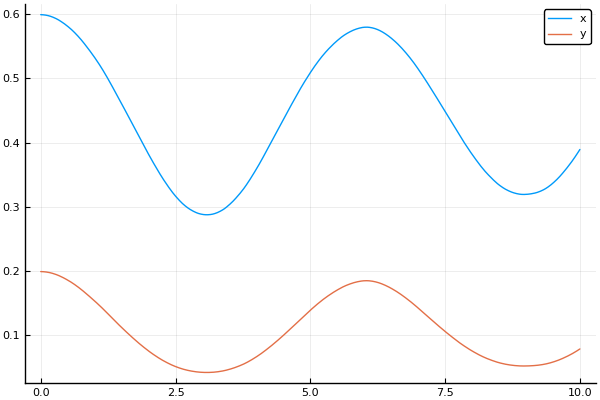

In [99]:
xtail_hist = []
ytail_hist = []

for i in 1:length(vs_reg)
    push!(xtail_hist,vs_reg[i][1,3,1])   
    push!(ytail_hist,vs_reg[i][1,3,2])    

end

plot(t_reg,xtail_hist,label="x")
plot!(t_reg,ytail_hist,label="y")

In [100]:
x_comp = [0.598948, 0.598948, 0.598948, 0.598948, 0.598947, 0.598947, 0.598946, 0.598944, 0.598942, 0.59894, 0.598938, 0.598936, 0.598933, 0.59893, 0.598927, 0.598923, 0.598919, 0.598916, 0.598911, 0.598907, 0.598902, 0.598897, 0.598893, 0.598887, 0.598882, 0.598877, 0.598871, 0.598865, 0.59886, 0.598854, 0.598848, 0.598842, 0.598836, 0.598829, 0.598823, 0.598816, 0.59881, 0.598803, 0.598796, 0.598789, 0.598781, 0.598774, 0.598767, 0.59876, 0.598752, 0.598745, 0.598737, 0.59873, 0.598722, 0.598714, 0.598706, 0.598698, 0.598689, 0.598681, 0.598673, 0.598664, 0.598655, 0.598645, 0.598636, 0.598626, 0.598617, 0.598607, 0.598597, 0.598587, 0.598576, 0.598566, 0.598555, 0.598544, 0.598533, 0.598523, 0.598512, 0.5985, 0.598489, 0.598478, 0.598466, 0.598455, 0.598443, 0.59843, 0.598418, 0.598405, 0.598393, 0.59838, 0.598367, 0.598354, 0.598342, 0.598329, 0.598316, 0.598304, 0.598291, 0.598278, 0.598265, 0.598252, 0.598239, 0.598226, 0.598212, 0.598199, 0.598185, 0.59817, 0.598156, 0.598141, 0.598126, 0.59811, 0.598094, 0.598078, 0.598062, 0.598046, 0.59803, 0.598015, 0.597999, 0.597983, 0.597967, 0.597951, 0.597934, 0.597917, 0.597901, 0.597884, 0.597867, 0.597849, 0.597832, 0.597814, 0.597797, 0.597779, 0.597762, 0.597745, 0.597727, 0.597709, 0.597691, 0.597673, 0.597655, 0.597636, 0.597618, 0.597599, 0.597579, 0.59756, 0.597541, 0.597521, 0.597501, 0.59748, 0.59746, 0.597439, 0.597418, 0.597397, 0.597376, 0.597355, 0.597333, 0.597312, 0.59729, 0.597269, 0.597246, 0.597224, 0.597201, 0.597178, 0.597155, 0.597132, 0.597108, 0.597084, 0.59706, 0.597035, 0.597011, 0.596987, 0.596962, 0.596937, 0.596913, 0.596888, 0.596863, 0.596839, 0.596814, 0.596789, 0.596764, 0.596739, 0.596713, 0.596687, 0.596661, 0.596634, 0.596608, 0.596581, 0.596554, 0.596526, 0.596499, 0.596472, 0.596444, 0.596417, 0.596389, 0.596362, 0.596335, 0.596308, 0.596281, 0.596254, 0.596227, 0.5962, 0.596172, 0.596144, 0.596116, 0.596087, 0.596058, 0.596029, 0.596, 0.595971, 0.595942, 0.595912, 0.595882, 0.595853, 0.595823, 0.595792, 0.595762, 0.595731, 0.5957, 0.595669, 0.595637, 0.595605, 0.595572, 0.59554, 0.595508, 0.595476, 0.595443, 0.595411, 0.595378, 0.595345, 0.595312, 0.595278, 0.595244, 0.595209, 0.595175, 0.595141, 0.595107, 0.595072, 0.595038, 0.595004, 0.594969, 0.594934, 0.594899, 0.594864, 0.594828, 0.594793, 0.594757, 0.594722, 0.594687, 0.594651, 0.594616, 0.594581, 0.594545, 0.59451, 0.594474, 0.594438, 0.594402, 0.594366, 0.59433, 0.594294, 0.594257, 0.594221, 0.594185, 0.594148, 0.594112, 0.594075, 0.594038, 0.594001, 0.593964, 0.593926, 0.593889, 0.59385, 0.593812, 0.593773, 0.593734, 0.593695, 0.593655, 0.593615, 0.593576, 0.593536, 0.593495, 0.593455, 0.593415, 0.593374, 0.593334, 0.593294, 0.593254, 0.593214, 0.593174, 0.593135, 0.593095, 0.593055, 0.593016, 0.592976, 0.592936, 0.592896, 0.592856, 0.592815, 0.592775, 0.592734, 0.592694, 0.592654, 0.592613, 0.592572, 0.592531, 0.59249, 0.592448, 0.592407, 0.592365, 0.592323, 0.592281, 0.592239, 0.592196, 0.592153, 0.59211, 0.592067, 0.592023, 0.591979, 0.591934, 0.591889, 0.591844, 0.591799, 0.591753, 0.591707, 0.591661, 0.591615, 0.591569, 0.591522, 0.591475, 0.591428, 0.591381, 0.591334, 0.591286, 0.591239, 0.591192, 0.591145, 0.591097, 0.59105, 0.591002, 0.590954, 0.590906, 0.590858, 0.59081, 0.590761, 0.590712, 0.590663, 0.590614, 0.590565, 0.590515, 0.590465, 0.590415, 0.590365, 0.590314, 0.590263, 0.590211, 0.590159, 0.590107, 0.590055, 0.590003, 0.589951, 0.589899, 0.589846, 0.589793, 0.58974, 0.589687, 0.589633, 0.589578, 0.589524, 0.58947, 0.589415, 0.58936, 0.589305, 0.589251, 0.589196, 0.589141, 0.589087, 0.589032, 0.588978, 0.588923, 0.588868, 0.588814, 0.588759, 0.588705, 0.58865, 0.588596, 0.588541, 0.588486, 0.588431, 0.588377, 0.588322, 0.588268, 0.588213, 0.588159, 0.588105, 0.58805, 0.587995, 0.587939, 0.587883, 0.587828, 0.587773, 0.587718, 0.587662, 0.587607, 0.587551, 0.587495, 0.587438, 0.587381, 0.587325, 0.587268, 0.587211, 0.587154, 0.587097, 0.58704, 0.586983, 0.586926, 0.586869, 0.586812, 0.586754, 0.586697, 0.586641, 0.586584, 0.586527, 0.586471, 0.586414, 0.586358, 0.586301, 0.586244, 0.586187, 0.58613, 0.586073, 0.586016, 0.585958, 0.5859, 0.585842, 0.585784, 0.585726, 0.585668, 0.58561, 0.585551, 0.585492, 0.585433, 0.585373, 0.585314, 0.585254, 0.585194, 0.585134, 0.585074, 0.585014, 0.584954, 0.584892, 0.584831, 0.58477, 0.584708, 0.584646, 0.584583, 0.58452, 0.584457, 0.584394, 0.584331, 0.584267, 0.584203, 0.584139, 0.584076, 0.584012, 0.583948, 0.583883, 0.583819, 0.583754, 0.58369, 0.583625, 0.583561, 0.583496, 0.583431, 0.583367, 0.583302, 0.583237, 0.583172, 0.583108, 0.583043, 0.582978, 0.582913, 0.582848, 0.582783, 0.582718, 0.582653, 0.582588, 0.582523, 0.582457, 0.582392, 0.582326, 0.58226, 0.582195, 0.582129, 0.582063, 0.581997, 0.58193, 0.581864, 0.581797, 0.58173, 0.581664, 0.581597, 0.58153, 0.581463, 0.581396, 0.581329, 0.581261, 0.581194, 0.581126, 0.581059, 0.580991, 0.580924, 0.580855, 0.580787, 0.580718, 0.580649, 0.580581, 0.580513, 0.580445, 0.580377, 0.580309, 0.580241, 0.580174, 0.580106, 0.580039, 0.579971, 0.579903, 0.579835, 0.579767, 0.579698, 0.579629, 0.57956, 0.579491, 0.579422, 0.579353, 0.579284, 0.579215, 0.579146, 0.579077, 0.579008, 0.578938, 0.578869, 0.578798, 0.578728, 0.578659, 0.578589, 0.578518, 0.578448, 0.578378, 0.578307, 0.578236, 0.578165, 0.578094, 0.578024, 0.577953, 0.577881, 0.57781, 0.577738, 0.577666, 0.577593, 0.577521, 0.577448, 0.577374, 0.577301, 0.577227, 0.577153, 0.577079, 0.577006, 0.576932, 0.576858, 0.576784, 0.576709, 0.576634, 0.576559, 0.576483, 0.576408, 0.576333, 0.576257, 0.576181, 0.576106, 0.57603, 0.575953, 0.575877, 0.5758, 0.575724, 0.575647, 0.57557, 0.575493, 0.575415, 0.575338, 0.57526, 0.575182, 0.575104, 0.575026, 0.574947, 0.574869, 0.574791, 0.574712, 0.574634, 0.574555, 0.574476, 0.574397, 0.574318, 0.574238, 0.574159, 0.57408, 0.574, 0.573921, 0.573841, 0.573761, 0.573681, 0.5736, 0.57352, 0.573439, 0.573358, 0.573277, 0.573196, 0.573114, 0.573033, 0.572951, 0.572869, 0.572787, 0.572705, 0.572622, 0.572539, 0.572456, 0.572373, 0.57229, 0.572207, 0.572123, 0.57204, 0.571956, 0.571872, 0.571787, 0.571703, 0.571618, 0.571534, 0.571449, 0.571365, 0.571281, 0.571196, 0.571112, 0.571028, 0.570944, 0.57086, 0.570775, 0.57069, 0.570605, 0.57052, 0.570435, 0.57035, 0.570265, 0.57018, 0.570095, 0.57001, 0.569926, 0.569841, 0.569756, 0.569671, 0.569585, 0.569499, 0.569413, 0.569326, 0.569239, 0.569152, 0.569065, 0.568978, 0.568891, 0.568804, 0.568716, 0.568629, 0.568541, 0.568453, 0.568364, 0.568276, 0.568187, 0.568097, 0.568008, 0.567918, 0.567827, 0.567737, 0.567647, 0.567556, 0.567466, 0.567375, 0.567285, 0.567194, 0.567104, 0.567013, 0.566922, 0.566831, 0.56674, 0.566649, 0.566558, 0.566467, 0.566377, 0.566286, 0.566195, 0.566104, 0.566013, 0.565922, 0.565832, 0.565741, 0.56565, 0.565559, 0.565468, 0.565377, 0.565285, 0.565193, 0.565101, 0.565008, 0.564916, 0.564823, 0.56473, 0.564637, 0.564543, 0.56445, 0.564357, 0.564264, 0.56417, 0.564077, 0.563984, 0.56389, 0.563796, 0.563701, 0.563607, 0.563512, 0.563418, 0.563323, 0.563228, 0.563133, 0.563038, 0.562943, 0.562848, 0.562752, 0.562657, 0.562561, 0.562464, 0.562369, 0.562273, 0.562177, 0.562081, 0.561985, 0.561889, 0.561792, 0.561695, 0.561598, 0.5615, 0.561402, 0.561305, 0.561208, 0.561111, 0.561013, 0.560916, 0.560818, 0.56072, 0.560622, 0.560524, 0.560427, 0.560329, 0.560231, 0.560132, 0.560034, 0.559936, 0.559838, 0.559739, 0.559641, 0.559542, 0.559443, 0.559344, 0.559245, 0.559145, 0.559046, 0.558946, 0.558846, 0.558747, 0.558647, 0.558547, 0.558446, 0.558345, 0.558244, 0.558143, 0.558042, 0.557941, 0.557839, 0.557737, 0.557636, 0.557534, 0.557432, 0.55733, 0.557228, 0.557125, 0.557022, 0.556919, 0.556816, 0.556713, 0.556609, 0.556505, 0.556402, 0.556297, 0.556193, 0.556089, 0.555984, 0.555879, 0.555774, 0.555668, 0.555563, 0.555458, 0.555352, 0.555247, 0.555141, 0.555035, 0.554928, 0.554822, 0.554715, 0.554608, 0.554502, 0.554395, 0.554288, 0.554181, 0.554074, 0.553967, 0.55386, 0.553753, 0.553646, 0.553539, 0.553432, 0.553325, 0.553218, 0.553112, 0.553006, 0.552899, 0.552793, 0.552686, 0.552579, 0.552472, 0.552365, 0.552257, 0.55215, 0.552042, 0.551935, 0.551827, 0.551719, 0.551611, 0.551503, 0.551395, 0.551287, 0.551179, 0.551071, 0.550964, 0.550856, 0.550748, 0.55064, 0.550533, 0.550425, 0.550318, 0.55021, 0.550103, 0.549996, 0.549889, 0.549781, 0.549674, 0.549566, 0.549458, 0.54935, 0.549242, 0.549134, 0.549025, 0.548916, 0.548808, 0.548699, 0.54859, 0.548481, 0.548372, 0.548262, 0.548153, 0.548043, 0.547934, 0.547824, 0.547714, 0.547604, 0.547494, 0.547383, 0.547273, 0.547162, 0.547051, 0.54694, 0.546829, 0.546717, 0.546606, 0.546495, 0.546384, 0.546272, 0.546161, 0.54605, 0.545939, 0.545827, 0.545716, 0.545604, 0.545493, 0.545381, 0.54527, 0.545159, 0.545047, 0.544936, 0.544824, 0.544713, 0.544601, 0.544489, 0.544377, 0.544264, 0.544152, 0.54404, 0.543928, 0.543815, 0.543702, 0.543589, 0.543477, 0.543363, 0.54325, 0.543136, 0.543023, 0.54291, 0.542796, 0.542682, 0.542569, 0.542455, 0.542341, 0.542227, 0.542114, 0.542, 0.541887, 0.541773, 0.541659, 0.541545, 0.54143, 0.541316, 0.541202, 0.541088, 0.540974, 0.54086, 0.540747, 0.540633, 0.540519, 0.540405, 0.540291, 0.540176, 0.540062, 0.539947, 0.539832, 0.539717, 0.539602, 0.539487, 0.539372, 0.539256, 0.53914, 0.539024, 0.538907, 0.538791, 0.538675, 0.53856, 0.538444, 0.538328, 0.538212, 0.538095, 0.537979, 0.537864, 0.537748, 0.537632, 0.537517, 0.537401, 0.537285, 0.537168, 0.537052, 0.536936, 0.536818, 0.536701, 0.536584, 0.536466, 0.536349, 0.536232, 0.536114, 0.535997, 0.53588, 0.535763, 0.535645, 0.535528, 0.53541, 0.535293, 0.535175, 0.535058, 0.53494, 0.534822, 0.534704, 0.534586, 0.534467, 0.534348, 0.534229, 0.534109, 0.533989, 0.533869, 0.533749, 0.533629, 0.533509, 0.533389, 0.533269, 0.533149, 0.533029, 0.532908, 0.532788, 0.532668, 0.532548, 0.532427, 0.532306, 0.532185, 0.532064, 0.531942, 0.531821, 0.5317, 0.531579, 0.531458, 0.531337, 0.531216, 0.531095, 0.530974, 0.530854, 0.530733, 0.530611, 0.53049, 0.530368, 0.530247, 0.530124, 0.530002, 0.52988, 0.529758, 0.529636, 0.529514, 0.529391, 0.529269, 0.529147, 0.529024, 0.528902, 0.528779, 0.528656, 0.528533, 0.52841, 0.528288, 0.528165
, 0.528042, 0.527919, 0.527796, 0.527672, 0.527548, 0.527424, 0.5273, 0.527176, 0.527052, 0.526927, 0.526803, 0.526678, 0.526553, 0.526429, 0.526304, 0.52618, 0.526055, 0.52593, 0.525805, 0.52568, 0.525556, 0.525431, 0.525306, 0.525181, 0.525056, 0.524931, 0.524805, 0.52468, 0.524554, 0.524427, 0.524301, 0.524174, 0.524048, 0.523921, 0.523795, 0.523668, 0.52354, 0.523413, 0.523285, 0.523157, 0.52303, 0.522902, 0.522774, 0.522646, 0.522517, 0.522389, 0.52226, 0.522131, 0.522002, 0.521872, 0.521743, 0.521614, 0.521485, 0.521356, 0.521226, 0.521096, 0.520966, 0.520836, 0.520706, 0.520575, 0.520444, 0.520313, 0.520182, 0.52005, 0.519918, 0.519786, 0.519654, 0.519522, 0.51939, 0.519257, 0.519125, 0.518992, 0.51886, 0.518727, 0.518595, 0.518462, 0.51833, 0.518197, 0.518064, 0.517931, 0.517798, 0.517665, 0.517532, 0.517399, 0.517265, 0.517131, 0.516997, 0.516862, 0.516728, 0.516594, 0.516459, 0.516324, 0.516189, 0.516054, 0.515919, 0.515783, 0.515647, 0.515511, 0.515375, 0.515239, 0.515103, 0.514967, 0.514831, 0.514696, 0.51456, 0.514424, 0.514289, 0.514154, 0.514018, 0.513882, 0.513746, 0.513609, 0.513472, 0.513335, 0.513197, 0.513059, 0.512922, 0.512784, 0.512647, 0.512509, 0.512371, 0.512233, 0.512094, 0.511956, 0.511818, 0.511679, 0.51154, 0.5114, 0.51126, 0.51112, 0.510981, 0.510841, 0.510702, 0.510563, 0.510424, 0.510285, 0.510146, 0.510006, 0.509867, 0.509727, 0.509587, 0.509447, 0.509306, 0.509166, 0.509026, 0.508885, 0.508745, 0.508605, 0.508465, 0.508325, 0.508185, 0.508044, 0.507903, 0.507762, 0.507621, 0.50748, 0.507339, 0.507198, 0.507056, 0.506914, 0.506772, 0.50663, 0.506488, 0.506345, 0.506203, 0.50606, 0.505917, 0.505774, 0.505631, 0.505488, 0.505344, 0.505201, 0.505057, 0.504914, 0.50477, 0.504626, 0.504482, 0.504338, 0.504193, 0.504049, 0.503904, 0.503759, 0.503614, 0.503469, 0.503324, 0.503179, 0.503033, 0.502887, 0.502741, 0.502595, 0.502449, 0.502303, 0.502157, 0.502011, 0.501864, 0.501717, 0.50157, 0.501423, 0.501277, 0.50113, 0.500983, 0.500837, 0.500689, 0.500542, 0.500396, 0.500249, 0.500102, 0.499955, 0.499808, 0.499661, 0.499513, 0.499365, 0.499217, 0.499069, 0.49892, 0.498772, 0.498623, 0.498474, 0.498325, 0.498176, 0.498027, 0.497878, 0.497729, 0.49758, 0.497431, 0.497282, 0.497133, 0.496984, 0.496834, 0.496684, 0.496534, 0.496384, 0.496234, 0.496084, 0.495934, 0.495784, 0.495633, 0.495483, 0.495333, 0.495184, 0.495034, 0.494884, 0.494734, 0.494583, 0.494433, 0.494282, 0.494132, 0.493981, 0.493831, 0.493681, 0.49353, 0.493379, 0.493228, 0.493078, 0.492927, 0.492776, 0.492625, 0.492474, 0.492323, 0.492171, 0.49202, 0.491869, 0.491719, 0.491568, 0.491418, 0.491267, 0.491117, 0.490966, 0.490816, 0.490665, 0.490514, 0.490363, 0.490212, 0.490062, 0.489911, 0.489761, 0.48961, 0.489459, 0.489308, 0.489157, 0.489006, 0.488855, 0.488703, 0.488551, 0.488399, 0.488247, 0.488095, 0.487942, 0.48779, 0.487637, 0.487484, 0.487331, 0.487178, 0.487025, 0.486871, 0.486717, 0.486563, 0.486409, 0.486255, 0.486102, 0.485948, 0.485794, 0.48564, 0.485487, 0.485333, 0.485178, 0.485024, 0.484869, 0.484713, 0.484558, 0.484403, 0.484248, 0.484092, 0.483936, 0.483781, 0.483625, 0.48347, 0.483314, 0.483159, 0.483005, 0.48285, 0.482696, 0.482541, 0.482387, 0.482233, 0.482079, 0.481924, 0.48177, 0.481615, 0.48146, 0.481305, 0.48115, 0.480995, 0.48084, 0.480685, 0.48053, 0.480375, 0.48022, 0.480065, 0.47991, 0.479756, 0.479601, 0.479447, 0.479293, 0.479139, 0.478985, 0.478831, 0.478677, 0.478524, 0.47837, 0.478216, 0.478062, 0.477907, 0.477753, 0.477599, 0.477444, 0.477289, 0.477134, 0.476979, 0.476825, 0.476671, 0.476517, 0.476363, 0.476209, 0.476055, 0.475901, 0.475747, 0.475593, 0.475438, 0.475284, 0.47513, 0.474976, 0.474822, 0.474668, 0.474514, 0.47436, 0.474206, 0.474052, 0.473897, 0.473743, 0.473588, 0.473433, 0.473279, 0.473124, 0.47297, 0.472815, 0.472661, 0.472507, 0.472353, 0.472198, 0.472043, 0.471889, 0.471734, 0.47158, 0.471425, 0.47127, 0.471115, 0.47096, 0.470805, 0.47065, 0.470495, 0.47034, 0.470185, 0.47003, 0.469875, 0.469721, 0.469566, 0.469411, 0.469255, 0.4691, 0.468945, 0.468791, 0.468636, 0.468481, 0.468325, 0.46817, 0.468015, 0.46786, 0.467705, 0.46755, 0.467395, 0.46724, 0.467085, 0.46693, 0.466774, 0.466618, 0.466462, 0.466305, 0.466149, 0.465992, 0.465836, 0.46568, 0.465524, 0.465368, 0.465212, 0.465056, 0.464901, 0.464745, 0.464589, 0.464434, 0.464278, 0.464122, 0.463967, 0.463811, 0.463656, 0.463501, 0.463346, 0.463191, 0.463037, 0.462882, 0.462727, 0.462572, 0.462418, 0.462263, 0.462109, 0.461955, 0.4618, 0.461645, 0.461491, 0.461336, 0.461181, 0.461026, 0.460871, 0.460716, 0.460562, 0.460407, 0.460253, 0.460098, 0.459943, 0.459788, 0.459634, 0.459479, 0.459325, 0.459171, 0.459016, 0.458862, 0.458707, 0.458553, 0.458398, 0.458244, 0.458089, 0.457934, 0.457779, 0.457624, 0.457469, 0.457314, 0.457158, 0.457002, 0.456847, 0.456691, 0.456535, 0.456379, 0.456224, 0.456068, 0.455913, 0.455758, 0.455603, 0.455448, 0.455293, 0.455138, 0.454983, 0.454827, 0.454671, 0.454516, 0.45436, 0.454205, 0.45405, 0.453895, 0.453739, 0.453584, 0.453428, 0.453273, 0.453117, 0.452961, 0.452804, 0.452648, 0.452492, 0.452335, 0.452179, 0.452023, 0.451866, 0.451709, 0.451552, 0.451395, 0.451239, 0.451082, 0.450924, 0.450767, 0.450609, 0.450452, 0.450294, 0.450137, 0.449979, 0.44982, 0.449662, 0.449504, 0.449345, 0.449186, 0.449027, 0.448869, 0.44871, 0.448551, 0.448393, 0.448234, 0.448075, 0.447916, 0.447757, 0.447599, 0.44744, 0.447282, 0.447124, 0.446965, 0.446807, 0.446649, 0.446491, 0.446333, 0.446175, 0.446018, 0.445859, 0.445701, 0.445543, 0.445386, 0.445228, 0.44507, 0.444912, 0.444754, 0.444596, 0.444438, 0.444279, 0.44412, 0.443961, 0.443802, 0.443643, 0.443484, 0.443325, 0.443165, 0.443006, 0.442847, 0.442688, 0.442529, 0.44237, 0.442211, 0.442052, 0.441893, 0.441734, 0.441575, 0.441417, 0.441259, 0.441101, 0.440943, 0.440786, 0.440628, 0.44047, 0.440312, 0.440155, 0.439997, 0.43984, 0.439682, 0.439525, 0.439367, 0.439209, 0.439052, 0.438895, 0.438738, 0.438581, 0.438424, 0.438267, 0.438111, 0.437954, 0.437798, 0.437642, 0.437485, 0.437329, 0.437173, 0.437016, 0.436859, 0.436703, 0.436546, 0.436389, 0.436232, 0.436076, 0.435919, 0.435762, 0.435605, 0.435448, 0.435292, 0.435135, 0.434978, 0.434821, 0.434664, 0.434507, 0.43435, 0.434193, 0.434036, 0.433879, 0.433722, 0.433565, 0.433407, 0.43325, 0.433093, 0.432936, 0.432778, 0.432621, 0.432464, 0.432306, 0.432148, 0.431991, 0.431833, 0.431675, 0.431516, 0.431358, 0.431199, 0.43104, 0.430882, 0.430723, 0.430565, 0.430406, 0.430247, 0.430087, 0.429928, 0.429768, 0.429608, 0.429447, 0.429288, 0.429128, 0.428967, 0.428807, 0.428647, 0.428487, 0.428326, 0.428166, 0.428006, 0.427846, 0.427686, 0.427525, 0.427366, 0.427205, 0.427045, 0.426885, 0.426724, 0.426564, 0.426404, 0.426243, 0.426082, 0.425921, 0.42576, 0.4256, 0.425439, 0.425277, 0.425116, 0.424955, 0.424793, 0.424632, 0.42447, 0.424309, 0.424147, 0.423985, 0.423824, 0.423663, 0.423502, 0.423341, 0.42318, 0.423019, 0.422859, 0.422698, 0.422537, 0.422376, 0.422215, 0.422055, 0.421894, 0.421733, 0.421572, 0.421412, 0.421251, 0.42109, 0.42093, 0.420769, 0.42061, 0.42045, 0.42029, 0.42013, 0.419971, 0.419812, 0.419653, 0.419494, 0.419335, 0.419176, 0.419017, 0.418858, 0.418699, 0.418539, 0.41838, 0.418221, 0.418061, 0.417902, 0.417742, 0.417582, 0.417423, 0.417264, 0.417104, 0.416945, 0.416786, 0.416627, 0.416468, 0.416309, 0.41615, 0.41599, 0.415831, 0.415672, 0.415513, 0.415353, 0.415194, 0.415034, 0.414875, 0.414716, 0.414557, 0.414398, 0.414239, 0.41408, 0.413921, 0.413762, 0.413603, 0.413444, 0.413285, 0.413126, 0.412967, 0.412807, 0.412648, 0.412489, 0.412329, 0.41217, 0.412011, 0.411852, 0.411693, 0.411534, 0.411375, 0.411216, 0.411058, 0.410899, 0.41074, 0.410581, 0.410422, 0.410263, 0.410104, 0.409944, 0.409785, 0.409626, 0.409467, 0.409308, 0.409149, 0.408991, 0.408833, 0.408674, 0.408517, 0.408359, 0.408201, 0.408043, 0.407885, 0.407727, 0.407569, 0.407411, 0.407254, 0.407096, 0.406938, 0.40678, 0.406622, 0.406465, 0.406307, 0.40615, 0.405992, 0.405835, 0.405678, 0.405521, 0.405364, 0.405206, 0.405049, 0.404892, 0.404736, 0.404579, 0.404423, 0.404268, 0.404112, 0.403956, 0.4038, 0.403645, 0.403489, 0.403333, 0.403177, 0.403021, 0.402865, 0.402709, 0.402553, 0.402397, 0.402241, 0.402085, 0.401929, 0.401773, 0.401617, 0.401461, 0.401305, 0.40115, 0.400994, 0.400838, 0.400683, 0.400527, 0.400372, 0.400216, 0.40006, 0.399904, 0.399747, 0.399592, 0.399436, 0.39928, 0.399124, 0.398968, 0.398812, 0.398657, 0.398501, 0.398345, 0.398189, 0.398032, 0.397876, 0.39772, 0.397563, 0.397407, 0.397251, 0.397095, 0.396938, 0.396782, 0.396626, 0.396471, 0.396315, 0.396159, 0.396003, 0.395848, 0.395692, 0.395536, 0.39538, 0.395225, 0.395069, 0.394913, 0.394757, 0.394601, 0.394446, 0.394291, 0.394136, 0.393981, 0.393826, 0.393671, 0.393515, 0.393359, 0.393203, 0.393047, 0.392891, 0.392736, 0.39258, 0.392424, 0.392268, 0.392112, 0.391956, 0.391801, 0.391645, 0.391489, 0.391333, 0.391177, 0.391021, 0.390866, 0.39071, 0.390555, 0.390399, 0.390243, 0.390087, 0.389931, 0.389775, 0.38962, 0.389465, 0.38931, 0.389156, 0.389001, 0.388847, 0.388693, 0.388539, 0.388384, 0.38823, 0.388076, 0.387922, 0.387769, 0.387615, 0.387461, 0.387307, 0.387154, 0.387, 0.386845, 0.386691, 0.386538, 0.386384, 0.38623, 0.386076, 0.385923, 0.385769, 0.385615, 0.385461, 0.385308, 0.385154, 0.385, 0.384847, 0.384693, 0.384539, 0.384386, 0.384232, 0.384078, 0.383925, 0.383771, 0.383618, 0.383465, 0.383311, 0.383158, 0.383004, 0.382851, 0.382698, 0.382545, 0.382392, 0.382239, 0.382086, 0.381933, 0.38178, 0.381628, 0.381475, 0.381323, 0.381171, 0.381018, 0.380866, 0.380713, 0.380561, 0.380409, 0.380257, 0.380104, 0.379952, 0.379799, 0.379646, 0.379493, 0.37934, 0.379187, 0.379034, 0.37888, 0.378727, 0.378574, 0.378421, 0.378268, 0.378116, 0.377964, 0.377812, 0.37766, 0.377508, 0.377356, 0.377204, 0.377052, 0.376901, 0.37675, 0.376599, 0.376449, 0.3763, 0.37615, 0.376001, 0.375851, 0.375702, 0.375553, 0.375404, 0.375255, 0.375107, 0.374959, 0.374811, 0.374663, 0.374515, 0.374368, 0.374221, 0.374073, 0.373926, 0.373779, 0.373632, 0.373486, 0.373339, 0.373193, 0.373046, 0.3729, 0.372754, 0.372608, 0.372462, 0.372316, 0.372169, 0.372023, 0.371876, 0.371729, 0.371581, 0.371434, 0.371286, 0.371139, 0.370991, 0.370844, 0.370697, 0.37055, 0.370403, 0.370256, 0.37011, 0.369963, 0.369816, 0.369669, 0.369522, 0.369375, 0.369229, 0.369083, 0.368936, 0.36879, 0.368644, 0.368499, 0.368353, 0.368208, 0.368063, 0.367918, 0.367774, 0.367629, 0.367485, 0.36734, 0.367196, 0.367052, 0.366907, 0.366763, 0.366618, 0.366474, 0.366329, 0.366185, 0.366041, 0.365897, 0.365753, 0.365608, 0.365464, 0.365319, 0.365174, 0.365029, 0.364885, 0.364741, 0.364597, 0.364453, 0.364309, 0.364165, 0.36402, 0.363876, 0.363732, 0.363587, 0.363443, 0.363298, 0.363153, 0.363009, 0.362864, 0.36272, 0.362575, 0.36243, 0.362285, 0.36214, 0.361995, 0.361851, 0.361707, 0.361563, 0.361419, 0.361275, 0.361131, 0.360987, 0.360843, 0.360699, 0.360556, 0.360412, 0.360269, 0.360126, 0.359983, 0.35984, 0.359697, 0.359555, 0.359413, 0.359271, 0.359129, 0.358987, 0.358845, 0.358703, 0.358561, 0.358419, 0.358277, 0.358135, 0.357994, 0.357852, 0.357711, 0.357569, 0.357428, 0.357286, 0.357145, 0.357004, 0.356863, 0.356722, 0.356582, 0.356441, 0.356301, 0.35616, 0.35602, 0.35588, 0.35574, 0.3556, 0.355461, 0.355321, 0.355181, 0.355041, 0.354901, 0.35476, 0.354621, 0.354481, 0.354342, 0.354202, 0.354063, 0.353924, 0.353785, 0.353647, 0.353509, 0.353371, 0.353233, 0.353096, 0.352959, 0.352822, 0.352684, 0.352547, 0.352409, 0.352272, 0.352135, 0.351998, 0.351862, 0.351725, 0.351588, 0.351452, 0.351315, 0.351178, 0.351041, 0.350904, 0.350767, 0.350631, 0.350493, 0.350356, 0.350219, 0.350082, 0.349946, 0.349809, 0.349674, 0.349538, 0.349402, 0.349266, 0.349131, 0.348996, 0.34886, 0.348725, 0.348589, 0.348454, 0.348319, 0.348184, 0.348048, 0.347913, 0.347778, 0.347644, 0.347509, 0.347375, 0.347241, 0.347107, 0.346974, 0.346841, 0.346708, 0.346576, 0.346443, 0.346311, 0.346179, 0.346047, 0.345915, 0.345782, 0.34565, 0.345517, 0.345385, 0.345253, 0.345121, 0.34499, 0.344859, 0.344728, 0.344597, 0.344467, 0.344337, 0.344207, 0.344077, 0.343948, 0.343819, 0.343689, 0.34356, 0.343432, 0.343303, 0.343176, 0.343048, 0.342921, 0.342794, 0.342667, 0.34254, 0.342413, 0.342286, 0.34216, 0.342034, 0.341907, 0.341781, 0.341655, 0.341529, 0.341403, 0.341277, 0.341151, 0.341025, 0.340898, 0.340772, 0.340646, 0.34052, 0.340394, 0.340269, 0.340144, 0.340018, 0.339893, 0.339767, 0.339642, 0.339516, 0.339391, 0.339266, 0.339141, 0.339016, 0.338891, 0.338767, 0.338643, 0.338519, 0.338395, 0.33827, 0.338146, 0.338021, 0.337897, 0.337772, 0.337648, 0.337523, 0.337398, 0.337273, 0.337148, 0.337023, 0.336898, 0.336774, 0.336649, 0.336525, 0.3364, 0.336276, 0.336152, 0.336027, 0.335903, 0.335778, 0.335654, 0.33553, 0.335406, 0.335283, 0.335159, 0.335036, 0.334912, 0.334788, 0.334665, 0.334541, 0.334418, 0.334295, 0.334173, 0.33405, 0.333928, 0.333806, 0.333685, 0.333563, 0.333441, 0.333319, 0.333198, 0.333077, 0.332957, 0.332837, 0.332717, 0.332597, 0.332477, 0.332357, 0.332237, 0.332116, 0.331996, 0.331875, 0.331755, 0.331635, 0.331515, 0.331396, 0.331276, 0.331157, 0.331038, 0.330918, 0.330799, 0.330681, 0.330562, 0.330443, 0.330325, 0.330206, 0.330088, 0.32997, 0.329852, 0.329733, 0.329614, 0.329496, 0.329377, 0.329258, 0.329139, 0.329021, 0.328903, 0.328785, 0.328667, 0.328549, 0.328431, 0.328313, 0.328194, 0.328076, 0.327958, 0.32784, 0.327722, 0.327605, 0.327488, 0.327371, 0.327255, 0.327139, 0.327023, 0.326907, 0.326792, 0.326677, 0.326562, 0.326448, 0.326333, 0.326219, 0.326105, 0.325991, 0.325878, 0.325766, 0.325653, 0.325541, 0.325429, 0.325316, 0.325203, 0.325091, 0.324979, 0.324867, 0.324755, 0.324643, 0.324532, 0.32442, 0.324309, 0.324198, 0.324086, 0.323975, 0.323865, 0.323754, 0.323644, 0.323534, 0.323424, 0.323314, 0.323205, 0.323096, 0.322987, 0.322879, 0.322771, 0.322664, 0.322557, 0.322449, 0.322342, 0.322235, 0.322128, 0.322021, 0.321914, 0.321808, 0.321702, 0.321596, 0.321491, 0.321385, 0.32128, 0.321175, 0.32107, 0.320965, 0.32086, 0.320755, 0.320651, 0.320546, 0.320442, 0.320338, 0.320234, 0.32013, 0.320027, 0.319924, 0.319821, 0.319718, 0.319615, 0.319512, 0.319409, 0.319306, 0.319203, 0.319101, 0.318998, 0.318896, 0.318793, 0.318691, 0.318589, 0.318487, 0.318385, 0.318284, 0.318182, 0.318081, 0.317979, 0.317877, 0.317776, 0.317675, 0.317574, 0.317473, 0.317373, 0.317273, 0.317173, 0.317073, 0.316974, 0.316874, 0.316775, 0.316676, 0.316578, 0.31648, 0.316382, 0.316285, 0.316188, 0.316091, 0.315993, 0.315895, 0.315797, 0.315699, 0.315602, 0.315504, 0.315407, 0.31531, 0.315214, 0.315117, 0.315021, 0.314925, 0.314828, 0.314732, 0.314635, 0.314539, 0.314442, 0.314346, 0.31425, 0.314154, 0.314059, 0.313964, 0.313869, 0.313775, 0.313682, 0.313589, 0.313496, 0.313402, 0.313309, 0.313216, 0.313123, 0.31303, 0.312938, 0.312846, 0.312754, 0.312662, 0.31257, 0.312479, 0.312387, 0.312295, 0.312203, 0.312112, 0.31202, 0.311929, 0.311838, 0.311747, 0.311656, 0.311566, 0.311476, 0.311385, 0.311295, 0.311205, 0.311115, 0.311025, 0.310935, 0.310844, 0.310754, 0.310664, 0.310574, 0.310485, 0.310395, 0.310306, 0.310217, 0.310128, 0.31004, 0.309952, 0.309864, 0.309776, 0.309688, 0.3096, 0.309511, 0.309423, 0.309335, 0.309248, 0.30916, 0.309073, 0.308986, 0.308899, 0.308813, 0.308727, 0.308641, 0.308555, 0.308469, 0.308383, 0.308297, 0.308211, 0.308125, 0.308038, 0.307952, 0.307866, 0.30778, 0.307694, 0.307608, 0.307522, 0.307436, 0.307351, 0.307267, 0.307182, 0.307097, 0.307013, 0.306929, 0.306844, 0.30676, 0.306677, 0.306594, 0.30651, 0.306427, 0.306345, 0.306263, 0.306182, 0.306101, 0.30602, 0.30594, 0.30586, 0.30578, 0.305701, 0.305622, 0.305544, 0.305466, 0.305389, 0.305312, 0.305234, 0.305157, 0.30508, 0.305003, 0.304926, 0.30485, 0.304773, 0.304697, 0.304621, 0.304545, 0.304469, 0.304394, 0.304318, 0.304243, 0.304169, 0.304094, 0.30402, 0.303946, 0.303872, 0.303799, 0.303725, 0.303651, 0.303578, 0.303504, 0.303431, 0.303357, 0.303284, 0.30321, 0.303138, 0.303065, 0.302993, 0.30292, 0.302848, 0.302777, 0.302705, 0.302634, 0.302562, 0.302491, 0.30242, 0.302349, 0.302279, 0.302209, 0.302139, 0.302069, 0.301999, 0.301929, 0.301859, 0.301789, 0.30172, 0.301651, 0.301582, 0.301514, 0.301445, 0.301377, 0.30131, 0.301243, 0.301175, 0.301108, 0.301041, 0.300975, 0.300909, 0.300843, 0.300776, 0.30071, 0.300644, 0.300578, 0.300512, 0.300446, 0.300381, 0.300315, 0.30025, 0.300186, 0.300121, 0.300057, 0.299993, 0.299929, 0.299865, 0.299801, 0.299738, 0.299674, 0.299611, 0.299548, 0.299486, 0.299424, 0.299361, 0.299299, 0.299236, 0.299173, 0.29911, 0.299047, 0.298984, 0.298921, 0.298859, 0.298796, 0.298734, 0.298671, 0.298609, 0.298548, 0.298486, 0.298425, 0.298364, 0.298302, 0.298241, 0.298179, 0.298118, 0.298058, 0.297997, 0.297937, 0.297877, 0.297817, 0.297758, 0.297699, 0.29764, 0.297582, 0.297523, 0.297465, 0.297408, 0.29735, 0.297293, 0.297236, 0.29718, 0.297123, 0.297067, 0.297012, 0.296956, 0.296901, 0.296846, 0.296792, 0.296738, 0.296683, 0.296629, 0.296576, 0.296522, 0.296469, 0.296417, 0.296364, 0.296311, 0.296259, 0.296208, 0.296156, 0.296104, 0.296053, 0.296002, 0.295951, 0.2959, 0.295849, 0.295798, 0.295748, 0.295697, 0.295647, 0.295597, 0.295547, 0.295497, 0.295447, 0.295398, 0.295348, 0.2953, 0.295251, 0.295202, 0.295153, 0.295104
, 0.295055, 0.295006, 0.294957, 0.294908, 0.29486, 0.294812, 0.294764, 0.294716, 0.294668, 0.29462, 0.294571, 0.294523, 0.294474, 0.294426, 0.294378, 0.29433, 0.294281, 0.294233, 0.294185, 0.294137, 0.294089, 0.294042, 0.293994, 0.293946, 0.293898, 0.29385, 0.293803, 0.293756, 0.29371, 0.293663, 0.293617, 0.293572, 0.293526, 0.293481, 0.293436, 0.293391, 0.293347, 0.293303, 0.293259, 0.293215, 0.293171, 0.293128, 0.293084, 0.293042, 0.292999, 0.292956, 0.292913, 0.29287, 0.292827, 0.292785, 0.292742, 0.2927, 0.292657, 0.292615, 0.292573, 0.292531, 0.292489, 0.292448, 0.292406, 0.292365, 0.292323, 0.292282, 0.29224, 0.292199, 0.292159, 0.292118, 0.292078, 0.292037, 0.291997, 0.291957, 0.291917, 0.291878, 0.291838, 0.291799, 0.29176, 0.291722, 0.291684, 0.291645, 0.291607, 0.291569, 0.291531, 0.291493, 0.291455, 0.291417, 0.291379, 0.291342, 0.291304, 0.291267, 0.291231, 0.291194, 0.291158, 0.291122, 0.291086, 0.29105, 0.291014, 0.290978, 0.290942, 0.290907, 0.290872, 0.290837, 0.290801, 0.290766, 0.29073, 0.290695, 0.29066, 0.290625, 0.290591, 0.290558, 0.290524, 0.290491, 0.290459, 0.290427, 0.290395, 0.290363, 0.290331, 0.2903, 0.290269, 0.290238, 0.290208, 0.290177, 0.290147, 0.290118, 0.290088, 0.290059, 0.290031, 0.290003, 0.289975, 0.289947, 0.289919, 0.289892, 0.289864, 0.289836, 0.289808, 0.28978, 0.289752, 0.289724, 0.289697, 0.289669, 0.289643, 0.289617, 0.289591, 0.289565, 0.289539, 0.289514, 0.289489, 0.289465, 0.289441, 0.289417, 0.289393, 0.289369, 0.289346, 0.289322, 0.289299, 0.289276, 0.289253, 0.28923, 0.289207, 0.289184, 0.289161, 0.289139, 0.289116, 0.289093, 0.289071, 0.289048, 0.289026, 0.289004, 0.288983, 0.288961, 0.288939, 0.288917, 0.288896, 0.288875, 0.288854, 0.288833, 0.288813, 0.288793, 0.288774, 0.288755, 0.288735, 0.288717, 0.288698, 0.288679, 0.28866, 0.288641, 0.288623, 0.288605, 0.288587, 0.28857, 0.288553, 0.288536, 0.288519, 0.288502, 0.288485, 0.288469, 0.288453, 0.288437, 0.288421, 0.288406, 0.28839, 0.288374, 0.288359, 0.288343, 0.288328, 0.288313, 0.288298, 0.288283, 0.288268, 0.288252, 0.288237, 0.288222, 0.288207, 0.288193, 0.288179, 0.288165, 0.288151, 0.288137, 0.288124, 0.288111, 0.288098, 0.288085, 0.288072, 0.288059, 0.288046, 0.288033, 0.28802, 0.288008, 0.287996, 0.287984, 0.287972, 0.28796, 0.287948, 0.287937, 0.287925, 0.287914, 0.287903, 0.287892, 0.287882, 0.287872, 0.287862, 0.287852, 0.287843, 0.287834, 0.287825, 0.287816, 0.287808, 0.2878, 0.287793, 0.287786, 0.287778, 0.287772, 0.287765, 0.287758, 0.287751, 0.287745, 0.287739, 0.287733, 0.287727, 0.287721, 0.287715, 0.28771, 0.287704, 0.287699, 0.287694, 0.287689, 0.287685, 0.28768, 0.287676, 0.287672, 0.287667, 0.287663, 0.287659, 0.287655, 0.287651, 0.287648, 0.287646, 0.287644, 0.287641, 0.287639, 0.287636, 0.287633, 0.287631, 0.28763, 0.287628, 0.287627, 0.287625, 0.287624, 0.287622, 0.287621, 0.28762, 0.287619, 0.287618, 0.287617, 0.287617, 0.287618, 0.287618, 0.287619, 0.28762, 0.287621, 0.287622, 0.287624, 0.287625, 0.287626, 0.287628, 0.287629, 0.28763, 0.287632, 0.287635, 0.287637, 0.28764, 0.287643, 0.287646, 0.287649, 0.287652, 0.287655, 0.287659, 0.287664, 0.287668, 0.287672, 0.287677, 0.287682, 0.287687, 0.287692, 0.287698, 0.287704, 0.28771, 0.287716, 0.287722, 0.287728, 0.287735, 0.287742, 0.287749, 0.287756, 0.287763, 0.28777, 0.287777, 0.287785, 0.287792, 0.2878, 0.287807, 0.287814, 0.287822, 0.287831, 0.287839, 0.287847, 0.287856, 0.287864, 0.287873, 0.287882, 0.28789, 0.287899, 0.287907, 0.287916, 0.287925, 0.287935, 0.287944, 0.287954, 0.287964, 0.287974, 0.287984, 0.287994, 0.288004, 0.288014, 0.288024, 0.288034, 0.288045, 0.288056, 0.288067, 0.288078, 0.288088, 0.2881, 0.288111, 0.288123, 0.288135, 0.288147, 0.28816, 0.288173, 0.288186, 0.288199, 0.288213, 0.288227, 0.288241, 0.288256, 0.288271, 0.288287, 0.288302, 0.288318, 0.288334, 0.288351, 0.288367, 0.288384, 0.288401, 0.288418, 0.288435, 0.288453, 0.288471, 0.288489, 0.288507, 0.288526, 0.288545, 0.288564, 0.288584, 0.288603, 0.288622, 0.288642, 0.288663, 0.288683, 0.288704, 0.288724, 0.288745, 0.288767, 0.288789, 0.288811, 0.288833, 0.288855, 0.288877, 0.288899, 0.288921, 0.288943, 0.288965, 0.288988, 0.289011, 0.289035, 0.289058, 0.289082, 0.289106, 0.28913, 0.289155, 0.289181, 0.289206, 0.289232, 0.289258, 0.289284, 0.28931, 0.289336, 0.289362, 0.289388, 0.289413, 0.289439, 0.289466, 0.289492, 0.289518, 0.289545, 0.289572, 0.289599, 0.289626, 0.289653, 0.28968, 0.289709, 0.289737, 0.289766, 0.289795, 0.289825, 0.289854, 0.289884, 0.289913, 0.289943, 0.289974, 0.290004, 0.290033, 0.290063, 0.290093, 0.290122, 0.290152, 0.290181, 0.290211, 0.290241, 0.29027, 0.290301, 0.290331, 0.290363, 0.290394, 0.290425, 0.290456, 0.290487, 0.290519, 0.290551, 0.290583, 0.290615, 0.290647, 0.29068, 0.290713, 0.290747, 0.290781, 0.290816, 0.290851, 0.290886, 0.290922, 0.290958, 0.290995, 0.291031, 0.291068, 0.291104, 0.29114, 0.291177, 0.291214, 0.291251, 0.291289, 0.291326, 0.291364, 0.291402, 0.29144, 0.291478, 0.291517, 0.291556, 0.291595, 0.291634, 0.291673, 0.291712, 0.291752, 0.291792, 0.291832, 0.291872, 0.291913, 0.291954, 0.291995, 0.292037, 0.292079, 0.29212, 0.292162, 0.292204, 0.292245, 0.292287, 0.292328, 0.29237, 0.292412, 0.292454, 0.292495, 0.292537, 0.292579, 0.29262, 0.292662, 0.292704, 0.292746, 0.292789, 0.292831, 0.292874, 0.292916, 0.292959, 0.293001, 0.293043, 0.293085, 0.293128, 0.293171, 0.293214, 0.293257, 0.2933, 0.293343, 0.293387, 0.293431, 0.293476, 0.293521, 0.293567, 0.293613, 0.293659, 0.293705, 0.293752, 0.293798, 0.293845, 0.293892, 0.293939, 0.293985, 0.294032, 0.294078, 0.294124, 0.294171, 0.294218, 0.294266, 0.294314, 0.294362, 0.294411, 0.29446, 0.294509, 0.294559, 0.294608, 0.294658, 0.294707, 0.294756, 0.294805, 0.294855, 0.294904, 0.294954, 0.295003, 0.295052, 0.295102, 0.295151, 0.295201, 0.295252, 0.295303, 0.295354, 0.295406, 0.295459, 0.295511, 0.295564, 0.295617, 0.295671, 0.295724, 0.295778, 0.295833, 0.295887, 0.295942, 0.295997, 0.296052, 0.296107, 0.296163, 0.296219, 0.296275, 0.29633, 0.296386, 0.296443, 0.2965, 0.296557, 0.296614, 0.296671, 0.296729, 0.296787, 0.296845, 0.296902, 0.29696, 0.297019, 0.297078, 0.297137, 0.297197, 0.297257, 0.297318, 0.297378, 0.29744, 0.297501, 0.297563, 0.297626, 0.297689, 0.297752, 0.297815, 0.297879, 0.297943, 0.298006, 0.29807, 0.298134, 0.298198, 0.298263, 0.298327, 0.298392, 0.298458, 0.298523, 0.298588, 0.298654, 0.298719, 0.298785, 0.29885, 0.298917, 0.298983, 0.29905, 0.299118, 0.299185, 0.299252, 0.29932, 0.299389, 0.299458, 0.299527, 0.299596, 0.299665, 0.299735, 0.299804, 0.299873, 0.299942, 0.300012, 0.300081, 0.300151, 0.300221, 0.30029, 0.300361, 0.300431, 0.300502, 0.300573, 0.300644, 0.300716, 0.300786, 0.300857, 0.300928, 0.300999, 0.301071, 0.301143, 0.301215, 0.301287, 0.30136, 0.301432, 0.301505, 0.301577, 0.30165, 0.301723, 0.301796, 0.301869, 0.301942, 0.302015, 0.302089, 0.302162, 0.302236, 0.30231, 0.302384, 0.302459, 0.302533, 0.302607, 0.302682, 0.302756, 0.30283, 0.302904, 0.302978, 0.303052, 0.303126, 0.3032, 0.303275, 0.30335, 0.303424, 0.303499, 0.303573, 0.303648, 0.303723, 0.303798, 0.303873, 0.303948, 0.304023, 0.304097, 0.304172, 0.304247, 0.304323, 0.304399, 0.304475, 0.304551, 0.304627, 0.304704, 0.304782, 0.304859, 0.304937, 0.305015, 0.305093, 0.305171, 0.305249, 0.305327, 0.305405, 0.305483, 0.30556, 0.305638, 0.305715, 0.305793, 0.305871, 0.30595, 0.306029, 0.306109, 0.306189, 0.306269, 0.306349, 0.306429, 0.306509, 0.30659, 0.306671, 0.306752, 0.306834, 0.306915, 0.306997, 0.307079, 0.307161, 0.307243, 0.307325, 0.307407, 0.307489, 0.307571, 0.307654, 0.307737, 0.30782, 0.307903, 0.307986, 0.308069, 0.308153, 0.308237, 0.308321, 0.308406, 0.30849, 0.308575, 0.30866, 0.308745, 0.30883, 0.308915, 0.309001, 0.309087, 0.309173, 0.30926, 0.309347, 0.309434, 0.309521, 0.309608, 0.309695, 0.309782, 0.309869, 0.309956, 0.310043, 0.31013, 0.310217, 0.310305, 0.310393, 0.310481, 0.31057, 0.310658, 0.310747, 0.310836, 0.310925, 0.311015, 0.311105, 0.311195, 0.311285, 0.311376, 0.311467, 0.311557, 0.311648, 0.311739, 0.31183, 0.311921, 0.312011, 0.312102, 0.312194, 0.312285, 0.312377, 0.31247, 0.312562, 0.312654, 0.312747, 0.312839, 0.312932, 0.313026, 0.31312, 0.313213, 0.313307, 0.313401, 0.313495, 0.313589, 0.313682, 0.313776, 0.31387, 0.313965, 0.314059, 0.314152, 0.314246, 0.31434, 0.314434, 0.314528, 0.314622, 0.314717, 0.314811, 0.314906, 0.315001, 0.315095, 0.315189, 0.315284, 0.31538, 0.315475, 0.315571, 0.315666, 0.315761, 0.315857, 0.315952, 0.316048, 0.316143, 0.316239, 0.316335, 0.31643, 0.316526, 0.316622, 0.316718, 0.316814, 0.316909, 0.317005, 0.317101, 0.317197, 0.317293, 0.317389, 0.317486, 0.317583, 0.31768, 0.317777, 0.317874, 0.317972, 0.318069, 0.318167, 0.318264
, 0.318362, 0.31846, 0.318558, 0.318656, 0.318754, 0.318852, 0.318951, 0.31905, 0.319148, 0.319247, 0.319347, 0.319446, 0.319546, 0.319647, 0.319747, 0.319848, 0.319948, 0.32005, 0.320151, 0.320252, 0.320353, 0.320454, 0.320555, 0.320657, 0.320759, 0.320861, 0.320963, 0.321066, 0.321168, 0.321271, 0.321374, 0.321477, 0.32158, 0.321683, 0.321787, 0.32189, 0.321994, 0.322097, 0.3222, 0.322304, 0.322407, 0.32251, 0.322614, 0.322717, 0.322821, 0.322925, 0.323029, 0.323134, 0.323238, 0.323343, 0.323448, 0.323553, 0.323658, 0.323763, 0.323868, 0.323974, 0.32408, 0.324185, 0.324291, 0.324398, 0.324504, 0.32461, 0.324717, 0.324823, 0.32493, 0.325037, 0.325144, 0.325251, 0.325359, 0.325467, 0.325574, 0.325682, 0.32579, 0.325899, 0.326008, 0.326117, 0.326226, 0.326335, 0.326445, 0.326555, 0.326665, 0.326775, 0.326885, 0.326996, 0.327107, 0.327217, 0.327328, 0.32744, 0.327551, 0.327662, 0.327774, 0.327885, 0.327997, 0.328109, 0.328222, 0.328334, 0.328447, 0.328561, 0.328675, 0.328789, 0.328903, 0.329018, 0.329133, 0.329248, 0.329363, 0.329479, 0.329594, 0.32971, 0.329827, 0.329944, 0.330061, 0.330178, 0.330296, 0.330413, 0.330531, 0.330649, 0.330767, 0.330885, 0.331003, 0.331121, 0.331239, 0.331358, 0.331476, 0.331596, 0.331715, 0.331835, 0.331954, 0.332075, 0.332195, 0.332315, 0.332435, 0.332556, 0.332676, 0.332797, 0.332917, 0.333038, 0.333159, 0.33328, 0.333402, 0.333524, 0.333647, 0.333769, 0.333891, 0.334014, 0.334136, 0.334259, 0.334381, 0.334503, 0.334625, 0.334747, 0.334869, 0.334992, 0.335114, 0.335237, 0.33536, 0.335483, 0.335605, 0.335728, 0.335851, 0.335974, 0.336098, 0.336222, 0.336347, 0.336472, 0.336598, 0.336723, 0.336849, 0.336975, 0.337101, 0.337227, 0.337353, 0.337479, 0.337605, 0.337732, 0.337858, 0.337985, 0.338112, 0.338239, 0.338366, 0.338493, 0.338621, 0.338749, 0.338877, 0.339005, 0.339133, 0.339262, 0.339391, 0.33952, 0.339649, 0.339778, 0.339907, 0.340035, 0.340163, 0.340292, 0.340421, 0.34055, 0.340679, 0.340809, 0.340938, 0.341068, 0.341198, 0.341328, 0.341458, 0.341588, 0.341718, 0.341848, 0.341978, 0.342108, 0.342238, 0.342369, 0.342499, 0.34263, 0.342761, 0.342893, 0.343025, 0.343157, 0.34329, 0.343422, 0.343555, 0.343688, 0.34382, 0.343953, 0.344085, 0.344217, 0.34435, 0.344482, 0.344615, 0.344747, 0.34488, 0.345013, 0.345146, 0.345279, 0.345413, 0.345547, 0.345681, 0.345816, 0.34595, 0.346085, 0.34622, 0.346355, 0.34649, 0.346625, 0.346761, 0.346896, 0.347031, 0.347166, 0.347302, 0.347437, 0.347573, 0.347709, 0.347845, 0.347981, 0.348117, 0.348253, 0.34839, 0.348527, 0.348665, 0.348802, 0.348939, 0.349076, 0.349214, 0.349351, 0.349488, 0.349625, 0.349763, 0.3499, 0.350037, 0.350175, 0.350312, 0.350449, 0.350586, 0.350724, 0.350861, 0.350998, 0.351136, 0.351273, 0.351411, 0.351549, 0.351686, 0.351824, 0.351961, 0.352098, 0.352236, 0.352373, 0.35251, 0.352647, 0.352784, 0.352922, 0.35306, 0.353197, 0.353334, 0.353472, 0.353609, 0.353746, 0.353883, 0.354021, 0.354158, 0.354296, 0.354433, 0.354571, 0.354709, 0.354847, 0.354985, 0.355123, 0.355262, 0.355401, 0.35554, 0.355679, 0.355818, 0.355957, 0.356096, 0.356235, 0.356375, 0.356515, 0.356655, 0.356795, 0.356935, 0.357075, 0.357216, 0.357357, 0.357498, 0.357638, 0.35778, 0.357921, 0.358063, 0.358205, 0.358346, 0.358488, 0.35863, 0.358772, 0.358914, 0.359057, 0.359199, 0.359341, 0.359483, 0.359625, 0.359767, 0.35991, 0.360052, 0.360195, 0.360337, 0.36048, 0.360622, 0.360765, 0.360908, 0.36105, 0.361193, 0.361335, 0.361477, 0.361619, 0.361761, 0.361903, 0.362044, 0.362186, 0.362328, 0.362469, 0.36261, 0.362752, 0.362894, 0.363037, 0.36318, 0.363323, 0.363466, 0.363609, 0.363752, 0.363896, 0.364039, 0.364182, 0.364326, 0.36447, 0.364614, 0.364758, 0.364902, 0.365046, 0.365191, 0.365336, 0.365482, 0.365627, 0.365773, 0.365918, 0.366064, 0.36621, 0.366356, 0.366503, 0.366649, 0.366796, 0.366943, 0.367089, 0.367236, 0.367383, 0.36753, 0.367676, 0.367823, 0.36797, 0.368117, 0.368263, 0.368411, 0.368558, 0.368706, 0.368854, 0.369003, 0.369151, 0.3693, 0.36945, 0.3696, 0.369749, 0.369899, 0.370049, 0.370199, 0.37035, 0.3705, 0.370651, 0.370801, 0.370951, 0.371101, 0.371252, 0.371403, 0.371553, 0.371704, 0.371855, 0.372006, 0.372157, 0.372307, 0.372458, 0.37261, 0.372761, 0.372912, 0.373062, 0.373213, 0.373364, 0.373516, 0.373668, 0.37382, 0.373972, 0.374123, 0.374275, 0.374428, 0.37458, 0.374733, 0.374886, 0.375039, 0.375192, 0.375345, 0.375498, 0.375651, 0.375805, 0.375958, 0.376112, 0.376266, 0.37642, 0.376575, 0.376729, 0.376883, 0.377038, 0.377192, 0.377346, 0.377501, 0.377655, 0.377809, 0.377963, 0.378118, 0.378272, 0.378427, 0.378582, 0.378737, 0.378892, 0.379046, 0.379201, 0.379355, 0.379509, 0.379664, 0.379818, 0.379972, 0.380126, 0.380281, 0.380436, 0.380591, 0.380745, 0.3809, 0.381054, 0.381209, 0.381364, 0.381518, 0.381673, 0.381828, 0.381982, 0.382137, 0.382291, 0.382445, 0.382599, 0.382753, 0.382907, 0.383061, 0.383216, 0.38337, 0.383525, 0.383679, 0.383834, 0.383988, 0.384143, 0.384298, 0.384452, 0.384607, 0.384761, 0.384915, 0.385069, 0.385223, 0.385377, 0.385531, 0.385685, 0.385838, 0.385991, 0.386145, 0.386298, 0.386451, 0.386605, 0.386758, 0.386911, 0.387065, 0.387218, 0.38737, 0.387523, 0.387676, 0.387829, 0.387983, 0.388136, 0.388289, 0.388443, 0.388596, 0.388749, 0.388903, 0.389056, 0.38921, 0.389364, 0.389518, 0.389671, 0.389825, 0.389979, 0.390132, 0.390286, 0.39044, 0.390593, 0.390747, 0.390901, 0.391055, 0.391209, 0.391362, 0.391516, 0.39167, 0.391824, 0.391978, 0.392131, 0.392285, 0.392439, 0.392593, 0.392747, 0.392901, 0.393055, 0.39321, 0.393364, 0.393518, 0.393673, 0.393829, 0.393984, 0.394139, 0.394294, 0.394448, 0.394603, 0.394758, 0.394913, 0.395069, 0.395224, 0.39538, 0.395535, 0.395691, 0.395847, 0.396003, 0.396159, 0.396314, 0.396469, 0.396625, 0.39678, 0.396936, 0.397092, 0.397247, 0.397403, 0.397558, 0.397714, 0.397871, 0.398027, 0.398183, 0.39834, 0.398496, 0.398653, 0.398809, 0.398966, 0.399123, 0.39928, 0.399437, 0.399594, 0.399751, 0.399907, 0.400064, 0.400221, 0.400378, 0.400536, 0.400693, 0.40085, 0.401006, 0.401163, 0.40132, 0.401476, 0.401633, 0.401789, 0.401946, 0.402103, 0.40226, 0.402417, 0.402573, 0.40273, 0.402887, 0.403044, 0.403201, 0.403358, 0.403515, 0.403672, 0.40383, 0.403987, 0.404145, 0.404303, 0.40446, 0.404618, 0.404775, 0.404932, 0.405089, 0.405246, 0.405403, 0.40556, 0.405718, 0.405875, 0.406032, 0.40619, 0.406347, 0.406505, 0.406663, 0.40682, 0.406978, 0.407135, 0.407292, 0.407449, 0.407606, 0.407763, 0.40792, 0.408076, 0.408233, 0.40839, 0.408548, 0.408705, 0.408863, 0.409021, 0.409179, 0.409336, 0.409494, 0.409652, 0.409809, 0.409966, 0.410123, 0.41028, 0.410437, 0.410595, 0.410752, 0.410909, 0.411067, 0.411224, 0.411382, 0.411539, 0.411696, 0.411854, 0.412011, 0.412168, 0.412325, 0.412481, 0.412638, 0.412795, 0.412952, 0.413109, 0.413265, 0.413422, 0.413579, 0.413736, 0.413892, 0.414049, 0.414206, 0.414363, 0.414521, 0.414678, 0.414836, 0.414993, 0.41515, 0.415307, 0.415464, 0.415621, 0.415778, 0.415934, 0.416091, 0.416247, 0.416404, 0.416561, 0.416719, 0.416876, 0.417033, 0.417191, 0.417348, 0.417505, 0.417662, 0.417819, 0.417976, 0.418134, 0.418291, 0.418449, 0.418606, 0.418762, 0.418919, 0.419076, 0.419232, 0.419389, 0.419545, 0.419701, 0.419858, 0.420014, 0.420171, 0.420327, 0.420483, 0.42064, 0.420796, 0.420952, 0.421109, 0.421265, 0.421422, 0.421578, 0.421735, 0.421892, 0.422048, 0.422205, 0.422361, 0.422517, 0.422673, 0.42283, 0.422987, 0.423144, 0.423301, 0.423458, 0.423615, 0.423772, 0.423929, 0.424086, 0.424243, 0.4244, 0.424557, 0.424713, 0.42487, 0.425026, 0.425182, 0.425338, 0.425494, 0.425651, 0.425807, 0.425963, 0.426119, 0.426275, 0.426432, 0.426588, 0.426745, 0.426901, 0.427057, 0.427213, 0.42737, 0.427527, 0.427684, 0.427841, 0.427998, 0.428156, 0.428314, 0.428471, 0.428627, 0.428784, 0.428941, 0.429098, 0.429256, 0.429413, 0.42957, 0.429727, 0.429884, 0.430041, 0.430199, 0.430356, 0.430512, 0.430669, 0.430825, 0.430982, 0.431138, 0.431295, 0.431452, 0.431609, 0.431767, 0.431925, 0.432082, 0.43224, 0.432398, 0.432556, 0.432713, 0.432871, 0.433028, 0.433185, 0.433343, 0.4335, 0.433657, 0.433814, 0.433971, 0.434128, 0.434285, 0.434442, 0.434599, 0.434756, 0.434913, 0.43507, 0.435227, 0.435384, 0.435542, 0.435699, 0.435857, 0.436014, 0.436172, 0.436329, 0.436486, 0.436643, 0.4368, 0.436957, 0.437114, 0.437271, 0.437428, 0.437585, 0.437743, 0.4379, 0.438058, 0.438216, 0.438373, 0.43853, 0.438688, 0.438845, 0.439002, 0.439159, 0.439316, 0.439473, 0.439629, 0.439786, 0.439943, 0.440099, 0.440255, 0.440411, 0.440567, 0.440723, 0.440879, 0.441035, 0.441191, 0.441346, 0.441502, 0.441657, 0.441813, 0.441968, 0.442124, 0.44228, 0.442436, 0.442592, 0.442749, 0.442906, 0.443063, 0.44322, 0.443376, 0.443532, 0.443688, 0.443845, 0.444001, 0.444157, 0.444313, 0.444468, 0.444624, 0.44478, 0.444935, 0.445091, 0.445247, 0.445403, 0.445558, 0.445714, 0.44587, 0.446026, 0.446181, 0.446337, 0.446493, 0.446649, 0.446805, 0.44696, 0.447116, 0.447271, 0.447425, 0.44758, 0.447734, 0.447889, 0.448043, 0.448197, 0.44835, 0.448504, 0.448657, 0.448811, 0.448964, 0.449117, 0.449271, 0.449425, 0.449579, 0.449732, 0.449886, 0.45004, 0.450194, 0.450347, 0.450501, 0.450654, 0.450808, 0.450961, 0.451114, 0.451267, 0.451419, 0.451571, 0.451724, 0.451876, 0.452028, 0.45218, 0.452332, 0.452484, 0.452637, 0.452789, 0.452942, 0.453095, 0.453247, 0.4534, 0.453552, 0.453705, 0.453858, 0.454011, 0.454164, 0.454317, 0.45447, 0.454623, 0.454776, 0.454928, 0.45508, 0.455232, 0.455384, 0.455535, 0.455687, 0.455838, 0.45599, 0.456141, 0.456293, 0.456444, 0.456596, 0.456747, 0.456898, 0.457049, 0.457199, 0.45735, 0.457501, 0.457652, 0.457803, 0.457954, 0.458105, 0.458256, 0.458407, 0.458558, 0.458709, 0.458859, 0.459011, 0.459162, 0.459314, 0.459465, 0.459616, 0.459768, 0.45992, 0.460071, 0.460223, 0.460375, 0.460526, 0.460677, 0.460828, 0.460979, 0.46113, 0.46128, 0.461431, 0.461581, 0.461732, 0.461882, 0.462031, 0.462181, 0.46233, 0.46248, 0.462629, 0.462779, 0.462928, 0.463078, 0.463227, 0.463377, 0.463526, 0.463676, 0.463825, 0.463975, 0.464126, 0.464276, 0.464427, 0.464577, 0.464727, 0.464878, 0.465029, 0.46518, 0.465331, 0.465482, 0.465633, 0.465783, 0.465934, 0.466084, 0.466235, 0.466385, 0.466535, 0.466684, 0.466834, 0.466984, 0.467134, 0.467285
, 0.467434, 0.467584, 0.467733, 0.467883, 0.468032, 0.468182, 0.468331, 0.468481, 0.468629, 0.468778, 0.468926, 0.469074, 0.469222, 0.469371, 0.46952, 0.469668, 0.469817, 0.469965, 0.470113, 0.470261, 0.47041, 0.470558, 0.470706, 0.470855, 0.471004, 0.471153, 0.471302, 0.471452, 0.471601, 0.471752, 0.471902, 0.472053, 0.472203, 0.472354, 0.472504, 0.472655, 0.472805, 0.472956, 0.473106, 0.473257, 0.473407, 0.473558, 0.473709, 0.47386, 0.474012, 0.474164, 0.474315, 0.474467, 0.474619, 0.47477, 0.474922, 0.475074, 0.475226, 0.475378, 0.475529, 0.47568, 0.475831, 0.475981, 0.476131, 0.476281, 0.476431, 0.476581, 0.476731, 0.476881, 0.477031, 0.47718, 0.47733, 0.47748, 0.477629, 0.477779, 0.477928, 0.478078, 0.478227, 0.478377, 0.478526, 0.478675, 0.478824, 0.478972, 0.479121, 0.479269, 0.479417, 0.479565, 0.479713, 0.47986, 0.480008, 0.480155, 0.480302, 0.48045, 0.480597, 0.480744, 0.480891, 0.481038, 0.481185, 0.481332, 0.481479, 0.481626, 0.481773, 0.481919, 0.482066, 0.482212, 0.482358, 0.482504, 0.482651, 0.482797, 0.482943, 0.483088, 0.483234, 0.483379, 0.483525, 0.483671, 0.483817, 0.483962, 0.484108, 0.484253, 0.484398, 0.484543, 0.484687, 0.484832, 0.484976, 0.48512, 0.485264, 0.485408, 0.485551, 0.485694, 0.485837, 0.48598, 0.486123, 0.486265, 0.486408, 0.48655, 0.486693, 0.486835, 0.486978, 0.48712, 0.487262, 0.487404, 0.487546, 0.487688, 0.48783, 0.487971, 0.488113, 0.488255, 0.488397, 0.488539, 0.48868, 0.488822, 0.488964, 0.489105, 0.489246, 0.489387, 0.489529, 0.48967, 0.48981, 0.489951, 0.490091, 0.490231, 0.490371, 0.490511, 0.490651, 0.49079, 0.49093, 0.49107, 0.491208, 0.491347, 0.491485, 0.491623, 0.491761, 0.491899, 0.492037, 0.492174, 0.492311, 0.492448, 0.492584, 0.492721, 0.492858, 0.492995, 0.493131, 0.493267, 0.493403, 0.49354, 0.493676, 0.493813, 0.493949, 0.494085, 0.494221, 0.494357, 0.494493, 0.494628, 0.494763, 0.494898, 0.495033, 0.495168, 0.495302, 0.495437, 0.495571, 0.495705, 0.495839, 0.495973, 0.496107, 0.496241, 0.496374, 0.496507, 0.49664, 0.496773, 0.496905, 0.497038, 0.49717, 0.497302, 0.497434, 0.497566, 0.497698, 0.49783, 0.497962, 0.498094, 0.498226, 0.498358, 0.49849, 0.498622, 0.498755, 0.498887, 0.49902, 0.499153, 0.499285, 0.499418, 0.499551, 0.499684, 0.499817, 0.49995, 0.500083, 0.500216, 0.50035, 0.500483, 0.500617, 0.500751, 0.500885, 0.501018, 0.501152, 0.501285, 0.501419, 0.501553, 0.501686, 0.50182, 0.501953, 0.502087, 0.50222, 0.502353, 0.502487, 0.50262, 0.502753, 0.502887, 0.50302, 0.503153, 0.503286, 0.503418, 0.503551, 0.503683, 0.503815, 0.503947, 0.504078, 0.50421, 0.504341, 0.504472, 0.504603, 0.504734, 0.504865, 0.504995, 0.505125, 0.505256, 0.505386, 0.505517, 0.505647, 0.505778, 0.505908, 0.506038, 0.506169, 0.506299, 0.506429, 0.506559, 0.50669, 0.50682, 0.506951, 0.507081, 0.507211, 0.507341, 0.507471, 0.5076, 0.507729, 0.507858, 0.507987, 0.508115, 0.508244, 0.508373, 0.508501, 0.50863, 0.508759, 0.508887, 0.509016, 0.509144, 0.509272, 0.509399, 0.509527, 0.509655, 0.509783, 0.509911, 0.510038, 0.510165, 0.510292, 0.510419, 0.510546, 0.510672, 0.510798, 0.510924, 0.51105, 0.511177, 0.511303, 0.511428, 0.511554, 0.51168, 0.511805, 0.511931, 0.512056, 0.512181, 0.512306, 0.512431, 0.512556, 0.512681, 0.512806, 0.512931, 0.513056, 0.51318, 0.513305, 0.513428, 0.513553, 0.513676, 0.5138, 0.513923, 0.514047, 0.51417, 0.514294, 0.514418, 0.514543, 0.514666, 0.51479, 0.514914, 0.515037, 0.51516, 0.515283, 0.515406, 0.515529, 0.515652, 0.515774, 0.515897, 0.516019, 0.516142, 0.516265, 0.516387, 0.51651, 0.516632, 0.516755, 0.516878, 0.517, 0.517122, 0.517245, 0.517367, 0.517488, 0.51761, 0.517732, 0.517853, 0.517975, 0.518096, 0.518217, 0.518337, 0.518457, 0.518576, 0.518696, 0.518815, 0.518935, 0.519053, 0.519172, 0.519291, 0.519409, 0.519527, 0.519645, 0.519763, 0.519881, 0.519999, 0.520116, 0.520234, 0.520352, 0.52047, 0.520588, 0.520706, 0.520824, 0.520941, 0.521059, 0.521176, 0.521293, 0.52141, 0.521527, 0.521643, 0.521759, 0.521876, 0.521992, 0.522109, 0.522225, 0.522341, 0.522458, 0.522574, 0.52269, 0.522806, 0.522922, 0.523037, 0.523153, 0.523267, 0.523382, 0.523496, 0.52361, 0.523725, 0.523839, 0.523953, 0.524067, 0.524181, 0.524296, 0.524409, 0.524523, 0.524636, 0.524748, 0.524861, 0.524974, 0.525086, 0.525199, 0.525311, 0.525423, 0.525535, 0.525647, 0.525759, 0.52587, 0.525981, 0.526092, 0.526204, 0.526315, 0.526426, 0.526538, 0.52665, 0.526761, 0.526873, 0.526985, 0.527097, 0.527209, 0.527321, 0.527434, 0.527546, 0.527659, 0.527771, 0.527883, 0.527995, 0.528107, 0.528219, 0.52833, 0.528442, 0.528553, 0.528665, 0.528776, 0.528888, 0.528999, 0.52911, 0.529221, 0.529332, 0.529443, 0.529553, 0.529663, 0.529772, 0.529882, 0.529991, 0.530101, 0.53021, 0.530319, 0.530428, 0.530537, 0.530645, 0.530753, 0.530861, 0.530969, 0.531077, 0.531184, 0.531291, 0.531398, 0.531505, 0.531613, 0.53172, 0.531826, 0.531933, 0.532038, 0.532144, 0.532249, 0.532354, 0.532459, 0.532564, 0.532669, 0.532774, 0.532878, 0.532983, 0.533087, 0.533191, 0.533294, 0.533398, 0.533502, 0.533605, 0.533709, 0.533812, 0.533916, 0.534019, 0.534123, 0.534226, 0.534329, 0.534431, 0.534533, 0.534635, 0.534737, 0.534838, 0.534938, 0.535039, 0.535139, 0.53524, 0.535341, 0.535442, 0.535544, 0.535645, 0.535746, 0.535846, 0.535947, 0.536047, 0.536147, 0.536246, 0.536346, 0.536445, 0.536545, 0.536645, 0.536745, 0.536845, 0.536945, 0.537045, 0.537144, 0.537243, 0.537342, 0.537441, 0.537539, 0.537638, 0.537736, 0.537834, 0.537932, 0.53803, 0.538128, 0.538226, 0.538324, 0.538421, 0.538519, 0.538616, 0.538713, 0.53881, 0.538906, 0.539003, 0.5391, 0.539196, 0.539291, 0.539387, 0.539482, 0.539578, 0.539674, 0.539769, 0.539865, 0.539961, 0.540057, 0.540153, 0.540249, 0.540344, 0.54044, 0.540536, 0.540632, 0.540727, 0.540823, 0.540918, 0.541013, 0.541108, 0.541202, 0.541297, 0.541392, 0.541486, 0.541581, 0.541676, 0.541771, 0.541865, 0.541959, 0.542053, 0.542147, 0.54224, 0.542333, 0.542426, 0.542519, 0.542611, 0.542703, 0.542795, 0.542887, 0.542979, 0.543071, 0.543163, 0.543255, 0.543347, 0.543438, 0.54353, 0.543621, 0.543712, 0.543803, 0.543894, 0.543985, 0.544075, 0.544165, 0.544255, 0.544344, 0.544434, 0.544523, 0.544613, 0.544702, 0.544792, 0.544882, 0.544971, 0.545059, 0.545148, 0.545236, 0.545324, 0.545411, 0.545499, 0.545586, 0.545673, 0.54576, 0.545847, 0.545933, 0.54602, 0.546106, 0.546192, 0.546279, 0.546365, 0.546451, 0.546536, 0.546622, 0.546708, 0.546794, 0.546881, 0.546967, 0.547054, 0.547141, 0.547227, 0.547314, 0.5474, 0.547486, 0.547572, 0.547657, 0.547743, 0.547829, 0.547915, 0.548001, 0.548087, 0.548172, 0.548257, 0.548342, 0.548427, 0.548512, 0.548597, 0.548682, 0.548768, 0.548853, 0.548938, 0.549023, 0.549109, 0.549194, 0.54928, 0.549366, 0.549451, 0.549537, 0.549622, 0.549708, 0.549793, 0.549878, 0.549962, 0.550047, 0.550131, 0.550216, 0.550301, 0.550386, 0.55047, 0.550555, 0.550639, 0.550724, 0.550809, 0.550893, 0.550976, 0.55106, 0.551144, 0.551228, 0.551311, 0.551393, 0.551476, 0.551559, 0.551641, 0.551723, 0.551805, 0.551886, 0.551967, 0.552049, 0.55213, 0.552212, 0.552294, 0.552375, 0.552457, 0.552538, 0.552618, 0.552699, 0.552779, 0.552859, 0.55294, 0.55302, 0.5531, 0.55318, 0.553259, 0.553339, 0.553418, 0.553497, 0.553576, 0.553654, 0.553732, 0.553811, 0.553888, 0.553966, 0.554044, 0.554122, 0.554199, 0.554277, 0.554355, 0.554433, 0.554511, 0.554589, 0.554667, 0.554744, 0.554821, 0.554899, 0.554976, 0.555053, 0.55513, 0.555207, 0.555283, 0.55536, 0.555437, 0.555513, 0.555589, 0.555665, 0.55574, 0.555815, 0.555891, 0.555967, 0.556043, 0.556118, 0.556194, 0.556269, 0.556344, 0.556419, 0.556494, 0.556568, 0.556643, 0.556717, 0.556791, 0.556865, 0.556939, 0.557013, 0.557086, 0.55716, 0.557233, 0.557307, 0.557381, 0.557454, 0.557528, 0.557601, 0.557675, 0.557748, 0.557822, 0.557895, 0.557968, 0.558041, 0.558115, 0.558188, 0.558261, 0.558334, 0.558407, 0.55848, 0.558553, 0.558626, 0.558699, 0.558772, 0.558845, 0.558918, 0.558991, 0.559064, 0.559136, 0.559208, 0.55928, 0.559352, 0.559423, 0.559494, 0.559565, 0.559635, 0.559706, 0.559777, 0.559847, 0.559918, 0.559988, 0.560059, 0.56013, 0.5602, 0.560271, 0.560342, 0.560413, 0.560484, 0.560555, 0.560626, 0.560697, 0.560768, 0.560839, 0.560909, 0.56098, 0.561051, 0.561122, 0.561192, 0.561263, 0.561334, 0.561405, 0.561475, 0.561545, 0.561615, 0.561685, 0.561755, 0.561824, 0.561894, 0.561963, 0.562032, 0.562102, 0.562171, 0.56224, 0.562309, 0.562378
, 0.562446, 0.562513, 0.562581, 0.562648, 0.562716, 0.562783, 0.56285, 0.562917, 0.562984, 0.563051, 0.563117, 0.563183, 0.563249, 0.563314, 0.56338, 0.563446, 0.563512, 0.563577, 0.563642, 0.563707, 0.563772, 0.563837, 0.563902, 0.563967, 0.564031, 0.564096, 0.56416, 0.564224, 0.564288, 0.564351, 0.564415, 0.564479, 0.564542, 0.564604, 0.564667, 0.56473, 0.564792, 0.564854, 0.564915, 0.564976, 0.565037, 0.565098, 0.565159, 0.56522, 0.56528, 0.565341, 0.565402, 0.565462, 0.565522, 0.565582, 0.565642, 0.565701, 0.56576, 0.565819, 0.565878, 0.565937, 0.565996, 0.566054, 0.566113, 0.566171, 0.566229, 0.566287, 0.566345, 0.566403, 0.56646, 0.566517, 0.566574, 0.566631, 0.566688, 0.566745, 0.566802, 0.566859, 0.566915, 0.566972, 0.567027, 0.567082, 0.567138, 0.567193, 0.567247, 0.567302, 0.567356, 0.567411, 0.567465, 0.56752, 0.567574, 0.567628, 0.567682, 0.567736, 0.56779, 0.567844, 0.567898, 0.567952, 0.568005, 0.568059, 0.568112, 0.568166, 0.568219, 0.568272, 0.568325, 0.568378, 0.568431, 0.568484, 0.568537, 0.56859, 0.568643, 0.568696, 0.568749, 0.568802, 0.568854, 0.568905, 0.568957, 0.569008, 0.569059, 0.56911, 0.569161, 0.569212, 0.569262, 0.569312, 0.569363, 0.569413, 0.569462, 0.569512, 0.569562, 0.569612, 0.569662, 0.569712, 0.569762, 0.569811, 0.569861, 0.56991, 0.569959, 0.570008, 0.570057, 0.570106, 0.570155, 0.570204, 0.570252, 0.5703, 0.570349, 0.570397, 0.570445, 0.570493, 0.570541, 0.570589, 0.570638, 0.570686, 0.570733, 0.570781, 0.570828, 0.570876, 0.570923, 0.57097, 0.571016, 0.571063, 0.571109, 0.571154, 0.5712, 0.571245, 0.57129, 0.571335, 0.57138, 0.571424, 0.57147, 0.571515, 0.571559, 0.571604, 0.571648, 0.571692, 0.571736, 0.57178, 0.571824, 0.571868, 0.571912, 0.571955, 0.571999, 0.572042, 0.572085, 0.572129, 0.572172, 0.572216, 0.572259, 0.572302, 0.572346, 0.572389, 0.572433, 0.572476, 0.572519, 0.572563, 0.572607, 0.572651, 0.572694, 0.572738, 0.572781, 0.572824, 0.572867, 0.57291, 0.572952, 0.572994, 0.573037, 0.573079, 0.57312, 0.573162, 0.573204, 0.573247, 0.573289, 0.573331, 0.573373, 0.573415, 0.573457, 0.573499, 0.57354, 0.573582, 0.573623, 0.573664, 0.573705, 0.573746, 0.573786, 0.573827, 0.573868, 0.573908, 0.573948, 0.573987, 0.574026, 0.574065, 0.574104, 0.574143, 0.574181, 0.57422, 0.574258, 0.574296, 0.574335, 0.574372, 0.57441, 0.574447, 0.574484, 0.574521, 0.574558, 0.574594, 0.574631, 0.574666, 0.574702, 0.574737, 0.574773, 0.574807, 0.574842, 0.574876, 0.57491, 0.574944, 0.574977, 0.575011, 0.575045, 0.575079, 0.575113, 0.575147, 0.575181, 0.575215, 0.575248, 0.575282, 0.575315, 0.575348, 0.575381, 0.575414, 0.575447, 0.575479, 0.575511, 0.575543, 0.575575, 0.575607, 0.575639, 0.57567, 0.575701, 0.575733, 0.575764, 0.575795, 0.575826, 0.575857, 0.575887, 0.575918, 0.575948, 0.575978, 0.576009, 0.576039, 0.57607, 0.5761, 0.576131, 0.576162, 0.576192, 0.576223, 0.576254, 0.576285, 0.576316, 0.576346, 0.576376, 0.576405, 0.576435, 0.576464, 0.576494, 0.576523, 0.576552, 0.576582, 0.576611, 0.576639, 0.576668, 0.576697, 0.576726, 0.576754, 0.576782, 0.57681, 0.576838, 0.576865, 0.576892, 0.576918, 0.576945, 0.576972, 0.576998, 0.577025, 0.577051, 0.577078, 0.577104, 0.57713, 0.577156, 0.577182, 0.577208, 0.577233, 0.577258, 0.577283, 0.577307, 0.577332, 0.577356, 0.57738, 0.577405, 0.577429, 0.577454, 0.577478, 0.577502, 0.577527, 0.577551, 0.577576, 0.5776, 0.577624, 0.577648, 0.577671, 0.577695, 0.577718, 0.577741, 0.577764, 0.577786, 0.577809, 0.577832, 0.577854, 0.577877, 0.5779, 0.577923, 0.577946, 0.577968, 0.57799, 0.578011, 0.578033, 0.578055, 0.578076, 0.578098, 0.57812, 0.578142, 0.578163, 0.578185, 0.578207, 0.578228, 0.57825, 0.578271, 0.578292, 0.578314, 0.578335, 0.578356, 0.578376, 0.578396, 0.578416, 0.578436, 0.578456, 0.578475, 0.578495, 0.578514, 0.578534, 0.578553, 0.578572, 0.57859, 0.578609, 0.578628, 0.578646, 0.578665, 0.578683, 0.578701, 0.578719, 0.578736, 0.578754, 0.578771, 0.578787, 0.578804, 0.57882, 0.578837, 0.578853, 0.578869, 0.578884, 0.5789, 0.578916, 0.578932, 0.578947, 0.578962, 0.578976, 0.57899, 0.579004, 0.579018, 0.579031, 0.579044, 0.579057, 0.579069, 0.579081, 0.579093, 0.579105, 0.579117, 0.579128, 0.579139, 0.57915, 0.57916, 0.57917, 0.57918, 0.579189, 0.579199, 0.579208, 0.579218, 0.579227, 0.579236, 0.579246, 0.579255, 0.579264, 0.579273, 0.579282, 0.579291, 0.579299, 0.579307, 0.579315, 0.579323, 0.57933, 0.579337, 0.579345, 0.579352, 0.579359, 0.579365, 0.579372, 0.579378, 0.579384, 0.579389, 0.579395, 0.579401, 0.579406, 0.579411, 0.579416, 0.579421, 0.579425, 0.579429, 0.579433, 0.579437, 0.579442, 0.579447, 0.579451, 0.579456, 0.57946, 0.579465, 0.579469, 0.579474, 0.579478, 0.579482, 0.579485, 0.579488, 0.579491, 0.579494, 0.579496, 0.579499, 0.579502, 0.579504, 0.579507, 0.579509, 0.57951, 0.579511, 0.579513, 0.579514, 0.579515, 0.579516, 0.579517, 0.579518, 0.579518, 0.579519, 0.579519, 0.579519, 0.579518, 0.579517, 0.579516, 0.579515, 0.579513, 0.579511, 0.579509, 0.579506, 0.579504, 0.579501, 0.579498, 0.579495, 0.579492, 0.579489, 0.579485, 0.579481, 0.579477, 0.579473, 0.579469, 0.579464, 0.579459, 0.579453, 0.579448, 0.579441, 0.579435, 0.579428, 0.579421, 0.579415, 0.579408, 0.579401, 0.579393, 0.579386, 0.579378, 0.57937, 0.579362, 0.579354, 0.579345, 0.579336, 0.579326, 0.579317, 0.579307, 0.579297, 0.579286, 0.579276, 0.579265, 0.579254, 0.579243, 0.579231, 0.57922, 0.579209, 0.579198, 0.579187, 0.579176, 0.579164, 0.579152, 0.57914, 0.579128, 0.579116, 0.579103, 0.579091, 0.579078, 0.579065, 0.579052, 0.579039, 0.579026, 0.579013, 0.579, 0.578987, 0.578974, 0.578961, 0.578948, 0.578934, 0.578921, 0.578907, 0.578893, 0.578879, 0.578865, 0.57885, 0.578836, 0.578822, 0.578807, 0.578793, 0.578777, 0.578762, 0.578746, 0.578729, 0.578712, 0.578696, 0.578679, 0.578662, 0.578646, 0.578628, 0.578611, 0.578593, 0.578576, 0.578558, 0.57854, 0.578522, 0.578503, 0.578484, 0.578465, 0.578445, 0.578426, 0.578407, 0.578388, 0.578368, 0.578348, 0.578328, 0.578308, 0.578287, 0.578267, 0.578246, 0.578226, 0.578205, 0.578183, 0.578162, 0.57814, 0.578118, 0.578096, 0.578074, 0.578051, 0.578029, 0.578006, 0.577983, 0.57796, 0.577937, 0.577914, 0.57789, 0.577867, 0.577843, 0.57782, 0.577796, 0.577772, 0.577748, 0.577724, 0.5777, 0.577676, 0.577652, 0.577627, 0.577602, 0.577577, 0.577552, 0.577526, 0.577501, 0.577475, 0.577449, 0.577423, 0.577396, 0.57737, 0.577343, 0.577317, 0.57729, 0.577263, 0.577236, 0.577208, 0.577181, 0.577153, 0.577125, 0.577096, 0.577067, 0.577038, 0.577009, 0.57698, 0.576951, 0.576922, 0.576893, 0.576864, 0.576834, 0.576805, 0.576776, 0.576747, 0.576717, 0.576687, 0.576657, 0.576627, 0.576596, 0.576566, 0.576535, 0.576504, 0.576473, 0.576442, 0.576411, 0.576379, 0.576348, 0.576316, 0.576285, 0.576253, 0.576221, 0.576189, 0.576157, 0.576125, 0.576092, 0.57606, 0.576027, 0.575994, 0.57596, 0.575927, 0.575893, 0.575859, 0.575825, 0.57579, 0.575755, 0.57572, 0.575684, 0.575649, 0.575613, 0.575577, 0.575542, 0.575506, 0.575471, 0.575435, 0.575398, 0.575362, 0.575325, 0.575289, 0.575252, 0.575215, 0.575178, 0.575141, 0.575104, 0.575067, 0.575029, 0.574991, 0.574953, 0.574915, 0.574877, 0.574838, 0.574799, 0.574759, 0.574719, 0.574679, 0.574639, 0.574598, 0.574557, 0.574516, 0.574475, 0.574434, 0.574392, 0.574351, 0.574309, 0.574267, 0.574225, 0.574183, 0.574141, 0.5741, 0.574058, 0.574016, 0.573974, 0.573932, 0.573889, 0.573846, 0.573803, 0.57376, 0.573716, 0.573673, 0.57363, 0.573586, 0.573542, 0.573498, 0.573454, 0.57341, 0.573366, 0.573321, 0.573276, 0.573231, 0.573186, 0.573141, 0.573096, 0.573051, 0.573006, 0.57296, 0.572914, 0.572868, 0.572822, 0.572776, 0.57273, 0.572684, 0.572637, 0.572591, 0.572544, 0.572497, 0.57245, 0.572402, 0.572355, 0.572308, 0.572261, 0.572215, 0.572168, 0.57212, 0.572073, 0.572026, 0.571979, 0.571931, 0.571883, 0.571834, 0.571785, 0.571736, 0.571688, 0.571638, 0.571589, 0.571539, 0.571489, 0.571439, 0.571389, 0.571339, 0.571289, 0.571238, 0.571186, 0.571135, 0.571083, 0.571031, 0.570979, 0.570927, 0.570875, 0.570823, 0.570771, 0.570719, 0.570667, 0.570615, 0.570562, 0.57051, 0.570457, 0.570403, 0.57035, 0.570297, 0.570245, 0.570192, 0.570138, 0.570085, 0.570032, 0.569979, 0.569925, 0.569871, 0.569818, 0.569764, 0.56971, 0.569655, 0.569601, 0.569546, 0.569491, 0.569437, 0.569382, 0.569327, 0.569272, 0.569217, 0.569161, 0.569106, 0.56905, 0.568994, 0.568938, 0.568881, 0.568825, 0.568768, 0.568712, 0.568656, 0.568599, 0.568542, 0.568485, 0.568427, 0.568369, 0.568311, 0.568252, 0.568193, 0.568134, 0.568075, 0.568017, 0.567958, 0.5679, 0.567841, 0.567782, 0.567723, 0.567664, 0.567605, 0.567545, 0.567486, 0.567427, 0.567367, 0.567308, 0.567249, 0.567189, 0.56713, 0.56707, 0.56701, 0.56695, 0.56689, 0.56683, 0.56677, 0.56671, 0.566649, 0.566588, 0.566527, 0.566466, 0.566405, 0.566344, 0.566283, 0.566222, 0.56616, 0.566099, 0.566037, 0.565975, 0.565913, 0.565852, 0.56579, 0.565729, 0.565667, 0.565605, 0.565543, 0.565482, 0.56542, 0.565358, 0.565296, 0.565234, 0.565172, 0.56511, 0.565048, 0.564984, 0.564921, 0.564857, 0.564793, 0.564728, 0.564664, 0.564599, 0.564533, 0.564468, 0.564403, 0.564337, 0.56427, 0.564204, 0.564137, 0.564071, 0.564005, 0.563939, 0.563873, 0.563807, 0.56374, 0.563674, 0.563607, 0.563541, 0.563474, 0.563407, 0.56334, 0.563272, 0.563204, 0.563136, 0.563068, 0.563, 0.562931, 0.562862, 0.562793, 0.562724, 0.562654, 0.562585, 0.562515, 0.562446, 0.562376, 0.562307, 0.562238, 0.562168, 0.562099, 0.56203, 0.561961, 0.561892, 0.561823, 0.561754, 0.561684, 0.561615, 0.561545, 0.561475, 0.561405, 0.561335, 0.561264, 0.561193, 0.561122, 0.561052, 0.560981, 0.56091, 0.560839, 0.560768, 0.560697, 0.560626, 0.560554, 0.560482, 0.56041, 0.560338, 0.560266, 0.560193, 0.560121, 0.560048, 0.559975, 0.559903, 0.55983, 0.559758, 0.559685, 0.559612, 0.559538, 0.559464, 0.559391, 0.559317, 0.559243, 0.55917, 0.559095, 0.559021, 0.558947, 0.558873, 0.558799, 0.558725, 0.558651, 0.558577, 0.558504, 0.55843, 0.558356, 0.558282, 0.558207, 0.558133, 0.558058, 0.557983, 0.557908, 0.557833, 0.557759, 0.557684, 0.557609, 0.557533, 0.557458, 0.557382, 0.557307, 0.557232, 0.557156, 0.557081, 0.557006, 0.556931, 0.556855, 0.55678, 0.556704, 0.556628, 0.556552, 0.556476, 0.5564, 0.556324, 0.556248, 0.556172, 0.556095, 0.556018, 0.55594
, 0.555863, 0.555786, 0.555708, 0.55563, 0.555551, 0.555473, 0.555394, 0.555314, 0.555234, 0.555154, 0.555073, 0.554993, 0.554912, 0.554832, 0.554751, 0.55467, 0.554588, 0.554507, 0.554426, 0.554344, 0.554263, 0.554181, 0.554099, 0.554017, 0.553935, 0.553853, 0.55377, 0.553688, 0.553605, 0.553522, 0.553439, 0.553355, 0.553271, 0.553187, 0.553104, 0.55302, 0.552936, 0.552852, 0.552768, 0.552684, 0.552601, 0.552517, 0.552434, 0.552349, 0.552265, 0.55218, 0.552095, 0.552011, 0.551926, 0.551841, 0.551756, 0.551672, 0.551587, 0.551502, 0.551416, 0.551331, 0.551246, 0.551161, 0.551075, 0.55099, 0.550905, 0.55082, 0.550734, 0.550648, 0.550563, 0.550477, 0.550391, 0.550305, 0.550218, 0.550131, 0.550044, 0.549958, 0.549871, 0.549784, 0.549697, 0.54961, 0.549522, 0.549435, 0.549347, 0.54926, 0.549172, 0.549084, 0.548996, 0.548908, 0.54882, 0.548731, 0.548642, 0.548554, 0.548465, 0.548376, 0.548287, 0.548198, 0.548109, 0.548019, 0.54793, 0.54784, 0.547751, 0.547662, 0.547572, 0.547482, 0.547392, 0.547302, 0.547211, 0.54712, 0.547029, 0.546938, 0.546847, 0.546756, 0.546664, 0.546572, 0.546479, 0.546387, 0.546295, 0.546202, 0.54611, 0.546018, 0.545927, 0.545835, 0.545742, 0.54565, 0.545558, 0.545465, 0.545372, 0.545279, 0.545186, 0.545093, 0.544999, 0.544906, 0.544812, 0.544718, 0.544625, 0.544531, 0.544438, 0.544344, 0.544249, 0.544155, 0.54406, 0.543966, 0.543871, 0.543776, 0.543681, 0.543587, 0.543491, 0.543396, 0.543301, 0.543206, 0.543111, 0.543015, 0.54292, 0.542825, 0.54273, 0.542635, 0.54254, 0.542445, 0.542349, 0.542253, 0.542157, 0.542062, 0.541966, 0.541869, 0.541773, 0.541676, 0.541579, 0.541482, 0.541386, 0.541289, 0.541192, 0.541094, 0.540997, 0.540899, 0.540801, 0.540702, 0.540604, 0.540506, 0.540408, 0.540309, 0.540211, 0.540113, 0.540014, 0.539916, 0.539817, 0.539718, 0.539619, 0.53952, 0.539421, 0.539322, 0.539223, 0.539125, 0.539026, 0.538927, 0.538829, 0.53873, 0.538631, 0.538533, 0.538434, 0.538335, 0.538235, 0.538136, 0.538036, 0.537937, 0.537837, 0.537737, 0.537637, 0.537537, 0.537437, 0.537336, 0.537236, 0.537136, 0.537035, 0.536934, 0.536833, 0.536733, 0.536632, 0.536531, 0.53643, 0.536329, 0.536228, 0.536127, 0.536025, 0.535924, 0.535821, 0.535719, 0.535616, 0.535513, 0.535409, 0.535306, 0.535203, 0.535099, 0.534995, 0.534891, 0.534787, 0.534682, 0.534577, 0.534473, 0.534368, 0.534263, 0.534158, 0.534054, 0.533949, 0.533844, 0.533739, 0.533634, 0.533529, 0.533425, 0.53332, 0.533215, 0.533111, 0.533006, 0.532902, 0.532798, 0.532693, 0.532588, 0.532483, 0.532377, 0.532272, 0.532166, 0.532061, 0.531954, 0.531848, 0.531742, 0.531636, 0.531529, 0.531423, 0.531316, 0.53121, 0.531103, 0.530997, 0.53089, 0.530783, 0.530676, 0.530568, 0.53046, 0.530352, 0.530244, 0.530136, 0.530028, 0.52992, 0.529812, 0.529704, 0.529595, 0.529486, 0.529377, 0.529269, 0.529159, 0.52905, 0.528941, 0.528832, 0.528722, 0.528613, 0.528504, 0.528395, 0.528285, 0.528175, 0.528065, 0.527955, 0.527845, 0.527735, 0.527625, 0.527515, 0.527405, 0.527294, 0.527184, 0.527073, 0.526963, 0.526853, 0.526742, 0.526631, 0.526521, 0.52641, 0.526299, 0.526188, 0.526077, 0.525966, 0.525855, 0.525743, 0.525631, 0.52552, 0.525408, 0.525296, 0.525184, 0.525072, 0.524959, 0.524846, 0.524733, 0.524621, 0.524508, 0.524395, 0.524282, 0.524169, 0.524056, 0.523943, 0.523829, 0.523716, 0.523602, 0.523488, 0.523375, 0.523261, 0.523147, 0.523033, 0.522918, 0.522804, 0.522689, 0.522574, 0.522459, 0.522344, 0.522228, 0.522113, 0.521997, 0.521881, 0.521765, 0.52165, 0.521534, 0.521418, 0.521301, 0.521184, 0.521067, 0.52095, 0.520833, 0.520716, 0.520599, 0.520481, 0.520364, 0.520245, 0.520127, 0.520009, 0.519891, 0.519773, 0.519654, 0.519536, 0.519417, 0.519298, 0.519179, 0.519059, 0.51894, 0.51882, 0.518701, 0.518581, 0.518461, 0.518341, 0.518221, 0.518101, 0.517981, 0.51786, 0.51774, 0.51762, 0.517499, 0.517378, 0.517258, 0.517137, 0.517017, 0.516897, 0.516776, 0.516656, 0.516536, 0.516416, 0.516296, 0.516176, 0.516056, 0.515936, 0.515816, 0.515696, 0.515576, 0.515455, 0.515334, 0.515213, 0.515091, 0.514969, 0.514848, 0.514726, 0.514604, 0.514481, 0.514359, 0.514237, 0.514114, 0.513992, 0.513869, 0.513746, 0.513623, 0.5135, 0.513377, 0.513253, 0.513128, 0.513004, 0.512879, 0.512755, 0.51263, 0.512506, 0.512381, 0.512257, 0.512133, 0.512008, 0.511884, 0.51176, 0.511636, 0.511513, 0.511389, 0.511265, 0.511142, 0.511019, 0.510895, 0.510772, 0.510649, 0.510526, 0.510403, 0.51028, 0.510157, 0.510033, 0.50991, 0.509787, 0.509663, 0.509539, 0.509416, 0.509293, 0.509169, 0.509046, 0.508923, 0.508799, 0.508676, 0.508553, 0.50843, 0.508306, 0.508183, 0.508059, 0.507936, 0.507812, 0.507688, 0.507564, 0.50744, 0.507316, 0.507192, 0.507068, 0.506944, 0.506819, 0.506695, 0.50657, 0.506445, 0.50632, 0.506195, 0.50607, 0.505946, 0.505821, 0.505696, 0.505571, 0.505446, 0.505321, 0.505195, 0.50507, 0.504945, 0.50482, 0.504695, 0.504569, 0.504444, 0.504318, 0.504192, 0.504066, 0.503941, 0.503815, 0.503688, 0.503562, 0.503435, 0.503308, 0.503181, 0.503054, 0.502927, 0.5028, 0.502672, 0.502544, 0.502416, 0.502288, 0.50216, 0.502032, 0.501904, 0.501775, 0.501647, 0.501518, 0.50139, 0.501262, 0.501134, 0.501006, 0.500878, 0.50075, 0.500622, 0.500494, 0.500366, 0.500238, 0.50011, 0.499982, 0.499853, 0.499724, 0.499596, 0.499467, 0.499338, 0.499209, 0.49908, 0.498951, 0.498822, 0.498693, 0.498564, 0.498435, 0.498306, 0.498177, 0.498048, 0.497919, 0.497789, 0.497659, 0.49753, 0.4974, 0.49727, 0.49714, 0.49701, 0.49688, 0.496749, 0.496618, 0.496487, 0.496357, 0.496226, 0.496096, 0.495965, 0.495835, 0.495704, 0.495574, 0.495444, 0.495314, 0.495184, 0.495054, 0.494924, 0.494794, 0.494663, 0.494533, 0.494403, 0.494273, 0.494142, 0.494011, 0.49388, 0.493749, 0.493618, 0.493487, 0.493356, 0.493224, 0.493092, 0.49296, 0.492828, 0.492696, 0.492564, 0.492433, 0.492301, 0.492168, 0.492036, 0.491904, 0.491773, 0.491641, 0.491509, 0.491377, 0.491245, 0.491112, 0.49098, 0.490848, 0.490715, 0.490583, 0.49045, 0.490318, 0.490185, 0.490052, 0.489919, 0.489786, 0.489653, 0.48952, 0.489387, 0.489254, 0.489122, 0.48899, 0.488857, 0.488725, 0.488593, 0.488461, 0.488328, 0.488196, 0.488063, 0.487931, 0.487799, 0.487666, 0.487533, 0.487401, 0.487269, 0.487136, 0.487004, 0.486872, 0.48674, 0.486607, 0.486475, 0.486343, 0.486212, 0.48608, 0.485949, 0.485817, 0.485685, 0.485554, 0.485422, 0.48529, 0.485158, 0.485025, 0.484893, 0.48476, 0.484627, 0.484494, 0.484362, 0.48423, 0.484097, 0.483965, 0.483833, 0.483701, 0.483569, 0.483437, 0.483305, 0.483173, 0.483041, 0.482908, 0.482776, 0.482644, 0.482511, 0.482379, 0.482246, 0.482113, 0.481981, 0.481849, 0.481717, 0.481584, 0.481452, 0.48132, 0.481187, 0.481055, 0.480923, 0.48079, 0.480658, 0.480525, 0.480393, 0.48026, 0.480127, 0.479995, 0.479863, 0.47973, 0.479598, 0.479466, 0.479333, 0.4792, 0.479067, 0.478934, 0.478801, 0.478667, 0.478534, 0.4784, 0.478267, 0.478133, 0.477999, 0.477865, 0.47773, 0.477595, 0.47746, 0.477325, 0.47719, 0.477055, 0.476919, 0.476783, 0.476647, 0.476511, 0.476375, 0.476238, 0.476102, 0.475966, 0.475829, 0.475693, 0.475557, 0.475421, 0.475284, 0.475148, 0.475011, 0.474875, 0.474738, 0.474601, 0.474465, 0.474328, 0.474191, 0.474054, 0.473917, 0.473781, 0.473644, 0.473508, 0.473372, 0.473236, 0.473099, 0.472963, 0.472827, 0.472691, 0.472555, 0.472419, 0.472283, 0.472147, 0.472012, 0.471876, 0.47174, 0.471604, 0.471468, 0.471333, 0.471197, 0.471062, 0.470926, 0.47079, 0.470654, 0.470519, 0.470383, 0.470247, 0.470112, 0.469976, 0.469841, 0.469705, 0.469568, 0.469432, 0.469295, 0.469159, 0.469022, 0.468885, 0.468747, 0.46861, 0.468472, 0.468335, 0.468197, 0.468059, 0.467921, 0.467783, 0.467644, 0.467506, 0.467368, 0.467229, 0.467091, 0.466953, 0.466815, 0.466677, 0.466538, 0.466399, 0.466261, 0.466122, 0.465983, 0.465844, 0.465705, 0.465566, 0.465427, 0.465288, 0.465149, 0.465011, 0.464873, 0.464735, 0.464597, 0.46446, 0.464322, 0.464185, 0.464048, 0.46391, 0.463773, 0.463635, 0.463498, 0.46336, 0.463223, 0.463086, 0.462949, 0.462812, 0.462675, 0.462538, 0.462401, 0.462263, 0.462126, 0.461988, 0.461851, 0.461713, 0.461576, 0.461439, 0.461302, 0.461164, 0.461027, 0.46089, 0.460753, 0.460615, 0.460478, 0.46034, 0.460203, 0.460065, 0.459928, 0.45979, 0.459652, 0.459514, 0.459376, 0.459237, 0.459099, 0.458961, 0.458822, 0.458683, 0.458544, 0.458405, 0.458267, 0.458129, 0.45799, 0.457851, 0.457712, 0.457573, 0.457435, 0.457296, 0.457158, 0.457019, 0.456881, 0.456742, 0.456604, 0.456466, 0.456327, 0.456189, 0.45605, 0.455912, 0.455773, 0.455634, 0.455496, 0.455357, 0.455219, 0.45508, 0.454941, 0.454802, 0.454663, 0.454524, 0.454385, 0.454246, 0.454107, 0.453969, 0.45383, 0.453691, 0.453552, 0.453413, 0.453274, 0.453135, 0.452996, 0.452857, 0.452718, 0.45258, 0.452441, 0.452302, 0.452163, 0.452024, 0.451886, 0.451747, 0.451609, 0.45147, 0.451332, 0.451194, 0.451056, 0.450918, 0.450781, 0.450643, 0.450506, 0.450369, 0.450232, 0.450095, 0.449957, 0.44982, 0.449682, 0.449545, 
0.449408, 0.449271, 0.449134, 0.448996, 0.448858, 0.448721, 0.448583, 0.448445, 0.448307, 0.448169, 0.44803, 0.447892, 0.447753, 0.447615, 0.447478, 0.44734, 0.447203, 0.447066, 0.446929, 0.446791, 0.446654, 0.446517, 0.446379, 0.446242, 0.446105, 0.445967, 0.44583, 0.445692, 0.445554, 0.445416, 0.445278, 0.44514, 0.445002, 0.444863, 0.444725, 0.444588, 0.44445, 0.444312, 0.444174, 0.444036, 0.443899, 0.443761, 0.443624, 0.443486, 0.443348, 0.443211, 0.443073, 0.442936, 0.442799, 0.442662, 0.442525, 0.442387, 0.44225, 0.442113, 0.441976, 0.441839, 0.441702, 0.441565, 0.441428, 0.441291, 0.441154, 0.441017, 0.44088, 0.440742, 0.440604, 0.440465, 0.440327, 0.440189, 0.440051, 0.439913, 0.439776, 0.439638, 0.439501, 0.439363, 0.439227, 0.439089, 0.438952, 0.438815, 0.438678, 0.43854, 0.438404, 0.438267, 0.438131, 0.437995, 0.437859, 0.437723, 0.437587, 0.437451, 0.437315, 0.43718, 0.437044, 0.436908, 0.436772, 0.436636, 0.4365, 0.436365, 0.436229, 0.436094, 0.435958, 0.435823, 0.435687, 0.435552, 0.435416, 0.43528, 0.435144, 0.435008, 0.434872, 0.434737, 0.434601, 0.434466, 0.434331, 0.434195, 0.43406, 0.433924, 0.433789, 0.433653, 0.433518, 0.433383, 0.433247, 0.433112, 0.432977, 0.432841, 0.432705, 0.432569, 0.432433, 0.432296, 0.432159, 0.432022, 0.431885, 0.431748, 0.43161, 0.431472, 0.431335, 0.431197, 0.431059, 0.430921, 0.430783, 0.430644, 0.430505, 0.430367, 0.430228, 0.43009, 0.429952, 0.429815, 0.429677, 0.429539, 0.429401, 0.429263, 0.429125, 0.428986, 0.428846, 0.428708, 0.428569, 0.42843, 0.428291, 0.428153, 0.428014, 0.427875, 0.427737, 0.427599, 0.427461, 0.427322, 0.427184, 0.427045, 0.426906, 0.426767, 0.426628, 0.42649, 0.426351, 0.426213, 0.426074, 0.425936, 0.425798, 0.425659, 0.42552, 0.425381, 0.425242, 0.425102, 0.424963, 0.424823, 0.424684, 0.424544, 0.424404, 0.424264, 0.424124, 0.423984, 0.423844, 0.423704, 0.423564, 0.423425, 0.423285, 0.423146, 0.423006, 0.422867, 0.422728, 0.422588, 0.422448, 0.422308, 0.422168, 0.422028, 0.421887, 0.421747, 0.421606, 0.421466, 0.421327, 0.421187, 0.421047, 0.420908, 0.420768, 0.420629, 0.420489, 0.42035, 0.42021, 0.42007, 0.41993, 0.419791, 0.419651, 0.419511, 0.419371, 0.419231, 0.419091, 0.418951, 0.418811, 0.418672, 0.418532, 0.418392, 0.418252, 0.418113, 0.417973, 0.417834, 0.417694, 0.417555, 0.417416, 0.417277, 0.417138, 0.416999, 0.41686, 0.41672, 0.416581, 0.416441, 0.416301, 0.416162, 0.416022, 0.415883, 0.415745, 0.415606, 0.415468, 0.41533, 0.415192, 0.415055, 0.414917, 0.41478, 0.414643, 0.414507, 0.414371, 0.414235, 0.414099, 0.413964, 0.413829, 0.413694, 0.413559, 0.413425, 0.41329, 0.413155, 0.413021, 0.412887, 0.412753, 0.412619, 0.412485, 0.412351, 0.412216, 0.412082, 0.411947, 0.411812, 0.411676, 0.411541, 0.411405, 0.41127, 0.411134, 0.410999, 0.410864, 0.410728, 0.410593, 0.410459, 0.410324, 0.41019, 0.410055, 0.409921, 0.409786, 0.409652, 0.409518, 0.409385, 0.409251, 0.409118, 0.408984, 0.408852, 0.408719, 0.408586, 0.408452, 0.408319, 0.408186, 0.408052, 0.407919, 0.407786, 0.407654, 0.407521, 0.407389, 0.407257, 0.407125, 0.406992, 0.406859, 0.406726, 0.406593, 0.406461, 0.406328, 0.406196, 0.406064, 0.405933, 0.405801, 0.40567, 0.405538, 0.405408, 0.405277, 0.405147, 0.405017, 0.404887, 0.404757, 0.404628, 0.404499, 0.404369, 0.40424, 0.404111, 0.403982, 0.403853, 0.403724, 0.403595, 0.403466, 0.403336, 0.403207, 0.403078, 0.402949, 0.402821, 0.402692, 0.402564, 0.402435, 0.402307, 0.402179, 0.40205, 0.401922, 0.401793, 0.401665, 0.401537, 0.401408, 0.40128, 0.401152, 0.401023, 0.400894, 0.400766, 0.400637, 0.400508, 0.400379, 0.40025, 0.400121, 0.399992, 0.399863, 0.399734, 0.399605, 0.399477, 0.399348, 0.39922, 0.399091, 0.398963, 0.398835, 0.398707, 0.398579, 0.398451, 0.398322, 0.398193, 0.398064, 0.397935, 0.397806, 0.397677, 0.397548, 0.397419, 0.39729, 0.397161, 0.397032, 0.396904, 0.396775, 0.396647, 0.396519, 0.39639, 0.396262, 0.396134, 0.396006, 0.395877, 0.395749, 0.395621, 0.395492, 0.395364, 0.395236, 0.395108, 0.39498, 0.394852, 0.394724, 0.394596, 0.394468, 0.39434, 0.394212, 0.394085, 0.393958, 0.393831, 0.393704, 0.393577, 0.39345, 0.393323, 0.393197, 0.39307, 0.392944, 0.392818, 0.392692, 0.392565, 0.392439, 0.392312, 0.392185, 0.392058, 0.391932, 0.391805, 0.39168, 0.391554, 0.391428, 0.391302, 0.391177, 0.391052, 0.390927, 0.390802, 0.390676, 0.390551, 0.390426, 0.390301, 0.390175, 0.39005, 0.389924, 0.389799, 0.389673, 0.389548, 0.389422, 0.389296, 0.38917, 0.389044, 0.388918, 0.388792, 0.388667, 0.388542, 0.388417, 0.388292, 0.388167, 0.388042, 0.387917, 0.387792, 0.387667, 0.387542, 0.387418, 0.387294, 0.387169, 0.387046, 0.386922, 0.386798, 0.386675, 0.386552, 0.386428, 0.386306, 0.386183, 0.38606, 0.385938, 0.385815, 0.385693, 0.385571, 0.385448, 0.385327, 0.385205, 0.385083, 0.384962, 0.384841, 0.38472, 0.384599, 0.384479, 0.384358, 0.384238, 0.384118, 0.383999, 0.383879, 0.38376, 0.38364, 0.38352, 0.383401, 0.383282, 0.383162, 0.383043, 0.382923, 0.382804, 0.382685, 0.382566, 0.382448, 0.382329, 0.382211, 0.382093, 0.381975, 0.381857, 0.381739, 0.381622, 0.381504, 0.381386, 0.381269, 0.381151, 0.381033, 0.380915, 0.380797, 0.380679, 0.380561, 0.380443, 0.380325, 0.380207, 0.38009, 0.379972, 0.379854, 0.379736, 0.379618, 0.379501, 0.379383, 0.379266, 0.379149, 0.379031, 0.378914, 0.378797, 0.378679, 0.378561, 0.378443, 0.378325, 0.378207, 0.37809, 0.377972, 0.377855, 0.377737, 0.37762, 0.377502, 0.377385, 0.377267, 0.377149, 0.377031, 0.376913, 0.376796, 0.376678, 0.37656, 0.376443, 0.376325, 0.376208, 0.376091, 0.375975, 0.375858, 0.375741, 0.375624, 0.375508, 0.375391, 0.375275, 0.375159, 0.375042, 0.374926, 0.37481, 0.374694, 0.374578, 0.374462, 0.374346, 0.37423, 0.374115, 0.374001, 0.373886, 0.373771, 0.373656, 0.373542, 0.373428, 0.373313, 0.373199, 0.373084, 0.37297, 0.372855, 0.37274, 0.372625, 0.372509, 0.372394, 0.372279, 0.372163, 0.372047, 0.371932, 0.371816, 0.371701, 0.371585, 0.37147, 0.371354, 0.371239, 0.371123, 0.371008, 0.370894, 0.37078, 0.370666, 0.370552, 0.370439, 0.370326, 0.370213, 0.3701, 0.369987, 0.369874, 0.369761, 0.369648, 0.369535, 0.369422, 0.36931, 0.369197, 0.369084, 0.368971, 0.368859, 0.368748, 0.368636, 0.368524, 0.368413, 0.368301, 0.36819, 0.368079, 0.367968, 0.367857, 0.367746, 0.367636, 0.367526, 0.367415, 0.367304, 0.367193, 0.367083, 0.366973, 0.366862, 0.366751, 0.36664, 0.36653, 0.366419, 0.366309, 0.366198, 0.366088, 0.365978, 0.365868, 0.365757, 0.365648, 0.365538, 0.365429, 0.365319, 0.36521, 0.365102, 0.364993, 0.364885, 0.364776, 0.364667, 0.364559, 0.364451, 0.364343, 0.364236, 0.364129, 0.364022, 0.363915, 0.363808, 0.363702, 0.363595, 0.363489, 0.363383, 0.363277, 0.363172, 0.363066, 0.362961, 0.362857, 0.362752, 0.362647, 0.362542, 0.362437, 0.362332, 0.362228, 0.362123, 0.362019, 0.361914, 0.361809, 0.361705, 0.361602, 0.361499, 0.361396, 0.361293, 0.36119, 0.361087, 0.360985, 0.360882, 0.36078, 0.360677, 0.360574, 0.360472, 0.360369, 0.360266, 0.360163, 0.36006, 0.359957, 0.359854, 0.359752, 0.35965, 0.359548, 0.359446, 0.359345, 0.359243, 0.359141, 0.359039, 0.358938, 0.358836, 0.358734, 0.358632, 0.35853, 0.358428, 0.358326, 0.358225, 0.358124, 0.358022, 0.357921, 0.35782, 0.357719, 0.357619, 0.357518, 0.357418, 0.357317, 0.357218, 0.357118, 0.357018, 0.356919, 0.356819, 0.35672, 0.356621, 0.356522, 0.356423, 0.356325, 0.356227, 0.356129, 0.356031, 0.355933, 0.355836, 0.355739, 0.355643, 0.355547, 0.355451, 0.355355, 0.35526, 0.355165, 0.35507, 0.354975, 0.35488, 0.354785, 0.35469, 0.354595, 0.354499, 0.354405, 0.35431, 0.354215, 0.35412, 0.354025, 0.353931, 0.353836, 0.353742, 0.353648, 0.353554, 0.35346, 0.353367, 0.353274, 0.353181, 0.353088, 0.352996, 0.352903, 0.352811, 0.352719, 0.352628, 0.352536, 0.352445, 0.352354, 0.352263, 0.352172, 0.352081, 0.35199, 0.351899, 0.351808, 0.351718, 0.351628, 0.351538, 0.351449, 0.35136, 0.351271, 0.351182, 0.351093, 0.351004, 0.350916, 0.350828, 0.35074, 0.350653, 0.350565, 0.350478, 0.350391, 0.350304, 0.350217, 0.35013, 0.350043, 0.349957, 0.34987, 0.349784, 0.349697, 0.34961, 0.349523, 0.349436, 0.34935, 0.349262, 0.349175, 0.349088, 0.349, 0.348912, 0.348825, 0.348737, 0.34865, 0.348563, 0.348475, 0.348387, 0.3483, 0.348212, 0.348125, 0.348037, 0.34795, 0.347862, 0.347775, 0.347688, 0.3476, 0.347513, 0.347426, 0.347339, 0.347252, 0.347164, 0.347077, 0.34699, 0.346903, 0.346817, 0.346731, 0.346646, 0.34656, 0.346475, 0.346391, 0.346306, 0.346222, 0.346138, 0.346054, 0.34597, 0.345886, 0.345802, 0.345718, 0.345633, 0.34555, 0.345466, 0.345382, 0.345299, 0.345215, 0.345132, 0.345048, 0.344965, 0.344881, 0.344798, 0.344715, 0.344632, 0.34455, 0.344467, 0.344384, 0.344302, 0.344219, 0.344137, 0.344055, 0.343973, 0.343891, 0.343809, 0.343726, 0.343643, 0.34356, 0.343477, 0.343394, 0.343311, 0.343228, 0.343144, 0.34306, 0.342976, 0.342893, 0.342809, 0.342726, 0.342643, 0.34256, 0.342478, 0.342395, 0.342313, 0.342231, 0.34215, 0.342069, 0.341989, 0.341909, 0.341829, 0.34175, 0.34167, 0.341591, 0.341511, 0.341431, 0.341352, 0.341274, 0.341195, 0.341116, 0.341037, 0.340958, 0.340879, 0.340799, 0.34072, 0.340641, 0.340562, 0.340484, 0.340405, 0.340327, 0.340249, 0.34017, 0.340091, 0.340012, 0.339933, 0.339853, 0.339774, 0.339695, 0.339616, 0.339538, 0.339459, 0.339381, 0.339303, 0.339225, 0.339147, 0.33907, 0.338993, 0.338916, 0.338839, 0.338763, 0.338687, 0.338611, 0.338535, 0.33846, 0.338384, 0.338309, 0.338234, 0.338159, 0.338084, 0.338009, 0.337934, 0.33786, 0.337785, 0.337711, 0.337636, 0.337562, 0.337488, 0.337414, 0.33734, 0.337266, 0.337192, 0.337118, 0.337045, 0.336971, 0.336898, 0.336825, 0.336752, 0.336679, 0.336607, 0.336535, 0.336463, 0.336391, 0.336319, 0.336247, 0.336175, 0.336104, 0.336034, 0.335963, 0.335892, 0.335822, 0.335752, 0.335681, 0.335612, 0.335542, 0.335473, 0.335404, 0.335335, 0.335266, 0.335198, 0.33513, 0.335062, 0.334995, 0.334928, 0.334861, 0.334795, 0.334729, 0.334664, 0.334598, 0.334533, 0.334468, 0.334404, 0.33434, 0.334276, 0.334213, 0.33415, 0.334088, 0.334025, 0.333962, 0.333899, 0.333837, 0.333775, 0.333712, 0.33365, 0.333588, 0.333526, 0.333465, 0.333403, 0.333341, 0.333279, 0.333216, 0.333154, 0.333092, 0.33303, 0.332968, 0.332906, 0.332843, 0.332781, 0.33272, 0.332658, 0.332596, 0.332535, 0.332474, 
0.332413, 0.332353, 0.332293, 0.332234, 0.332175, 0.332115, 0.332056, 0.331997, 0.331938, 0.331879, 0.33182, 0.331762, 0.331703, 0.331644, 0.331586, 0.331528, 0.33147, 0.331412, 0.331354, 0.331296, 0.331238, 0.33118, 0.331122, 0.331065, 0.331007, 0.330949, 0.330891, 0.330833, 0.330775, 0.330717, 0.330659, 0.330601, 0.330543, 0.330485, 0.330428, 0.330371, 0.330314, 0.330257, 0.3302, 0.330144, 0.330088, 0.330032, 0.329976, 0.32992, 0.329864, 0.329808, 0.329753, 0.329697, 0.329642, 0.329588, 0.329534, 0.329479, 0.329425, 0.32937, 0.329316, 0.329263, 0.329209, 0.329155, 0.329102, 0.329049, 0.328996, 0.328944, 0.328891, 0.328839, 0.328787, 0.328734, 0.328682, 0.328631, 0.328579, 0.328528, 0.328478, 0.328427, 0.328376, 0.328326, 0.328275, 0.328224, 0.328174, 0.328123, 0.328074, 0.328024, 0.327975, 0.327926, 0.327876, 0.327827, 0.327778, 0.32773, 0.327681, 0.327633, 0.327585, 0.327537, 0.32749, 0.327443, 0.327396, 0.32735, 0.327304, 0.327257, 0.327211, 0.327165, 0.327119, 0.327073, 0.327027, 0.326982, 0.326937, 0.326892, 0.326848, 0.326804, 0.32676, 0.326716, 0.326672, 0.326629, 0.326585, 0.326542, 0.326498, 0.326455, 0.326411, 0.326368, 0.326325, 0.326282, 0.326238, 0.326195, 0.326152, 0.326109, 0.326066, 0.326023, 0.325981, 0.325938, 0.325896, 0.325854, 0.325812, 0.32577, 0.325728, 0.325686, 0.325644, 0.325603, 0.325562, 0.325522, 0.325482, 0.325442, 0.325402, 0.325362, 0.325321, 0.325281, 0.325242, 0.325202, 0.325163, 0.325123, 0.325083, 0.325044, 0.325004, 0.324964, 0.324924, 0.324884, 0.324844, 0.324804, 0.324764, 0.324724, 0.324684, 0.324644, 0.324605, 0.324566, 0.324528, 0.324489, 0.324451, 0.324412, 0.324373, 0.324335, 0.324296, 0.324258, 0.32422, 0.324183, 0.324145, 0.324108, 0.324072, 0.324035, 0.324, 0.323964, 0.323928, 0.323894, 0.323859, 0.323824, 0.323789, 0.323754, 0.323719, 0.323684, 0.32365, 0.323615, 0.323581, 0.323546, 0.323512, 0.323478, 0.323444, 0.323409, 0.323375, 0.323341, 0.323307, 0.323273, 0.323239, 0.323205, 0.323172, 0.323138, 0.323104, 0.323071, 0.323037, 0.323004, 0.32297, 0.322938, 0.322905, 0.322873, 0.32284, 0.322808, 0.322777, 0.322745, 0.322714, 0.322684, 0.322653, 0.322622, 0.322592, 0.322561, 0.32253, 0.322499, 0.322469, 0.322439, 0.322409, 0.322379, 0.32235, 0.322321, 0.322292, 0.322264, 0.322236, 0.322208, 0.32218, 0.322153, 0.322125, 0.322098, 0.322072, 0.322045, 0.322019, 0.321992, 0.321966, 0.321939, 0.321913, 0.321887, 0.321861, 0.321835, 0.321809, 0.321783, 0.321756, 0.32173, 0.321704, 0.321679, 0.321652, 0.321626, 0.321599, 0.321573, 0.321546, 0.32152, 0.321494, 0.321468, 0.321443, 0.321418, 0.321393, 0.321369, 0.321345, 0.321321, 0.321298, 0.321274, 0.321251, 0.321228, 0.321204, 0.321181, 0.321158, 0.321135, 0.321112, 0.321088, 0.321066, 0.321043, 0.321021, 0.321, 0.320978, 0.320957, 0.320936, 0.320914, 0.320893, 0.320872, 0.320851, 0.320831, 0.32081, 0.320789, 0.320769, 0.320748, 0.320728, 0.320707, 0.320687, 0.320667, 0.320647, 0.320627, 0.320606, 0.320586, 0.320566, 0.320547, 0.320528, 0.320509, 0.32049, 0.320472, 0.320454, 0.320436, 0.320419, 0.320401, 0.320384, 0.320368, 0.320351, 0.320334, 0.320318, 0.320301, 0.320284, 0.320267, 0.32025, 0.320234, 0.320216, 0.320199, 0.320182, 0.320164, 0.320146, 0.320129, 0.320111, 0.320095, 0.320078, 0.320062, 0.320046, 0.32003, 0.320014, 0.319999, 0.319984, 0.319969, 0.319954, 0.319938, 0.319923, 0.319907, 0.319891, 0.319876, 0.31986, 0.319846, 0.319831, 0.319817, 0.319802, 0.319788, 0.319775, 0.319761, 0.319748, 0.319735, 0.319722, 0.319708, 0.319695, 0.319682, 0.319669, 0.319656, 0.319644, 0.319631, 0.319619, 0.319608, 0.319596, 0.319585, 0.319573, 0.319562, 0.319551, 0.319541, 0.31953, 0.319521, 0.319511, 0.319502, 0.319493, 0.319484, 0.319475, 0.319466, 0.319457, 0.319448, 0.31944, 0.319432, 0.319424, 0.319417, 0.319409, 0.319402, 0.319396, 0.319389, 0.319382, 0.319375, 0.319369, 0.319362, 0.319356, 0.31935, 0.319345, 0.319339, 0.319334, 0.319329, 0.319324, 0.319318, 0.319313, 0.319308, 0.319304, 0.319299, 0.319294, 0.319289, 0.319284, 0.31928, 0.319275, 0.319271, 0.319267, 0.319263, 0.31926, 0.319256, 0.319254, 0.319251, 0.319249, 0.319248, 0.319246, 0.319245, 0.319243, 0.319242, 0.319241, 0.319241, 0.319241, 0.319241, 0.319241, 0.319242, 0.319242, 0.319242, 0.319241, 0.319241, 0.31924, 0.31924, 0.319239, 0.319239, 0.319239, 0.319239, 0.319239, 0.319239, 0.31924, 0.319241, 0.319242, 0.319243, 0.319245, 0.319248, 0.31925, 0.319253, 0.319256, 0.319259, 0.319262, 0.319266, 0.319269, 0.319273, 0.319277, 0.319281, 0.319285, 0.319289, 0.319292, 0.319296, 0.319299, 0.319303, 0.319307, 0.319311, 0.319316, 0.31932, 0.319324, 0.319328, 0.319332, 0.319336, 0.319341, 0.319345, 0.31935, 0.319355, 0.319359, 0.319363, 0.319368, 0.319372, 0.319377, 0.319382, 0.319387, 0.319393, 0.319398, 0.319403, 0.319408, 0.319413, 0.319418, 0.319423, 0.319428, 0.319433, 0.319438, 0.319443, 0.319449, 0.319455, 0.319461, 0.319466, 0.319472, 0.319478, 0.319484, 0.319491, 0.319497, 0.319503, 0.319509, 0.319516, 0.319522, 0.319529, 0.319535, 0.319542, 0.319549, 0.319555, 0.319563, 0.31957, 0.319578, 0.319586, 0.319594, 0.319602, 0.319611, 0.319619, 0.319627, 0.319635, 0.319643, 0.319651, 0.319659, 0.319667, 0.319675, 0.319683, 0.319691, 0.319699, 0.319708, 0.319717, 0.319726, 0.319735, 0.319744, 0.319754, 0.319763, 0.319772, 0.319781, 0.31979, 0.3198, 0.319811, 0.319821, 0.319832, 0.319843, 0.319855, 0.319866, 0.319878, 0.319889, 0.319901, 0.319914, 0.319926, 0.319939, 0.319953, 0.319966, 0.319979, 0.319991, 0.320004, 0.320016, 0.320028, 0.32004, 0.320053, 0.320065, 0.320078, 0.320091, 0.320104, 0.320118, 0.320131, 0.320144, 0.320158, 0.320172, 0.320185, 0.320199, 0.320213, 0.320228, 0.320243, 0.320257, 0.320271, 0.320285, 0.3203, 0.320315, 0.32033, 0.320345, 0.320361, 0.320376, 0.320392, 0.320408, 0.320423, 0.320439, 0.320455, 0.320471, 0.320487, 0.320502, 0.320518, 0.320533, 0.320549, 0.320565, 0.320581, 0.320597, 0.320613, 0.32063, 0.320647, 0.320663, 0.32068, 0.320697, 0.320714, 0.320731, 0.320748, 0.320765, 0.320782, 0.320799, 0.320816, 0.320833, 0.32085, 0.320867, 0.320884, 0.3209, 0.320917, 0.320934, 0.32095, 0.320966, 0.320982, 0.320998, 0.321014, 0.32103, 0.321046, 0.321062, 0.321079, 0.321095, 0.321112, 0.32113, 0.321147, 0.321165, 0.321183, 0.321202, 0.32122, 0.321239, 0.321257, 0.321275, 0.321293, 0.321312, 0.32133, 0.321349, 0.321369, 0.321388, 0.321408, 0.321427, 0.321447, 0.321468, 0.321488, 0.321509, 0.321531, 0.321552, 0.321574, 0.321596, 0.321618, 0.321639, 0.321661, 0.321683, 0.321706, 0.321728, 0.32175, 0.321772, 0.321794, 0.321816, 0.321838, 0.32186, 0.321882, 0.321904, 0.321927, 0.32195, 0.321973, 0.321997, 0.322021, 0.322045, 0.32207, 0.322096, 0.322121, 0.322147, 0.322173, 0.322199, 0.322225, 0.322252, 0.322279, 0.322306, 0.322333, 0.322361, 0.322388, 0.322416, 0.322444, 0.322472, 0.3225, 0.322529, 0.322557, 0.322585, 0.322614, 0.322643, 0.322672, 0.3227, 0.322729, 0.322758, 0.322786, 0.322815, 0.322844, 0.322873, 0.322902, 0.322931, 0.32296, 0.32299, 0.323019, 0.323049, 0.323078, 0.323108, 0.323139, 0.32317, 0.323201, 0.323231, 0.323262, 0.323293, 0.323324, 0.323356, 0.323388, 0.32342, 0.323452, 0.323484, 0.323517, 0.323549, 0.323582, 0.323615, 0.323648, 0.323681, 0.323714, 0.323747, 0.323781, 0.323815, 0.323849, 0.323883, 0.323916, 0.32395, 0.323983, 0.324017, 0.324051, 0.324085, 0.32412, 0.324155, 0.324189, 0.324224, 0.324259, 0.324295, 0.32433, 0.324366, 0.324402, 0.324438, 0.324475, 0.324512, 0.32455, 0.324587, 0.324625, 0.324663, 0.3247, 0.324738, 0.324776, 0.324814, 0.324852, 0.32489, 0.324928, 0.324966, 0.325004, 0.325042, 0.32508, 0.325118, 0.325157, 0.325196, 0.325236, 0.325275, 0.325314, 0.325354, 0.325393, 0.325433, 0.325472, 0.325512, 0.325551, 0.325591, 0.32563, 0.32567, 0.32571, 0.32575, 0.325791, 0.325831, 0.325872, 0.325913, 0.325954, 0.325995, 0.326036, 0.326078, 0.326119, 0.32616, 0.326202, 0.326244, 0.326285, 0.326327, 0.326369, 0.326411, 0.326454, 0.326497, 0.32654, 0.326583, 0.326626, 0.326669, 0.326713, 0.326756, 0.3268, 0.326844, 0.326889, 0.326934, 0.326978, 0.327023, 0.327068, 0.327113, 0.327159, 0.327205, 0.327251, 0.327298, 0.327345, 0.327392, 0.32744, 0.327487, 0.327536, 0.327584, 0.327633, 0.327682, 0.327732, 0.327782, 0.327832, 0.327882, 0.327932, 0.327983, 0.328034, 0.328085, 0.328135, 0.328186, 0.328236, 0.328287, 0.328339, 0.32839, 0.328442, 0.328494, 0.328546, 0.328598, 0.32865, 0.328701, 0.328754, 0.328806, 0.328858, 0.328911, 0.328963, 0.329015, 0.329068, 0.32912, 0.329173, 0.329227, 0.329281, 0.329335, 0.329389, 0.329444, 0.329499, 0.329555, 0.32961, 0.329666, 0.329721, 0.329777, 0.329833, 0.329889, 0.329946
, 0.330003, 0.330061, 0.330118, 0.330176, 0.330234, 0.330293, 0.330351, 0.330409, 0.330467, 0.330526, 0.330585, 0.330644, 0.330703, 0.330763, 0.330822, 0.330882, 0.330942, 0.331002, 0.331062, 0.331123, 0.331184, 0.331245, 0.331306, 0.331368, 0.331429, 0.331489, 0.33155, 0.331611, 0.331672, 0.331733, 0.331794, 0.331855, 0.331917, 0.331979, 0.33204, 0.332102, 0.332165, 0.332227, 0.332289, 0.332351, 0.332414, 0.332477, 0.33254, 0.332603, 0.332666, 0.332729, 0.332793, 0.332856, 0.33292, 0.332983, 0.333046, 0.33311, 0.333174, 0.333238, 0.333303, 0.333368, 0.333433, 0.333498, 0.333564, 0.33363, 0.333696, 0.333763, 0.333829, 0.333895, 0.333962, 0.334028, 0.334095, 0.334162, 0.334229, 0.334297, 0.334364, 0.334432, 0.334499, 0.334567, 0.334635, 0.334703, 0.334771, 0.33484, 0.334909, 0.334978, 0.335047, 0.335116, 0.335186, 0.335255, 0.335324, 0.335394, 0.335465, 0.335535, 0.335606, 0.335678, 0.33575, 0.335822, 0.335894, 0.335966, 0.336039, 0.336111, 0.336184, 0.336257, 0.336331, 0.336404, 0.336478, 0.336552, 0.336626, 0.3367, 0.336774, 0.336848, 0.336923, 0.336998, 0.337072, 0.337147, 0.337221, 0.337296, 0.337371, 0.337446, 0.337522, 0.337597, 0.337672, 0.337746, 0.337821, 0.337895, 0.337969, 0.338043, 0.338117, 0.338191, 0.338266, 0.338341, 0.338415, 0.338491, 0.338566, 0.338642, 0.338718, 0.338794, 0.33887, 0.338946, 0.339023, 0.3391, 0.339177, 0.339255, 0.339332, 0.339409, 0.339486, 0.339562, 0.339639, 0.339716, 0.339793, 0.339871, 0.339949, 0.340027, 0.340105, 0.340184, 0.340263, 0.340341, 0.34042, 0.340498, 0.340577, 0.340656, 0.340735, 0.340815, 0.340895, 0.340975, 0.341055, 0.341136, 0.341216, 0.341297, 0.341379, 0.34146, 0.341541, 0.341622, 0.341704, 0.341785, 0.341867, 0.341949, 0.342031, 0.342113, 0.342195, 0.342277, 0.34236, 0.342443, 0.342527, 0.34261, 0.342694, 0.342777, 0.342861, 0.342944, 0.343028, 0.343112, 0.343196, 0.34328, 0.343365, 0.34345, 0.343535, 0.34362, 0.343706, 0.343792, 0.343878, 0.343965, 0.344051, 0.344138, 0.344225, 0.344312, 0.344399, 0.344487, 0.344574, 0.344662, 0.34475, 0.344837, 0.344924, 0.345012, 0.345099, 0.345187, 0.345275, 0.345362, 0.34545, 0.345537, 0.345625, 0.345714, 0.345802, 0.34589, 0.345979, 0.346067, 0.346156, 0.346245, 0.346335, 0.346424, 0.346513, 0.346603, 0.346693, 0.346784, 0.346874, 0.346965, 0.347056, 0.347147, 0.347239, 0.34733, 0.34742, 0.347511, 0.347603, 0.347694, 0.347786, 0.347879, 0.347971, 0.348063, 0.348155, 0.348247, 0.34834, 0.348433, 0.348526, 0.348619, 0.348713, 0.348808, 0.348903, 0.348998, 0.349093, 0.349189, 0.349284, 0.34938, 0.349476, 0.349572, 0.349668, 0.349764, 0.349861, 0.349957, 0.350054, 0.350151, 0.350249, 0.350345, 0.350442, 0.350539, 0.350637, 0.350735, 0.350833, 0.35093, 0.351028, 0.351127, 0.351225, 0.351323, 0.351422, 0.351521, 0.35162, 0.351719, 0.351818, 0.351917, 0.352017, 0.352116, 0.352216, 0.352315, 0.352414, 0.352513, 0.352612, 0.352711, 0.35281, 0.352909, 0.353007, 0.353105, 0.353204, 0.353302, 0.3534, 0.353498, 0.353597, 0.353695, 0.353794, 0.353892, 0.353991, 0.354089, 0.354188, 0.354287, 0.354386, 0.354486, 0.354585, 0.354685, 0.354785, 0.354885, 0.354985, 0.355085, 0.355185, 0.355285, 0.355386, 0.355487, 0.355588, 0.355689, 0.35579, 0.355891, 0.355993, 0.356096, 0.356198, 0.3563, 0.356403, 0.356505, 0.356608, 0.35671, 0.356814, 0.356917, 0.357021, 0.357126, 0.35723, 0.357334, 0.357439, 0.357544, 0.357648, 0.357753, 0.357858, 0.357962, 0.358066, 0.35817, 0.358274, 0.358379, 0.358483, 0.358587, 0.358692, 0.358796, 0.3589, 0.359004, 0.359109, 0.359213, 0.359318, 0.359423, 0.359528, 0.359633, 0.359738, 0.359844, 0.359951, 0.360058, 0.360164, 0.360271, 0.360377, 0.360484, 0.360591, 0.360698, 0.360805, 0.360912, 0.361019, 0.361125, 0.361232, 0.361339, 0.361446, 0.361553, 0.361661, 0.361769, 0.361876, 0.361983, 0.362091, 0.362199, 0.362308, 0.362416, 0.362524, 0.362632, 0.36274, 0.362848, 0.362957, 0.363065, 0.363173, 0.363281, 0.363389, 0.363497, 0.363605, 0.363713, 0.363821, 0.363929, 0.364038, 0.364147, 0.364256, 0.364364, 0.364473, 0.364582, 0.364691, 0.364801, 0.36491, 0.365019, 0.365128, 0.365238, 0.365348, 0.365458, 0.365568, 0.365678, 0.365788, 0.365899, 0.366009, 0.36612, 0.366231, 0.366343, 0.366454, 0.366566, 0.366677, 0.366789, 0.366902, 0.367014, 0.367126, 0.367239, 0.367351, 0.367463, 0.367575, 0.367686, 0.367799, 0.367911, 0.368023, 0.368136, 0.368249, 0.368361, 0.368474, 0.368587, 0.3687, 0.368812, 0.368925, 0.369037, 0.36915, 0.369264, 0.369377, 0.369491, 0.369605, 0.369719, 0.369833, 0.369948, 0.370063, 0.370179, 0.370295, 0.370411, 0.370527, 0.370643, 0.370759, 0.370876, 0.370992, 0.371109, 0.371225, 0.371342, 0.371459, 0.371576, 0.371693, 0.37181, 0.371928, 0.372046, 0.372164, 0.372283, 0.372402, 0.372521, 0.372641, 0.372761, 0.372881, 0.373002, 0.373123, 0.373244, 0.373365, 0.373486, 0.373607, 0.373728, 0.37385, 0.373971, 0.374093, 0.374215, 0.374336, 0.374458, 0.37458, 0.374702, 0.374823, 0.374945, 0.375066, 0.375188, 0.375309, 0.375431, 0.375552, 0.375673, 0.375795, 0.375916, 0.376037, 0.376159, 0.376281, 0.376402, 0.376524, 0.376646, 0.376768, 0.37689, 0.377012, 0.377135, 0.377257, 0.377379, 0.3775, 0.377622, 0.377744, 0.377866, 0.377988, 0.37811, 0.378233, 0.378356, 0.37848, 0.378604, 0.378728, 0.378853, 0.378978, 0.379103, 0.379227, 0.379352, 0.379477, 0.379601, 0.379726, 0.379852, 0.379977, 0.380103, 0.380229, 0.380356, 0.380483, 0.38061, 0.380736, 0.380863, 0.380989, 0.381115, 0.381242, 0.381369, 0.381496, 0.381623, 0.38175, 0.381877, 0.382004, 0.382132, 0.38226, 0.382388, 0.382516, 0.382645, 0.382773, 0.382901, 0.383029, 0.383158, 0.383286, 0.383415, 0.383544, 0.383673, 0.383803, 0.383933, 0.384063, 0.384193, 0.384323, 0.384454, 0.384584, 0.384715, 0.384845, 0.384976, 0.385107, 0.385237, 0.385368, 0.385499, 0.385631, 0.385762, 0.385894, 0.386026, 0.386158, 0.38629, 0.386422, 0.386553, 0.386685, 0.386816, 0.386948, 0.387081, 0.387213, 0.387345, 0.387477, 0.387609, 0.387741, 0.387873, 0.388005, 0.388138, 0.38827, 0.388402, 0.388535, 0.388667, 0.388799, 0.388931, 0.389064, 0.389196];

In [101]:
y_comp = [0.199212, 0.199212, 0.199212, 0.199212, 0.199211, 0.199211, 0.19921, 0.199209, 0.199208, 0.199206, 0.199205, 0.199203, 0.199201, 0.199199, 0.199196, 0.199194, 0.199191, 0.199188, 0.199185, 0.199181, 0.199178, 0.199174, 0.199171, 0.199167, 0.199163, 0.199159, 0.199155, 0.19915, 0.199146, 0.199142, 0.199137, 0.199133, 0.199128, 0.199123, 0.199119, 0.199114, 0.199109, 0.199103, 0.199098, 0.199093, 0.199087, 0.199082, 0.199077, 0.199071, 0.199066, 0.19906, 0.199055, 0.199049, 0.199043, 0.199037, 0.199031, 0.199025, 0.199019, 0.199012, 0.199006, 0.199, 0.198993, 0.198986, 0.198979, 0.198972, 0.198965, 0.198957, 0.19895, 0.198942, 0.198934, 0.198926, 0.198918, 0.19891, 0.198902, 0.198894, 0.198886, 0.198877, 0.198869, 0.198861, 0.198852, 0.198843, 0.198834, 0.198825, 0.198816, 0.198807, 0.198797, 0.198788, 0.198778, 0.198768, 0.198759, 0.198749, 0.19874, 0.19873, 0.198721, 0.198712, 0.198702, 0.198692, 0.198683, 0.198672, 0.198662, 0.198652, 0.198642, 0.198631, 0.19862, 0.198609, 0.198598, 0.198586, 0.198574, 0.198562, 0.19855, 0.198538, 0.198526, 0.198515, 0.198503, 0.198491, 0.198479, 0.198467, 0.198455, 0.198442, 0.19843, 0.198417, 0.198404, 0.198392, 0.198379, 0.198365, 0.198352, 0.198339, 0.198326, 0.198313, 0.1983, 0.198287, 0.198273, 0.19826, 0.198247, 0.198233, 0.198219, 0.198205, 0.19819, 0.198176, 0.198161, 0.198147, 0.198132, 0.198116, 0.198101, 0.198085, 0.19807, 0.198055, 0.198039, 0.198023, 0.198007, 0.197991, 0.197975, 0.197959, 0.197942, 0.197925, 0.197908, 0.197891, 0.197874, 0.197857, 0.197839, 0.197821, 0.197803, 0.197785, 0.197767, 0.197749, 0.19773, 0.197712, 0.197694, 0.197675, 0.197657, 0.197639, 0.19762, 0.197602, 0.197583, 0.197564, 0.197545, 0.197526, 0.197507, 0.197487, 0.197467, 0.197447, 0.197427, 0.197407, 0.197386, 0.197366, 0.197346, 0.197325, 0.197305, 0.197284, 0.197264, 0.197244, 0.197224, 0.197204, 0.197184, 0.197164, 0.197143, 0.197122, 0.197101, 0.19708, 0.197058, 0.197037, 0.197015, 0.196994, 0.196972, 0.19695, 0.196928, 0.196906, 0.196884, 0.196861, 0.196839, 0.196816, 0.196793, 0.19677, 0.196746, 0.196722, 0.196698, 0.196674, 0.196651, 0.196627, 0.196603, 0.196579, 0.196554, 0.19653, 0.196505, 0.19648, 0.196455, 0.196429, 0.196404, 0.196379, 0.196353, 0.196328, 0.196302, 0.196277, 0.196251, 0.196225, 0.196199, 0.196173, 0.196147, 0.196121, 0.196095, 0.196069, 0.196042, 0.196016, 0.19599, 0.195964, 0.195938, 0.195912, 0.195885, 0.195859, 0.195832, 0.195805, 0.195779, 0.195752, 0.195725, 0.195698, 0.195671, 0.195644, 0.195617, 0.19559, 0.195563, 0.195536, 0.195508, 0.195481, 0.195453, 0.195425, 0.195396, 0.195367, 0.195339, 0.19531, 0.19528, 0.195251, 0.195222, 0.195192, 0.195163, 0.195133, 0.195103, 0.195073, 0.195044, 0.195014, 0.194985, 0.194956, 0.194926, 0.194897, 0.194867, 0.194838, 0.194809, 0.19478, 0.194751, 0.194721, 0.194692, 0.194662, 0.194632, 0.194602, 0.194572, 0.194543, 0.194513, 0.194483, 0.194453, 0.194422, 0.194392, 0.194361, 0.19433, 0.194299, 0.194269, 0.194237, 0.194206, 0.194174, 0.194143, 0.194111, 0.194079, 0.194047, 0.194014, 0.193981, 0.193948, 0.193914, 0.193881, 0.193847, 0.193813, 0.193779, 0.193745, 0.193711, 0.193677, 0.193642, 0.193608, 0.193573, 0.193538, 0.193504, 0.193469, 0.193434, 0.1934, 0.193365, 0.19333, 0.193295, 0.19326, 0.193225, 0.193189, 0.193153, 0.193118, 0.193082, 0.193046, 0.19301, 0.192973, 0.192937, 0.1929, 0.192863, 0.192826, 0.192789, 0.192751, 0.192713, 0.192675, 0.192637, 0.192599, 0.192561, 0.192523, 0.192485, 0.192446, 0.192407, 0.192368, 0.192329, 0.192289, 0.192249, 0.192209, 0.192169, 0.19213, 0.19209, 0.19205, 0.19201, 0.19197, 0.19193, 0.19189, 0.191851, 0.191811, 0.191771, 0.191731, 0.191692, 0.191652, 0.191612, 0.191572, 0.191533, 0.191493, 0.191453, 0.191413, 0.191373, 0.191334, 0.191294, 0.191255, 0.191215, 0.191175, 0.191135, 0.191095, 0.191054, 0.191014, 0.190974, 0.190934, 0.190894, 0.190853, 0.190813, 0.190772, 0.190731, 0.19069, 0.190649, 0.190607, 0.190566, 0.190525, 0.190484, 0.190442, 0.190401, 0.190359, 0.190318, 0.190277, 0.190235, 0.190194, 0.190153, 0.190112, 0.19007, 0.190029, 0.189989, 0.189948, 0.189907, 0.189866, 0.189824, 0.189783, 0.189742, 0.1897, 0.189659, 0.189617, 0.189575, 0.189533, 0.189491, 0.189449, 0.189407, 0.189365, 0.189322, 0.189279, 0.189236, 0.189193, 0.18915, 0.189107, 0.189063, 0.18902, 0.188977, 0.188933, 0.188889, 0.188845, 0.188801, 0.188756, 0.188711, 0.188666, 0.188621, 0.188575, 0.18853, 0.188484, 0.188438, 0.188392, 0.188347, 0.188301, 0.188255, 0.188209, 0.188162, 0.188116, 0.188069, 0.188023, 0.187977, 0.187931, 0.187884, 0.187838, 0.187791, 0.187745, 0.187698, 0.187651, 0.187605, 0.187558, 0.187512, 0.187465, 0.187419, 0.187372, 0.187325, 0.187279, 0.187232, 0.187186, 0.187139, 0.187092, 0.187045, 0.186998, 0.186951, 0.186903, 0.186856, 0.186809, 0.186761, 0.186714, 0.186666, 0.186618, 0.186571, 0.186523, 0.186475, 0.186427, 0.186379, 0.186331, 0.186283, 0.186235, 0.186187, 0.186138, 0.18609, 0.186042, 0.185993, 0.185944, 0.185895, 0.185846, 0.185797, 0.185749, 0.1857, 0.185652, 0.185603, 0.185555, 0.185507, 0.185459, 0.185411, 0.185363, 0.185315, 0.185266, 0.185217, 0.185169, 0.18512, 0.185071, 0.185022, 0.184972, 0.184923, 0.184874, 0.184825, 0.184776, 0.184727, 0.184678, 0.184629, 0.184579, 0.184529, 0.18448, 0.18443, 0.18438, 0.184331, 0.184281, 0.184231, 0.184181, 0.184131, 0.18408, 0.18403, 0.18398, 0.18393, 0.183879, 0.183829, 0.183778, 0.183727, 0.183675, 0.183624, 0.183572, 0.18352, 0.183468, 0.183416, 0.183364, 0.183312, 0.18326, 0.183208, 0.183156, 0.183103, 0.18305, 0.182997, 0.182944, 0.182891, 0.182838, 0.182785, 0.182732, 0.182678, 0.182625, 0.182571, 0.182518, 0.182464, 0.18241, 0.182356, 0.182302, 0.182248, 0.182193, 0.182139, 0.182084, 0.18203, 0.181975, 0.18192, 0.181865, 0.18181, 0.181755, 0.1817, 0.181644, 0.181589, 0.181534, 0.181478, 0.181423, 0.181367, 0.181312, 0.181256, 0.1812, 0.181145, 0.181089, 0.181034, 0.180978, 0.180921, 0.180865, 0.180808, 0.180752, 0.180695, 0.180639, 0.180582, 0.180525, 0.180467, 0.18041, 0.180353, 0.180296, 0.180238, 0.180181, 0.180123, 0.180065, 0.180007, 0.179949, 0.179891, 0.179832, 0.179774, 0.179715, 0.179657, 0.179598, 0.179539, 0.17948, 0.179421, 0.179363, 0.179304, 0.179245, 0.179187, 0.179128, 0.17907, 0.179011, 0.178952, 0.178894, 0.178835, 0.178776, 0.178716, 0.178657, 0.178598, 0.178539, 0.17848, 0.178421, 0.178363, 0.178304, 0.178245, 0.178186, 0.178127, 0.178067, 0.178008, 0.177948, 0.177888, 0.177828, 0.177768, 0.177708, 0.177647, 0.177587, 0.177527, 0.177466, 0.177406, 0.177345, 0.177284, 0.177223, 0.177162, 0.1771, 0.177039, 0.176977, 0.176915, 0.176852, 0.17679, 0.176728, 0.176665, 0.176603, 0.176541, 0.176478, 0.176416, 0.176353, 0.176291, 0.176229, 0.176166, 0.176103, 0.176041, 0.175978, 0.175916, 0.175853, 0.175791, 0.175728, 0.175666, 0.175604, 0.175541, 0.175479, 0.175417, 0.175355, 0.175292, 0.17523, 0.175167, 0.175105, 0.175042, 0.174978, 0.174915, 0.174851, 0.174788, 0.174724, 0.17466, 0.174597, 0.174533, 0.174469, 0.174405, 0.174342, 0.174278, 0.174214, 0.17415, 0.174086, 0.174021, 0.173957, 0.173892, 0.173828, 0.173763, 0.173699, 0.173634, 0.173569, 0.173504, 0.173439, 0.173374, 0.173309, 0.173244, 0.173179, 0.173113, 0.173048, 0.172983, 0.172918, 0.172853, 0.172787, 0.172722, 0.172656, 0.172589, 0.172523, 0.172457, 0.172391, 0.172325, 0.172259, 0.172193, 0.172127, 0.172061, 0.171995, 0.171928, 0.171862, 0.171796, 0.17173, 0.171663, 0.171597, 0.171531, 0.171464, 0.171398, 0.171331, 0.171265, 0.171198, 0.171131, 0.171064, 0.170997, 0.17093, 0.170863, 0.170796, 0.170729, 0.170662, 0.170594, 0.170527, 0.170459, 0.170391, 0.170323, 0.170255, 0.170187, 0.170119, 0.170051, 0.169983, 0.169914, 0.169846, 0.169777, 0.169709, 0.16964, 0.169571, 0.169502, 0.169433, 0.169364, 0.169295, 0.169225, 0.169156, 0.169086, 0.169017, 0.168947, 0.168877, 0.168807, 0.168737, 0.168666, 0.168596, 0.168526, 0.168455, 0.168385, 0.168314, 0.168244, 0.168173, 0.168102, 0.168031, 0.16796, 0.167888, 0.167817, 0.167746, 0.167675, 0.167604, 0.167532, 0.167461, 0.16739, 0.167319, 0.167248, 0.167177, 0.167106, 0.167035, 0.166964, 0.166893, 0.166822, 0.166752, 0.166681, 0.16661, 0.166539, 0.166468, 0.166397, 0.166326, 0.166255, 0.166184, 0.166113, 0.166041, 0.16597, 0.165899, 0.165827, 0.165756, 0.165684, 0.165613, 0.165542, 0.165471, 0.1654, 0.165329, 0.165257, 0.165186, 0.165115, 0.165045, 0.164974, 0.164903, 0.164833, 0.164762, 0.164691, 0.16462, 0.16455, 0.164479, 0.164408, 0.164337, 0.164265, 0.164194, 0.164123, 0.164051, 0.16398, 0.163908, 0.163837, 0.163765, 0.163694, 0.163622, 0.16355, 0.163478, 0.163406, 0.163334, 0.163262, 0.16319, 0.163118, 0.163046, 0.162974, 0.162901, 0.162828, 0.162755, 0.162683, 0.16261, 0.162537, 0.162465, 0.162392, 0.16232, 0.162247, 0.162175, 0.162102, 0.16203, 0.161957, 0.161885, 0.161812, 0.161739, 0.161667, 0.161595, 0.161522, 0.16145, 0.161377, 0.161305, 0.161232, 0.161159, 0.161086, 0.161014, 0.160941, 0.160868, 0.160795, 0.160722, 0.160649, 0.160576, 0.160502, 0.160429, 0.160356, 0.160282, 0.160209, 0.160136
, 0.160062, 0.159989, 0.159915, 0.159842, 0.159768, 0.159695, 0.159622, 0.159549, 0.159475, 0.159402, 0.159328, 0.159254, 0.159181, 0.159107, 0.159034, 0.158961, 0.158888, 0.158814, 0.158741, 0.158668, 0.158595, 0.158522, 0.158448, 0.158374, 0.158301, 0.158227, 0.158153, 0.15808, 0.158006, 0.157932, 0.157858, 0.157784, 0.157709, 0.157635, 0.157561, 0.157487, 0.157413, 0.157339, 0.157264, 0.15719, 0.157116, 0.157042, 0.156968, 0.156894, 0.156821, 0.156747, 0.156673, 0.156599, 0.156525, 0.156451, 0.156377, 0.156302, 0.156228, 0.156153, 0.156078, 0.156004, 0.155929, 0.155855, 0.15578, 0.155706, 0.155631, 0.155557, 0.155482, 0.155408, 0.155333, 0.155259, 0.155184, 0.15511, 0.155035, 0.15496, 0.154886, 0.154811, 0.154735, 0.15466, 0.154584, 0.154509, 0.154433, 0.154357, 0.154281, 0.154206, 0.15413, 0.154054, 0.153979, 0.153903, 0.153827, 0.153751, 0.153676, 0.1536, 0.153524, 0.153448, 0.153372, 0.153296, 0.153219, 0.153143, 0.153067, 0.152991, 0.152915, 0.152839, 0.152764, 0.152688, 0.152612, 0.152536, 0.152461, 0.152385, 0.152309, 0.152233, 0.152156, 0.15208, 0.152004, 0.151927, 0.151851, 0.151775, 0.151699, 0.151622, 0.151546, 0.15147, 0.151393, 0.151317, 0.15124, 0.151164, 0.151087, 0.151011, 0.150935, 0.150858, 0.150782, 0.150705, 0.150629, 0.150552, 0.150475, 0.150398, 0.150321, 0.150244, 0.150167, 0.15009, 0.150012, 0.149935, 0.149858, 0.149781, 0.149704, 0.149627, 0.149549, 0.149472, 0.149395, 0.149318, 0.149241, 0.149164, 0.149087, 0.14901, 0.148932, 0.148855, 0.148778, 0.1487, 0.148623, 0.148545, 0.148467, 0.148389, 0.148311, 0.148233, 0.148155, 0.148077, 0.147999, 0.147921, 0.147842, 0.147764, 0.147686, 0.147607, 0.147529, 0.14745, 0.147371, 0.147292, 0.147213, 0.147134, 0.147055, 0.146976, 0.146897, 0.146818, 0.146739, 0.14666, 0.146581, 0.146502, 0.146423, 0.146343, 0.146264, 0.146184, 0.146104, 0.146024, 0.145944, 0.145864, 0.145784, 0.145704, 0.145623, 0.145543, 0.145462, 0.145382, 0.145301, 0.145221, 0.145141, 0.14506, 0.14498, 0.144899, 0.144819, 0.144739, 0.144658, 0.144578, 0.144497, 0.144417, 0.144336, 0.144256, 0.144175, 0.144094, 0.144013, 0.143932, 0.14385, 0.143769, 0.143688, 0.143607, 0.143525, 0.143444, 0.143362, 0.143281, 0.143199, 0.143117, 0.143035, 0.142954, 0.142872, 0.14279, 0.142709, 0.142627, 0.142546, 0.142464, 0.142383, 0.142302, 0.142221, 0.142139, 0.142058, 0.141976, 0.141894, 0.141812, 0.141729, 0.141647, 0.141565, 0.141482, 0.1414, 0.141318, 0.141236, 0.141153, 0.141071, 0.140988, 0.140906, 0.140823, 0.14074, 0.140657, 0.140574, 0.140491, 0.140408, 0.140325, 0.140242, 0.140159, 0.140077, 0.139995, 0.139912, 0.139829, 0.139746, 0.139664, 0.139581, 0.139498, 0.139415, 0.139332, 0.139249, 0.139166, 0.139083, 0.139, 0.138918, 0.138835, 0.138752, 0.138669, 0.138586, 0.138503, 0.13842, 0.138336, 0.138253, 0.13817, 0.138087, 0.138003, 0.13792, 0.137836, 0.137753, 0.137669, 0.137585, 0.137502, 0.137418, 0.137334, 0.13725, 0.137166, 0.137082, 0.136998, 0.136914, 0.13683, 0.136746, 0.136662, 0.136578, 0.136494, 0.136409, 0.136325, 0.13624, 0.136156, 0.136071, 0.135987, 0.135902, 0.135818, 0.135733, 0.135648, 0.135563, 0.135478, 0.135393, 0.135308, 0.135224, 0.135139, 0.135053, 0.134968, 0.134883, 0.134798, 0.134713, 0.134628, 0.134543, 0.134458, 0.134373, 0.134288, 0.134203, 0.134118, 0.134034, 0.133949, 0.133864, 0.133779, 0.133694, 0.133608, 0.133523, 0.133438, 0.133352, 0.133267, 0.133181, 0.133096, 0.13301, 0.132924, 0.132839, 0.132753, 0.132668, 0.132582, 0.132497, 0.132411, 0.132326, 0.13224, 0.132155, 0.132069, 0.131983, 0.131897, 0.131811, 0.131726, 0.13164, 0.131554, 0.131468, 0.131383, 0.131297, 0.131212, 0.131126, 0.131041, 0.130955, 0.13087, 0.130784, 0.130698, 0.130613, 0.130527, 0.130442, 0.130357, 0.130271, 0.130186, 0.1301, 0.130015, 0.129929, 0.129844, 0.129758, 0.129673, 0.129587, 0.129502, 0.129416, 0.129331, 0.129246, 0.129161, 0.129076, 0.128991, 0.128906, 0.128821, 0.128737, 0.128652, 0.128567, 0.128482, 0.128397, 0.128312, 0.128228, 0.128143, 0.128059, 0.127974, 0.127889, 0.127804, 0.12772, 0.127635, 0.12755, 0.127465, 0.12738, 0.127295, 0.127209, 0.127124, 0.127039, 0.126953, 0.126868, 0.126783, 0.126697, 0.126612, 0.126526, 0.12644, 0.126355, 0.126269, 0.126183, 0.126098, 0.126012, 0.125927, 0.125841, 0.125756, 0.12567, 0.125585, 0.125499, 0.125413, 0.125327, 0.125241, 0.125155, 0.125069, 0.124983, 0.124897, 0.124811, 0.124725, 0.124639, 0.124553, 0.124468, 0.124382, 0.124297, 0.124212, 0.124127, 0.124042, 0.123957, 0.123872, 0.123787, 0.123702, 0.123617, 0.123532, 0.123447, 0.123362, 0.123277, 0.123192, 0.123107, 0.123022, 0.122937, 0.122852, 0.122767, 0.122682, 0.122598, 0.122514, 0.122429, 0.122345, 0.122261, 0.122177, 0.122093, 0.122009, 0.121925, 0.121841, 0.121758, 0.121674, 0.12159, 0.121506, 0.121422, 0.121338, 0.121254, 0.121169, 0.121085, 0.121002, 0.120918, 0.120834, 0.120751, 0.120668, 0.120584, 0.120501, 0.120418, 0.120334, 0.120251, 0.120168, 0.120084, 0.120001, 0.119918, 0.119835, 0.119752, 0.119669, 0.119586, 0.119503, 0.11942, 0.119337, 0.119253, 0.11917, 0.119087, 0.119004, 0.118921, 0.118838, 0.118756, 0.118673, 0.11859, 0.118508, 0.118425, 0.118342, 0.118259, 0.118177, 0.118094, 0.118011, 0.117928, 0.117845, 0.117763, 0.11768, 0.117597, 0.117515, 0.117432, 0.11735, 0.117267, 0.117185, 0.117102, 0.11702, 0.116937, 0.116855, 0.116773, 0.116691, 0.116608, 0.116526, 0.116444, 0.116362, 0.116279, 0.116197, 0.116115, 0.116033, 0.115951, 0.11587, 0.115788, 0.115706, 0.115623, 0.115541, 0.115459, 0.115376, 0.115294, 0.115211, 0.115129, 0.115047, 0.114965, 0.114883, 0.114801, 0.114719, 0.114637, 0.114555, 0.114474, 0.114392, 0.11431, 0.114229, 0.114147, 0.114066, 0.113985, 0.113904, 0.113823, 0.113742, 0.113661, 0.11358, 0.113499, 0.113418, 0.113338, 0.113257, 0.113177, 0.113097, 0.113016, 0.112935, 0.112855, 0.112774, 0.112694, 0.112613, 0.112533, 0.112453, 0.112372, 0.112292, 0.112212, 0.112132, 0.112052, 0.111971, 0.111891, 0.111812, 0.111732, 0.111652, 0.111572, 0.111492, 0.111413, 0.111333, 0.111253, 0.111173, 0.111094, 0.111014, 0.110934, 0.110854, 0.110774, 0.110694, 0.110614, 0.110534, 0.110454, 0.110374, 0.110294, 0.110215, 0.110135, 0.110055, 0.109976, 0.109896, 0.109817, 0.109738, 0.109658, 0.109579, 0.1095, 0.10942, 0.109341, 0.109261, 0.109182, 0.109103, 0.109024, 0.108945, 0.108865, 0.108786, 0.108707, 0.108628, 0.108549, 0.10847, 0.10839, 0.108311, 0.108231, 0.108152, 0.108073, 0.107994, 0.107914, 0.107835, 0.107755, 0.107676, 0.107597, 0.107517, 0.107438, 0.107358, 0.107279, 0.107199, 0.10712, 0.10704, 0.106961, 0.106881, 0.106801, 0.106722, 0.106642, 0.106562, 0.106482, 0.106402, 0.106322, 0.106243, 0.106163, 0.106084, 0.106004, 0.105925, 0.105845, 0.105765, 0.105686, 0.105607, 0.105528, 0.105449, 0.10537, 0.105291, 0.105212, 0.105133, 0.105054, 0.104976, 0.104897, 0.104818, 0.10474, 0.104661, 0.104583, 0.104504, 0.104426, 0.104347, 0.104269, 0.10419, 0.104111, 0.104033, 0.103954, 0.103875, 0.103796, 0.103718, 0.103639, 0.10356, 0.103482, 0.103403, 0.103324, 0.103246, 0.103167, 0.103089, 0.103011, 0.102932, 0.102854, 0.102776, 0.102698, 0.10262, 0.102543, 0.102465, 0.102388, 0.10231, 0.102233, 0.102155, 0.102078, 0.102001, 0.101924, 0.101846, 0.101769, 0.101692, 0.101615, 0.101538, 0.101462, 0.101385, 0.101308, 0.101232, 0.101155, 0.101079, 0.101003, 0.100927, 0.100851, 0.100775, 0.100698, 0.100622, 0.100546, 0.10047, 0.100394, 0.100318, 0.100242, 0.100166, 0.10009, 0.100014, 0.0999381, 0.0998622, 0.0997863, 0.0997105, 0.0996346, 0.0995588, 0.099483, 0.0994073, 0.0993316, 0.099256, 0.0991803, 0.0991044, 0.0990287, 0.098953, 0.0988775, 0.0988019, 0.0987264, 0.0986508, 0.0985751, 0.0984995, 0.0984241, 0.0983486, 0.098273, 0.0981974, 0.0981219, 0.0980462, 0.0979706, 0.0978949, 0.097819, 0.0977431, 0.0976673, 0.0975916, 0.097516, 0.0974402, 0.0973644, 0.0972886, 0.0972126, 0.0971366, 0.0970605, 0.0969843, 0.0969082, 0.0968322, 0.0967561, 0.09668, 0.0966039, 0.0965278, 0.0964519, 0.0963759, 0.0963, 0.0962241, 0.0961482, 0.0960724, 0.0959967, 0.0959211, 0.0958454, 0.0957697, 0.0956939, 0.0956183, 0.0955427, 0.0954671, 0.0953914, 0.0953156, 0.0952397, 0.0951641, 0.0950884, 0.0950127, 0.0949369, 0.0948612, 0.0947854, 0.0947097, 0.0946339, 0.0945582, 0.0944823, 0.0944066, 0.094331, 0.0942554, 0.09418, 0.0941048, 0.0940297, 0.0939545, 0.0938794, 0.0938044, 0.0937292, 0.0936541, 0.0935792, 0.0935044, 0.0934296, 0.0933549, 0.0932801, 0.0932052, 0.0931305, 0.0930558, 0.0929812, 0.0929067, 0.0928324, 0.0927583, 0.0926841, 0.09261, 0.0925361, 0.0924623, 0.0923888, 0.0923153, 0.0922418, 0.0921684, 0.092095, 0.0920216, 0.0919482, 0.0918748, 0.0918014, 0.091728, 0.0916546, 0.0915812, 0.0915077, 0.0914342, 0.0913609, 0.0912877, 0.0912146, 0.0911414, 0.0910683, 0.0909954, 0.0909225, 0.0908496, 0.0907767, 0.0907038, 0.0906309, 0.090558, 0.0904852, 0.0904125, 0.0903398, 0.090267, 0.0901943, 0.0901216, 0.090049, 0.0899765, 0.0899041, 0.0898317, 0.0897594, 0.0896872, 0.0896149, 0.0895426, 0.0894704, 0.0893983, 0.0893262, 0.0892539, 0.0891816, 0.0891094, 0.0890373, 0.0889652, 0.0888931, 0.0888211, 0.0887492, 0.0886773, 0.0886055, 0.0885339, 0.0884623, 0.0883907, 0.0883191, 0.0882476, 0.088176, 0.0881044, 0.0880327, 0.0879611, 0.0878895, 0.0878179, 0.0877464, 0.0876749, 0.0876036, 0.0875325, 0.0874615, 0.0873906, 0.0873198, 0.0872491, 0.0871785, 0.087108, 0.0870374, 0.0869669, 0.0868962, 0.0868255, 0.0867551, 0.0866848, 0.0866146, 0.0865442, 0.0864738, 0.0864036, 0.0863335, 0.0862634, 0.0861934, 0.0861235, 0.0860538, 0.0859841, 0.0859144, 0.0858446, 0.0857747, 0.0857051, 0.0856357, 0.0855663, 0.0854971, 0.0854281, 0.0853592, 0.0852905, 0.0852217, 0.0851529, 0.0850841, 0.0850153, 0.0849465, 0.0848778, 0.0848092, 0.0847406, 0.084672, 0.0846033, 0.0845346, 0.0844661, 0.0843976, 0.084329, 0.0842605, 0.0841922, 0.084124, 0.0840557, 0.0839874, 0.0839192, 0.0838511, 0.0837831, 0.0837152, 0.0836472, 0.0835791, 0.0835109, 0.0834428, 0.0833747, 0.0833068, 0.0832389, 0.083171, 0.083103, 0.0830352, 0.0829674, 0.0828997, 0.0828321, 0.0827644, 0.0826965, 0.0826287, 0.0825609, 0.0824931, 0.0824252, 0.0823575, 0.0822899, 0.0822223, 0.0821548, 0.0820873, 0.0820199, 0.0819526, 0.0818853, 0.081818, 0.0817508, 0.0816838, 0.0816168, 0.0815496, 0.0814825, 0.0814155, 0.0813485, 0.0812815, 0.0812144, 0.0811476, 0.081081
, 0.0810145, 0.080948, 0.0808816, 0.0808151, 0.0807485, 0.0806818, 0.080615, 0.0805482, 0.0804816, 0.0804151, 0.0803486, 0.0802821, 0.0802155, 0.0801489, 0.0800825, 0.0800161, 0.0799498, 0.0798836, 0.0798173, 0.079751, 0.0796847, 0.0796184, 0.0795523, 0.0794862, 0.0794202, 0.0793542, 0.0792881, 0.079222, 0.079156, 0.07909, 0.0790242, 0.0789586, 0.0788932, 0.0788279, 0.0787627, 0.0786976, 0.0786325, 0.0785675, 0.0785025, 0.0784375, 0.0783727, 0.078308, 0.0782433, 0.0781785, 0.0781139, 0.0780493, 0.0779848, 0.0779201, 0.0778554, 0.0777908, 0.0777264, 0.0776619, 0.0775975, 0.0775331, 0.0774689, 0.0774047, 0.0773404, 0.077276, 0.0772119, 0.0771477, 0.0770836, 0.0770196, 0.0769555, 0.0768914, 0.0768274, 0.0767633, 0.0766994, 0.0766356, 0.0765717, 0.076508, 0.0764444, 0.0763807, 0.0763171, 0.0762535, 0.07619, 0.0761265, 0.0760631, 0.0759997, 0.0759365, 0.0758732, 0.07581, 0.0757469, 0.0756839, 0.075621, 0.0755582, 0.0754953, 0.0754325, 0.0753696, 0.0753069, 0.0752443, 0.0751816, 0.075119, 0.0750563, 0.0749937, 0.0749311, 0.0748683, 0.0748056, 0.0747428, 0.0746799, 0.0746171, 0.0745542, 0.0744914, 0.0744288, 0.0743663, 0.074304, 0.0742417, 0.0741796, 0.0741176, 0.0740556, 0.0739936, 0.0739316, 0.0738697, 0.073808, 0.0737464, 0.0736849, 0.0736238, 0.0735628, 0.0735019, 0.0734413, 0.0733806, 0.0733201, 0.0732595, 0.0731991, 0.0731388, 0.0730785, 0.0730184, 0.0729584, 0.0728986, 0.0728389, 0.0727793, 0.0727197, 0.0726603, 0.0726009, 0.0725416, 0.0724823, 0.0724231, 0.072364, 0.072305, 0.0722461, 0.0721873, 0.0721286, 0.0720699, 0.0720112, 0.0719525, 0.0718938, 0.0718352, 0.0717764, 0.0717175, 0.0716585, 0.0715995, 0.0715406, 0.0714816, 0.0714227, 0.0713637, 0.0713048, 0.071246, 0.0711873, 0.0711288, 0.0710704, 0.0710119, 0.0709534, 0.0708949, 0.0708364, 0.070778, 0.0707197, 0.0706614, 0.0706034, 0.0705454, 0.0704874, 0.0704295, 0.0703717, 0.070314, 0.0702565, 0.0701991, 0.0701418, 0.0700846, 0.0700275, 0.0699704, 0.0699134, 0.0698564, 0.0697995, 0.0697424, 0.0696855, 0.0696286, 0.0695716, 0.0695148, 0.069458, 0.0694014, 0.0693446, 0.0692879, 0.0692312, 0.0691744, 0.0691175, 0.0690607, 0.0690039, 0.0689473, 0.0688909, 0.0688345, 0.0687781, 0.0687218, 0.0686654, 0.0686091, 0.0685527, 0.0684963, 0.0684399, 0.0683835, 0.0683271, 0.0682707, 0.0682143, 0.068158, 0.0681016, 0.0680453, 0.0679889, 0.0679325, 0.0678763, 0.0678201, 0.0677641, 0.0677081, 0.0676522, 0.0675963, 0.0675405, 0.0674847, 0.067429, 0.0673733, 0.0673177, 0.0672622, 0.0672068, 0.0671515, 0.0670963, 0.0670411, 0.0669859, 0.0669309, 0.0668761, 0.0668214, 0.0667667, 0.0667121, 0.0666574, 0.0666028, 0.0665482, 0.0664936, 0.066439, 0.0663846, 0.0663303, 0.066276, 0.0662218, 0.0661676, 0.0661134, 0.0660592, 0.0660051, 0.0659511, 0.0658972, 0.0658434, 0.0657895, 0.0657358, 0.0656821, 0.0656286, 0.0655751, 0.0655217, 0.0654684, 0.0654151, 0.0653619, 0.0653087, 0.0652556, 0.0652024, 0.0651492, 0.065096, 0.0650428, 0.0649897, 0.0649368, 0.0648839, 0.0648311, 0.0647784, 0.0647259, 0.0646734, 0.064621, 0.0645687, 0.0645167, 0.0644647, 0.0644129, 0.0643611, 0.0643094, 0.0642576, 0.0642058, 0.0641541, 0.0641024, 0.0640508, 0.0639994, 0.063948, 0.0638966, 0.0638453, 0.063794, 0.0637426, 0.0636912, 0.0636399, 0.0635886, 0.0635374, 0.0634861, 0.0634348, 0.0633835, 0.0633322, 0.063281, 0.06323, 0.0631791, 0.0631284, 0.0630778, 0.0630271, 0.0629765, 0.0629261, 0.0628757, 0.0628253, 0.0627748, 0.0627243, 0.062674, 0.0626238, 0.0625736, 0.0625234, 0.0624733, 0.0624233, 0.0623733, 0.0623234, 0.0622738, 0.0622241, 0.0621745, 0.0621251, 0.062076, 0.062027, 0.061978, 0.0619291, 0.0618803, 0.0618315, 0.0617828, 0.061734, 0.0616852, 0.0616364, 0.0615875, 0.0615388, 0.0614902, 0.0614418, 0.0613936, 0.0613454, 0.0612974, 0.0612494, 0.0612015, 0.0611538, 0.0611061, 0.0610586, 0.0610112, 0.0609639, 0.0609166, 0.0608694, 0.0608223, 0.0607754, 0.0607288, 0.0606823, 0.0606358, 0.0605894, 0.060543, 0.0604967, 0.0604505, 0.0604044, 0.0603583, 0.0603123, 0.0602663, 0.0602204, 0.0601745, 0.0601286, 0.0600829, 0.0600372, 0.0599914, 0.0599457, 0.0598999, 0.0598541, 0.0598084, 0.0597627, 0.0597172, 0.0596718, 0.0596265, 0.0595812, 0.0595358, 0.0594904, 0.0594451, 0.0593998, 0.0593546, 0.0593095, 0.0592644, 0.0592194, 0.0591745, 0.0591299, 0.0590852, 0.0590405, 0.0589958, 0.058951, 0.0589062, 0.0588616, 0.0588169, 0.0587722, 0.0587274, 0.0586826, 0.0586378, 0.058593, 0.0585482, 0.0585035, 0.0584589, 0.0584143, 0.0583698, 0.0583253, 0.0582809, 0.0582365, 0.0581921, 0.0581477, 0.0581034, 0.058059, 0.0580148, 0.0579706, 0.0579265, 0.0578825, 0.0578386, 0.0577945, 0.0577505, 0.0577066, 0.0576628, 0.0576189, 0.0575752, 0.0575317, 0.0574882, 0.0574448, 0.0574015, 0.0573583, 0.0573152, 0.057272, 0.0572289, 0.057186, 0.0571432, 0.0571005, 0.0570581, 0.0570157, 0.0569734, 0.056931, 0.0568886, 0.0568463, 0.056804, 0.0567616, 0.0567192, 0.0566768, 0.0566345, 0.0565923, 0.0565501, 0.0565081, 0.0564662, 0.0564243, 0.0563824, 0.0563406, 0.0562989, 0.0562572, 0.0562156, 0.0561741, 0.0561326, 0.0560912, 0.0560499, 0.0560086, 0.0559672, 0.0559258, 0.0558844, 0.0558429, 0.0558015, 0.05576, 0.0557186, 0.0556774, 0.0556363, 0.0555953, 0.0555542, 0.0555131, 0.055472, 0.0554309, 0.0553898, 0.0553487, 0.0553077, 0.0552667, 0.0552258, 0.0551852, 0.0551447, 0.0551042, 0.0550638, 0.0550236, 0.0549835, 0.0549435, 0.0549036, 0.0548638, 0.0548242, 0.0547847, 0.0547452, 0.0547056, 0.0546663, 0.0546272, 0.0545882, 0.0545495, 0.0545108, 0.0544721, 0.0544334, 0.0543946, 0.0543559, 0.0543172, 0.0542787, 0.0542402, 0.0542019, 0.0541635, 0.0541252, 0.054087, 0.0540488, 0.0540107, 0.0539725, 0.0539345, 0.0538966, 0.0538588, 0.053821, 0.0537834, 0.0537457, 0.0537082, 0.0536709, 0.0536338, 0.0535967, 0.0535598, 0.053523, 0.0534864, 0.0534498, 0.0534132, 0.0533767, 0.0533403, 0.0533038, 0.0532674, 0.0532311, 0.053195, 0.053159, 0.0531231, 0.0530873, 0.0530515, 0.0530158, 0.0529801, 0.0529444, 0.0529088, 0.0528733, 0.0528379, 0.0528025, 0.0527672, 0.0527319, 0.0526966, 0.0526614, 0.0526264, 0.0525915, 0.0525567, 0.0525219, 0.0524872, 0.0524524, 0.0524177, 0.052383, 0.0523484, 0.0523138, 0.0522792, 0.0522447, 0.0522101, 0.0521756, 0.0521412, 0.0521069, 0.0520727, 0.0520385, 0.0520044, 0.0519704, 0.0519363, 0.0519022, 0.0518682, 0.0518342, 0.0518003, 0.0517664, 0.0517327, 0.0516991, 0.0516656, 0.0516322, 0.0515989, 0.0515657, 0.0515324, 0.0514993, 0.0514663, 0.0514335, 0.0514008, 0.0513683, 0.0513358, 0.0513034, 0.051271, 0.0512385, 0.051206, 0.0511733, 0.0511407, 0.0511082, 0.0510757, 0.0510434, 0.0510112, 0.0509792, 0.0509473, 0.0509153, 0.0508833, 0.0508513, 0.0508194, 0.0507874, 0.0507553, 0.0507233, 0.0506914, 0.0506597, 0.050628, 0.0505965, 0.0505651, 0.0505338, 0.0505028, 0.050472, 0.0504412, 0.0504104, 0.0503795, 0.0503487, 0.050318, 0.0502874, 0.0502569, 0.0502265, 0.0501961, 0.0501658, 0.0501355, 0.0501053, 0.0500753, 0.0500452, 0.050015, 0.0499847, 0.0499545, 0.0499245, 0.0498945, 0.0498646, 0.0498348, 0.049805, 0.0497754, 0.0497458, 0.0497162, 0.0496868, 0.0496573, 0.0496278, 0.0495982, 0.0495687, 0.0495392, 0.0495097, 0.0494803, 0.0494509, 0.0494216, 0.0493925, 0.0493634, 0.0493344, 0.0493053, 0.0492764, 0.0492477, 0.049219, 0.0491903, 0.0491617, 0.049133, 0.0491043, 0.0490756, 0.0490469, 0.0490184, 0.04899, 0.0489616, 0.0489333, 0.0489052, 0.0488771, 0.0488492, 0.0488213, 0.0487935, 0.0487656, 0.0487377, 0.0487098, 0.0486819, 0.048654, 0.0486261, 0.0485981, 0.0485703, 0.0485425, 0.0485146, 0.0484868, 0.048459, 0.0484314, 0.0484039, 0.0483765, 0.0483491, 0.0483219, 0.0482948, 0.0482675, 0.0482403, 0.0482132, 0.0481863, 0.0481595, 0.0481327, 0.048106, 0.0480794, 0.0480531, 0.0480269, 0.0480008, 0.0479749, 0.0479491, 0.0479234, 0.0478979, 0.0478724, 0.0478472, 0.0478221, 0.0477971, 0.0477723, 0.0477475, 0.0477227, 0.0476979, 0.0476731, 0.0476486, 0.0476241, 0.0475995, 0.047575, 0.0475506, 0.0475263, 0.0475021, 0.0474779, 0.0474537, 0.0474295, 0.0474056, 0.0473818, 0.047358, 0.0473343, 0.0473107, 0.0472872, 0.0472637, 0.0472402, 0.0472167, 0.0471934, 0.04717, 0.0471465, 0.0471231, 0.0470996, 0.0470764, 0.0470532, 0.0470301, 0.0470071, 0.0469841, 0.0469612, 0.0469384, 0.0469157, 0.046893, 0.0468704, 0.0468478, 0.0468252, 0.0468029, 0.0467806, 0.0467583, 0.0467361, 0.0467139, 0.0466917, 0.0466695, 0.0466474, 0.0466253, 0.0466034, 0.0465815, 0.0465597, 0.0465381, 0.0465165, 0.0464951, 0.0464738, 0.0464525, 0.0464312, 0.04641, 0.0463889, 0.046368, 0.0463471, 0.0463262, 0.0463053, 0.0462843, 0.0462635, 0.0462427, 0.046222, 0.0462013, 0.0461807, 0.0461601, 0.0461395, 0.0461192, 0.0460989, 0.0460788, 0.0460587, 0.0460385, 0.0460184, 0.0459983, 0.0459783, 0.0459584, 0.0459386, 0.0459189, 0.0458993, 0.0458798, 0.0458602, 0.0458406, 0.0458209, 0.0458012, 0.0457814, 0.0457616, 0.0457419, 0.0457223, 0.0457027, 0.0456831, 0.0456635, 0.045644, 0.0456246, 0.0456053, 0.0455861, 0.0455669, 0.0455477, 0.0455285, 0.0455093, 0.0454901, 0.0454711, 0.0454521, 0.0454333, 0.0454145, 0.0453957, 0.0453772, 0.0453587, 0.0453402, 0.0453219, 0.0453036, 0.0452854, 0.0452673, 0.0452494, 0.0452316, 0.0452138, 0.045196, 0.0451784, 0.0451609, 0.0451435, 0.0451261, 0.0451089, 0.0450918, 0.0450748, 0.0450578, 0.045041, 0.0450241, 0.0450073, 0.0449907, 0.0449741, 0.0449576, 0.0449412, 0.0449249, 0.0449086, 0.0448925, 0.0448764, 0.0448604, 0.0448444, 0.0448285, 0.0448126, 0.0447968, 0.044781, 0.0447652, 0.0447495, 0.0447339, 0.0447184, 0.0447028, 0.0446873, 0.0446718, 0.0446563, 0.0446409, 0.0446256, 0.0446104, 0.0445953, 0.0445802, 0.0445651, 0.04455, 0.0445349, 0.0445197, 0.0445045, 0.0444893, 0.0444743, 0.0444594, 0.0444446, 0.0444298, 0.0444151, 0.0444003, 0.0443854, 0.0443705, 0.0443555, 0.0443406, 0.0443257, 0.0443108, 0.044296, 0.0442811, 0.0442663, 0.0442515, 0.0442368, 0.0442221, 0.0442074, 0.0441926, 0.0441779, 0.0441632, 0.0441486, 0.0441341, 0.0441197, 0.0441053, 0.0440911, 0.044077, 0.0440629, 0.044049, 0.0440351, 0.0440212, 0.0440075, 0.0439939, 0.0439804, 0.0439669, 0.0439535, 0.0439401, 0.0439267, 0.0439134, 0.0439003, 0.0438871, 0.0438739, 0.0438608, 0.0438477, 0.0438346, 0.0438216, 0.0438086, 0.0437956, 0.0437826, 0.0437697, 0.0437569, 0.043744, 0.0437312, 0.0437185, 0.0437059, 0.0436932, 0.0436805, 0.0436677, 0.0436551, 0.0436426, 0.0436301, 0.0436178, 0.0436054, 0.0435931, 0.0435808, 0.0435686, 0.0435565, 0.0435444, 0.0435324, 0.0435204, 0.0435086, 0.0434969, 0.0434852, 0.0434735, 0.0434618, 0.0434502, 0.0434386, 0.0434269, 0.0434154, 0.0434039, 0.0433924, 0.0433809, 0.0433696, 0.0433583, 0.0433471, 0.043336, 0.043325, 0.0433141, 0.0433031, 0.0432922, 0.0432812, 0.0432703, 0.0432594, 0.0432487, 0.043238, 0.0432272, 0.0432165, 0.0432057, 0.043195, 0.0431843, 0.0431737, 0.0431631, 0.0431527, 0.0431425, 0.0431324, 0.0431224, 0.0431125, 0.0431027, 0.043093, 0.0430834, 0.0430739, 0.0430644, 0.043055, 0.0430456, 0.0430363, 0.0430271, 0.043018, 0.043009, 0.0430002, 0.0429913, 0.0429826, 0.0429741, 0.0429657, 0.0429572, 0.0429488, 0.0429405, 0.0429321, 0.0429236, 0.0429151, 0.0429067, 0.0428983, 0.0428899, 0.0428815, 0.0428733, 0.0428652, 0.0428573, 0.0428494, 0.0428416, 0.0428339, 0.0428263, 0.0428188, 0.0428114, 0.042804, 0.0427968, 0.0427896, 0.0427824, 0.0427753, 0.0427683, 0.0427612, 0.0427542, 0.0427473, 0.0427403, 0.0427334, 0.0427265, 0.0427196, 0.0427127, 0.0427059, 0.0426991, 0.0426922, 0.0426855, 0.0426789, 0.0426722, 0.0426657, 0.0426591, 0.0426526, 0.042646, 0.0426395, 0.0426331, 0.0426268, 0.0426206, 0.0426145, 0.0426085, 0.0426027, 0.0425968, 0.0425911, 0.0425854, 0.0425797, 0.042574, 0.0425683, 0.0425627, 0.0425572, 0.0425517, 0.0425464, 0.0425412, 0.042536, 0.0425309, 0.0425257, 0.0425206, 0.0425156, 0.0425107, 0.0425059, 0.0425011, 0.0424964, 0.0424917, 0.0424869, 0.0424822, 0.0424776, 0.0424729, 0.0424683, 0.0424637, 0.0424592, 0.0424547, 0.0424501, 0.0424455, 0.0424409, 0.0424364, 0.042432, 0.0424278, 0.0424235, 0.0424193, 0.042415, 0.0424109, 0.0424069, 0.042403, 0.0423991, 0.0423952, 0.0423913, 0.0423874, 0.0423834, 0.0423796, 0.0423758, 0.042372, 0.0423683, 0.0423647, 0.0423611, 0.0423575, 0.042354, 0.0423505, 0.0423471, 0.0423436, 0.0423403, 0.0423372, 0.042334, 0.042331, 0.0423281, 0.0423252, 0.0423224, 0.0423196, 0.042317, 0.0423144, 0.0423119, 0.0423096, 0.0423073, 0.0423051, 0.042303, 0.0423009, 0.0422989, 0.0422969, 0.0422949, 0.0422929, 0.0422911, 0.0422894, 0.0422875, 0.0422857, 0.0422841, 0.0422824, 0.0422807, 0.0422791, 0.0422776, 0.0422762, 0.0422749, 0.0422735, 0.0422722, 0.0422709, 0.0422696, 0.0422684, 0.0422671, 0.0422658, 0.0422648, 0.0422639, 0.0422631, 0.0422625, 0.0422618, 0.042261, 0.0422601, 0.0422594, 0.0422588, 0.0422583, 0.0422578, 0.0422574, 0.042257, 0.0422565, 0.0422561, 0.0422557, 0.0422553, 0.042255, 0.0422547, 0.0422546, 0.0422546, 0.0422547, 0.0422548, 0.042255, 0.0422553, 0.0422557, 0.0422561, 0.0422565, 0.0422569, 0.0422573, 0.0422577, 0.042258, 0.0422585, 0.042259, 0.0422597, 0.0422606, 0.0422615, 0.0422624, 0.0422632, 0.0422641, 0.042265, 0.042266, 0.0422672, 0.0422685, 0.0422698, 0.0422711, 0.0422724, 0.0422739, 0.0422755, 0.0422771, 0.0422788, 0.0422805, 0.0422823, 0.0422842, 0.042286, 0.0422879, 0.0422899, 0.0422919, 0.0422941, 0.0422963, 0.0422984, 0.0423005, 0.0423026, 0.0423048, 0.0423071, 0.0423093, 0.0423115, 0.0423138, 0.0423162, 0.0423186, 0.0423212, 0.0423237, 0.0423262, 0.0423288, 0.0423314, 0.042334, 0.0423366, 0.0423391, 0.0423417, 0.0423444, 0.0423471, 0.0423499, 0.0423528, 0.0423557, 0.0423587, 0.0423617, 0.0423647, 0.0423677, 0.0423707, 0.0423737, 0.0423768, 0.04238, 0.0423832, 0.0423864, 0.0423897, 0.0423929, 0.0423962, 0.0423995, 0.042403, 0.0424064, 0.0424101, 0.0424138, 0.0424177, 0.0424216, 0.0424256, 0.0424296, 0.0424337, 0.0424379, 0.0424422, 0.0424467, 0.0424512, 0.0424558, 0.0424606, 0.0424654, 0.0424702, 0.0424751, 0.0424801, 0.0424852, 0.0424903, 0.0424954, 0.0425006, 0.0425059, 0.0425113, 0.0425168, 0.0425223, 0.0425279, 0.0425336, 0.0425394, 0.0425453, 0.0425511, 0.042557, 0.042563, 0.0425691, 0.0425753, 0.0425815, 0.0425877, 0.0425941, 0.0426006, 0.0426073, 0.042614, 0.0426206, 0.0426272, 0.0426338, 0.0426404, 0.042647, 0.0426537, 0.0426604, 0.0426672, 0.0426742, 0.0426814, 0.0426885, 0.0426957, 0.0427029, 0.0427103, 0.0427178, 0.0427255, 0.0427332, 0.0427409, 0.0427487, 0.0427566, 0.0427645, 0.0427724, 0.0427802, 0.042788, 0.0427958, 0.0428036, 0.0428116, 0.0428195, 0.0428275, 0.0428356, 0.0428437, 0.0428519, 0.0428601, 0.0428683, 0.0428766, 0.0428851, 0.0428937, 0.0429024, 0.0429113, 0.0429202, 0.0429291, 0.0429381, 0.0429471, 0.0429562, 0.0429654, 0.0429745, 0.0429835, 0.0429925, 0.0430015, 0.0430105, 0.0430194, 0.0430283, 0.0430373, 0.0430463, 0.0430553, 0.0430645, 0.0430739, 0.0430833, 0.0430928, 0.0431023, 0.0431117, 0.0431212, 0.0431308, 0.0431404, 0.0431501, 0.0431599, 0.0431698, 0.0431797, 0.0431898, 0.0432001, 0.0432104, 0.0432209, 0.0432315, 0.0432423, 0.0432532, 0.0432643, 0.0432754, 0.0432864, 0.0432975, 0.0433086, 0.0433196, 0.0433308, 0.0433421, 0.0433534, 0.0433648, 0.0433763, 0.0433877, 0.0433992, 0.0434109, 0.0434226, 0.0434343, 0.0434462, 0.043458, 0.0434699, 0.0434819, 0.0434939, 0.0435059, 0.0435181, 0.0435304, 0.0435427, 0.0435551, 0.0435676, 0.0435801, 0.0435929, 0.0436057, 0.0436185, 0.0436312, 0.0436439, 0.0436565, 0.0436692, 0.043682, 0.0436948, 0.0437076, 0.0437203, 0.043733, 0.0437457, 0.0437585, 0.0437712, 0.043784, 0.0437969, 0.0438098, 0.0438228, 0.0438359, 0.043849, 0.043862, 0.0438749, 0.0438878, 0.0439007, 0.0439137, 0.0439268, 0.04394, 0.0439532, 0.0439663, 0.0439795, 0.0439927, 0.0440061, 0.0440197, 0.0440335, 0.0440475, 0.0440615, 0.0440755, 0.0440897, 0.0441038, 0.0441182, 0.0441326, 0.044147, 0.0441614, 0.0441757, 0.04419, 0.0442043, 0.0442185, 0.0442328, 0.0442472, 0.0442618, 0.0442764, 0.0442912, 0.0443061, 0.0443212, 0.0443363, 0.0443514, 0.0443666, 0.0443819, 0.0443971, 0.0444123, 0.0444275, 0.0444427, 0.044458, 0.0444732, 0.0444884, 0.0445037, 0.0445189, 0.0445342, 0.0445495, 0.0445649, 0.0445805, 0.0445963, 0.0446122, 0.0446283, 0.0446445, 0.0446608, 0.0446771, 0.0446936, 0.0447101, 0.0447267, 0.0447434, 0.0447602, 0.044777, 0.0447939, 0.044811, 0.0448281, 0.0448453, 0.0448625, 0.0448798, 0.0448972, 0.0449145, 0.0449319, 0.0449495, 0.0449671, 0.0449847, 0.0450025, 0.0450203, 0.0450382, 0.0450562, 0.0450742, 0.0450922, 0.0451102, 0.0451284, 0.0451467, 0.0451652, 0.0451838, 0.0452025, 0.0452213, 0.0452403, 0.0452593, 0.0452785, 0.0452978, 0.0453173, 0.0453369, 0.0453567, 0.0453765, 0.0453963, 0.0454162, 0.045436, 0.0454559, 0.0454759, 0.045496, 0.0455162, 0.0455364, 0.0455567, 0.0455771, 0.0455976, 0.045618, 0.0456384, 0.0456589, 0.0456794, 0.0457, 0.0457208, 0.0457417, 0.0457627, 0.0457837, 0.0458048, 0.045826, 0.0458473, 0.0458688, 0.0458904, 0.0459121, 0.0459339, 0.0459556, 0.0459773, 0.0459991, 0.046021, 0.0460427, 0.0460645, 0.0460864, 0.0461083, 0.0461302, 0.0461522, 0.0461743, 0.0461964, 0.0462187, 0.0462412, 0.0462637, 0.0462861, 0.0463085, 0.0463308, 0.0463532
, 0.0463756, 0.0463982, 0.0464209, 0.0464437, 0.0464666, 0.0464895, 0.0465124, 0.0465353, 0.0465582, 0.0465812, 0.0466043, 0.0466274, 0.0466505, 0.0466737, 0.0466969, 0.0467202, 0.0467434, 0.0467668, 0.0467903, 0.0468139, 0.0468375, 0.0468611, 0.0468847, 0.0469083, 0.0469319, 0.0469554, 0.0469789, 0.0470024, 0.0470259, 0.0470494, 0.0470731, 0.0470968, 0.0471206, 0.0471445, 0.0471682, 0.0471919, 0.0472157, 0.0472396, 0.0472636, 0.0472875, 0.0473113, 0.0473352, 0.047359, 0.0473829, 0.0474069, 0.0474311, 0.0474554, 0.0474796, 0.0475039, 0.0475284, 0.047553, 0.0475777, 0.0476026, 0.0476274, 0.0476524, 0.0476775, 0.0477025, 0.0477275, 0.0477525, 0.0477774, 0.0478024, 0.0478272, 0.0478521, 0.047877, 0.047902, 0.0479271, 0.0479524, 0.047978, 0.0480036, 0.0480293, 0.048055, 0.0480808, 0.0481065, 0.0481323, 0.0481582, 0.0481843, 0.0482105, 0.0482368, 0.0482631, 0.0482895, 0.048316, 0.0483424, 0.0483688, 0.0483954, 0.0484219, 0.0484484, 0.048475, 0.0485017, 0.0485284, 0.0485553, 0.0485821, 0.048609, 0.048636, 0.0486632, 0.0486904, 0.0487178, 0.0487452, 0.0487726, 0.0488, 0.0488275, 0.0488551, 0.0488827, 0.0489105, 0.0489384, 0.0489663, 0.0489943, 0.0490225, 0.0490508, 0.0490791, 0.0491075, 0.0491358, 0.0491641, 0.0491924, 0.0492208, 0.0492491, 0.0492774, 0.0493057, 0.0493342, 0.0493629, 0.0493917, 0.0494205, 0.0494494, 0.0494784, 0.0495074, 0.0495364, 0.0495656, 0.0495949, 0.0496243, 0.0496538, 0.0496834, 0.0497131, 0.0497429, 0.0497727, 0.0498025, 0.0498322, 0.049862, 0.0498918, 0.0499216, 0.0499515, 0.0499815, 0.0500116, 0.0500419, 0.0500723, 0.0501027, 0.050133, 0.0501634, 0.0501939, 0.0502245, 0.0502553, 0.0502863, 0.0503172, 0.0503482, 0.0503792, 0.0504101, 0.050441, 0.050472, 0.050503, 0.0505342, 0.0505653, 0.0505964, 0.0506274, 0.0506584, 0.0506894, 0.0507206, 0.0507517, 0.0507829, 0.0508143, 0.0508457, 0.0508771, 0.0509085, 0.0509399, 0.0509712, 0.0510028, 0.0510344, 0.0510662, 0.0510979, 0.0511297, 0.0511614, 0.0511931, 0.0512249, 0.0512567, 0.0512885, 0.0513204, 0.0513523, 0.0513842, 0.0514162, 0.0514482, 0.0514803, 0.0515123, 0.0515442, 0.0515762, 0.0516082, 0.0516403, 0.0516724, 0.0517046, 0.051737, 0.0517694, 0.0518019, 0.0518344, 0.0518671, 0.0518998, 0.0519326, 0.0519653, 0.051998, 0.0520308, 0.0520636, 0.0520965, 0.0521295, 0.0521625, 0.0521956, 0.0522288, 0.052262, 0.0522952, 0.0523285, 0.0523621, 0.0523957, 0.0524294, 0.0524632, 0.0524972, 0.052531, 0.052565, 0.0525992, 0.0526334, 0.0526676, 0.0527017, 0.052736, 0.0527702, 0.0528046, 0.0528391, 0.0528738, 0.0529084, 0.0529431, 0.0529779, 0.0530128, 0.0530477, 0.0530825, 0.0531175, 0.0531527, 0.0531879, 0.0532231, 0.0532583, 0.0532934, 0.0533285, 0.0533637, 0.0533988, 0.0534339, 0.0534692, 0.0535046, 0.0535399, 0.0535754, 0.053611, 0.0536466, 0.0536823, 0.0537181, 0.0537539, 0.0537898, 0.0538257, 0.0538617, 0.0538979, 0.0539341, 0.0539702, 0.0540065, 0.0540428, 0.0540792, 0.0541157, 0.0541522, 0.0541887, 0.0542253, 0.0542619, 0.0542987, 0.0543355, 0.0543724, 0.0544094, 0.0544465, 0.0544835, 0.0545207, 0.054558, 0.0545954, 0.0546329, 0.0546705, 0.0547082, 0.0547459, 0.0547838, 0.0548217, 0.0548597, 0.0548978, 0.054936, 0.0549742, 0.0550125, 0.0550509, 0.0550894, 0.0551279, 0.0551665, 0.0552051, 0.0552437, 0.0552824, 0.0553212, 0.0553602, 0.0553992, 0.0554384, 0.0554777, 0.0555172, 0.0555568, 0.0555965, 0.0556363, 0.0556762, 0.0557163, 0.0557564, 0.0557966, 0.055837, 0.0558774, 0.0559179, 0.0559585, 0.0559994, 0.0560403, 0.0560814, 0.0561225, 0.0561637, 0.0562049, 0.0562461, 0.0562875, 0.0563288, 0.0563702, 0.0564116, 0.0564531, 0.0564947, 0.0565365, 0.0565784, 0.0566204, 0.0566624, 0.0567046, 0.0567469, 0.0567892, 0.0568315, 0.0568739, 0.0569163, 0.0569589, 0.0570014, 0.057044, 0.0570866, 0.0571293, 0.0571723, 0.0572153, 0.0572585, 0.0573018, 0.0573451, 0.0573885, 0.0574319, 0.0574753, 0.0575186, 0.0575619, 0.0576052, 0.0576486, 0.057692, 0.0577354, 0.0577789, 0.0578225, 0.0578662, 0.0579099, 0.0579536, 0.0579973, 0.0580409, 0.0580847, 0.0581288, 0.058173, 0.0582174, 0.0582619, 0.0583066, 0.0583514, 0.0583964, 0.0584414, 0.0584864, 0.0585315, 0.0585766, 0.0586218, 0.058667, 0.0587122, 0.0587576, 0.058803, 0.0588485, 0.0588941, 0.0589398, 0.0589855, 0.0590313, 0.0590771, 0.0591231, 0.0591692, 0.0592154, 0.0592617, 0.0593082, 0.0593547, 0.0594013, 0.0594478, 0.0594943, 0.0595408, 0.0595872, 0.0596337, 0.0596803, 0.059727, 0.0597737, 0.0598205, 0.0598674, 0.0599143, 0.0599614, 0.0600085, 0.0600557, 0.0601029, 0.0601502, 0.0601974, 0.0602447, 0.0602921, 0.0603395, 0.0603868, 0.0604343, 0.0604819, 0.0605296, 0.0605774, 0.0606255, 0.0606737, 0.0607221, 0.0607705, 0.060819, 0.0608676, 0.0609161, 0.0609645, 0.061013, 0.0610615, 0.06111, 0.0611586, 0.0612071, 0.0612557, 0.0613044, 0.0613531, 0.061402, 0.061451, 0.0615, 0.0615492, 0.0615986, 0.0616481, 0.0616976, 0.0617471, 0.0617968, 0.0618466, 0.0618965, 0.0619464, 0.0619964, 0.0620464, 0.0620964, 0.0621464, 0.0621964, 0.0622466, 0.0622968, 0.0623471, 0.0623975, 0.0624478, 0.0624983, 0.0625489, 0.0625996, 0.0626504, 0.0627014, 0.0627524, 0.0628034, 0.0628545, 0.0629057, 0.0629569, 0.063008, 0.0630592, 0.0631105, 0.0631617, 0.063213, 0.0632643, 0.0633155, 0.0633668, 0.0634181, 0.0634695, 0.063521, 0.0635724, 0.063624, 0.0636755, 0.063727, 0.0637787, 0.0638305, 0.0638821, 0.0639338, 0.0639854, 0.064037, 0.0640886, 0.0641403, 0.0641919, 0.0642435, 0.0642953, 0.0643471, 0.0643991, 0.0644511, 0.0645029, 0.0645548, 0.0646066, 0.0646584, 0.0647103, 0.0647624, 0.0648145, 0.0648666, 0.0649187, 0.0649709, 0.0650231, 0.0650754, 0.065128, 0.0651806, 0.0652333, 0.0652861, 0.065339, 0.0653918, 0.0654446, 0.0654975, 0.0655505, 0.0656036, 0.065657, 0.0657103, 0.0657637, 0.0658171, 0.0658707, 0.0659244, 0.0659782, 0.0660321, 0.066086, 0.0661399, 0.0661939, 0.0662481, 0.0663025, 0.0663569, 0.0664112, 0.0664656, 0.0665201, 0.0665747, 0.0666295, 0.0666843, 0.066739, 0.0667936, 0.0668482, 0.0669029, 0.0669578, 0.0670128, 0.0670678, 0.0671228, 0.0671779, 0.067233, 0.0672881, 0.0673432, 0.0673984, 0.0674536, 0.0675087, 0.0675638, 0.0676189, 0.067674, 0.0677291, 0.0677841, 0.0678391, 0.0678942, 0.0679492, 0.0680042, 0.0680592, 0.0681144, 0.0681697, 0.0682253, 0.068281, 0.0683368, 0.0683926, 0.0684484, 0.0685043, 0.0685603, 0.0686163, 0.0686724, 0.0687285, 0.0687848, 0.0688411, 0.0688976, 0.068954, 0.0690106, 0.0690673, 0.0691243, 0.0691814, 0.0692386, 0.0692958, 0.069353, 0.0694104, 0.0694678, 0.0695254, 0.069583, 0.0696407, 0.0696986, 0.0697565, 0.0698143, 0.0698723, 0.0699303, 0.0699882, 0.0700461, 0.0701041, 0.0701622, 0.0702203, 0.0702785, 0.0703369, 0.0703953, 0.0704539, 0.0705127, 0.0705716, 0.0706307, 0.0706899, 0.0707494, 0.0708089, 0.0708685, 0.0709282, 0.0709879, 0.0710477, 0.0711076, 0.0711676, 0.0712276, 0.0712876, 0.0713476, 0.0714077, 0.0714679, 0.0715281, 0.0715883, 0.0716487, 0.0717092, 0.0717696, 0.07183, 0.0718905, 0.0719511, 0.0720118, 0.0720725, 0.0721331, 0.0721937, 0.0722543, 0.0723152, 0.0723762, 0.0724374, 0.0724986, 0.0725598, 0.072621, 0.0726824, 0.0727439, 0.0728056, 0.0728674, 0.0729292, 0.0729912, 0.0730531, 0.0731149, 0.0731768, 0.0732389, 0.0733011, 0.0733633, 0.0734258, 0.0734884, 0.0735511, 0.0736138, 0.0736765, 0.0737393, 0.073802, 0.0738649, 0.0739278, 0.0739907, 0.0740535, 0.0741165, 0.0741795, 0.0742425, 0.0743056, 0.0743688, 0.0744321, 0.0744955, 0.074559, 0.0746223, 0.0746856, 0.0747489, 0.0748121, 0.0748755, 0.0749388, 0.0750021, 0.0750655, 0.075129, 0.0751926, 0.0752563, 0.07532, 0.0753837, 0.0754474, 0.0755111, 0.0755749, 0.0756387, 0.0757027, 0.0757666, 0.0758304, 0.0758942, 0.0759579, 0.0760217, 0.0760856, 0.0761493, 0.0762131, 0.076277, 0.0763411, 0.0764052, 0.0764694, 0.0765335, 0.0765977, 0.0766621, 0.0767265, 0.0767909, 0.0768552, 0.0769194, 0.0769837, 0.0770479, 0.0771121, 0.0771764, 0.0772407, 0.0773051, 0.0773694, 0.0774335, 0.0774977, 0.0775618, 0.0776259, 0.0776902, 0.0777545, 0.0778188, 0.0778831, 0.0779474, 0.0780116, 0.0780758, 0.07814, 0.0782044, 0.0782688, 0.0783333, 0.0783978, 0.0784625, 0.0785272, 0.0785919, 0.0786565, 0.0787212, 0.078786, 0.078851, 0.0789159, 0.0789809, 0.0790461, 0.0791112, 0.0791762, 0.0792412, 0.0793063, 0.0793715, 0.0794367, 0.079502, 0.0795673, 0.0796327, 0.0796981, 0.0797634, 0.0798287, 0.0798942, 0.0799597, 0.0800252, 0.0800906, 0.0801561, 0.0802218, 0.0802875, 0.0803532, 0.0804191, 0.0804851, 0.0805511, 0.0806171, 0.0806833, 0.0807496, 0.0808161, 0.0808826, 0.0809491, 0.0810154, 0.0810818, 0.0811482, 0.0812147, 0.0812815, 0.0813483, 0.0814153, 0.0814822, 0.0815492, 0.0816163, 0.0816835, 0.0817508, 0.0818179, 0.081885, 0.0819519, 0.0820191, 0.0820863, 0.0821537, 0.082221, 0.0822884, 0.0823557, 0.0824231, 0.0824907, 0.0825585, 0.0826262, 0.0826941, 0.082762, 0.0828299, 0.082898, 0.0829661, 0.0830344, 0.0831027, 0.0831709, 0.0832393, 0.0833077, 0.0833761, 0.0834445, 0.0835129, 0.0835814, 0.08365, 0.0837188, 0.0837875, 0.0838561, 0.0839247, 0.0839934, 0.084062, 0.0841306, 0.0841992, 0.0842679, 0.0843367, 0.0844056, 0.0844745, 0.0845434, 0.0846123, 0.0846813, 0.0847503, 0.0848193, 0.0848884, 0.0849577, 0.085027, 0.0850963, 0.0851658, 0.0852354, 0.0853052, 0.0853749, 0.0854445, 0.0855141, 0.0855836, 0.0856531, 0.0857227, 0.0857922, 0.0858618, 0.0859316, 0.0860015, 0.0860715, 0.0861413, 0.0862112, 0.0862813, 0.0863515, 0.0864217, 0.0864919, 0.086562, 0.0866321, 0.0867022, 0.0867722, 0.0868421, 0.0869121, 0.0869821, 0.0870522, 0.0871223, 0.0871927, 0.0872631, 0.0873336, 0.0874043, 0.087475, 0.0875457, 0.0876164, 0.0876872, 0.0877579, 0.0878285, 0.087899, 0.0879696, 0.0880403, 0.0881112, 0.0881821, 0.0882529, 0.0883238, 0.0883948, 0.0884659, 0.0885369, 0.0886079, 0.0886789, 0.0887501, 0.0888211, 0.0888921, 0.0889631, 0.089034, 0.089105, 0.0891761, 0.0892471, 0.0893182, 0.0893894, 0.0894605, 0.0895317, 0.0896029, 0.0896741, 0.0897454, 0.0898169, 0.0898885, 0.0899602, 0.0900319, 0.0901036, 0.0901753, 0.0902471, 0.0903189, 0.0903906, 0.0904622, 0.0905338, 0.0906054, 0.090677, 0.0907486, 0.0908205, 0.0908924, 0.0909644, 0.0910365, 0.0911088, 0.0911811, 0.0912533, 0.0913255, 0.0913977, 0.0914699, 0.0915421, 0.0916146, 0.0916871, 0.0917596, 0.0918319, 0.0919042, 0.0919764, 0.0920487, 0.092121, 0.0921932, 0.0922654, 0.0923377, 0.09241, 0.0924825, 0.0925549, 0.0926273, 0.0926998, 0.0927722, 0.0928446, 0.0929171, 0.0929898, 0.0930625, 0.0931352, 0.093208, 0.0932808, 0.0933537, 0.0934265, 0.0934994, 0.0935722, 0.093645, 0.0937179, 0.0937911, 0.0938642, 0.0939376, 0.094011, 0.0940842, 0.0941575, 0.094231, 0.0943046, 0.0943782, 0.0944516, 0.0945251, 0.0945987, 0.0946721, 0.0947455, 0.0948188, 0.094892, 0.0949654, 0.0950388, 0.0951124, 0.095186, 0.0952594, 0.0953329, 0.0954065, 0.0954802, 0.095554, 0.0956278, 0.0957016, 0.0957754, 0.0958492, 0.0959232, 0.0959973, 0.0960717, 0.0961461, 0.0962205, 0.0962951, 0.0963698, 0.0964443, 0.0965187, 0.0965931, 0.0966677, 0.0967423, 0.0968169, 0.0968917, 0.0969665, 0.0970412, 0.097116, 0.0971909, 0.0972658, 0.0973406, 0.0974153, 0.0974899, 0.0975647, 0.0976394, 0.0977142, 0.0977891, 0.0978641, 0.0979394, 0.0980148, 0.0980903, 0.0981658, 0.0982415, 0.0983171, 0.0983927, 0.0984683, 0.0985439, 0.0986195, 0.0986951, 0.0987707, 0.0988463, 0.098922, 0.0989977, 0.0990733, 0.099149, 0.0992246, 0.0993003, 0.0993759, 0.0994517, 0.0995274, 0.0996033, 0.0996792, 0.0997553, 0.0998315, 0.0999078, 0.099984, 0.10006, 0.100137, 0.100213, 0.100289, 0.100365, 0.100441, 0.100518, 0.100594, 0.10067, 0.100746, 0.100823, 0.1009, 0.100976, 0.101053, 0.10113, 0.101207, 0.101284, 0.10136, 0.101437, 0.101514, 0.10159, 0.101667, 0.101744, 0.101821, 0.101897, 0.101974, 0.102051, 0.102127, 0.102204, 0.10228, 0.102357, 0.102433, 0.10251, 0.102587, 0.102663, 0.10274, 0.102816, 0.102893, 0.102969, 0.103046, 0.103123, 0.1032, 0.103277, 0.103354, 0.103432, 0.103509, 0.103587, 0.103664, 0.103742, 0.103819, 0.103896, 0.103974, 0.104051, 0.104128, 0.104205, 0.104283, 0.10436, 0.104437, 0.104515, 0.104592, 0.10467, 0.104747, 0.104825, 0.104902, 0.10498, 0.105057, 0.105135, 0.105213, 0.105291, 0.105369, 0.105446, 0.105524, 0.105601, 0.105679, 0.105756, 0.105833, 0.105911, 0.105988, 0.106065, 0.106142, 0.106219, 0.106296, 0.106373, 0.10645, 0.106527, 0.106604, 0.106682, 0.106759, 0.106837, 0.106914, 0.106992, 0.107069, 0.107147, 0.107224, 0.107302, 0.107379, 0.107456, 0.107534, 0.107611, 0.107688, 0.107765, 0.107842, 0.107919, 0.107996, 0.108073, 0.10815, 0.108228, 0.108305, 0.108383, 0.10846, 0.108538, 0.108615, 0.108693, 0.10877, 0.108848, 0.108926, 0.109004, 0.109082, 0.10916, 0.109238, 0.109316, 0.109394, 0.109472, 0.10955, 0.109627, 0.109705, 0.109782, 0.10986, 0.109937, 0.110015, 0.110093, 0.11017, 0.110248, 0.110326, 0.110403, 0.110481, 0.110558, 0.110636, 0.110713, 0.110791, 0.110869, 0.110946, 0.111024, 0.111102, 0.11118, 0.111258, 0.111335, 0.111413, 0.111491, 0.111569, 0.111648, 0.111726, 0.111804, 0.111883, 0.111961, 0.112039, 0.112118, 0.112197, 0.112275, 0.112354, 0.112432, 0.112511, 0.112589, 0.112667, 0.112746, 0.112824, 0.112902, 0.11298, 0.113058, 0.113136, 0.113214, 0.113292, 0.11337, 0.113448, 0.113526, 0.113604, 0.113682, 0.113761, 0.113839, 0.113917, 0.113995, 0.114073, 0.114152, 0.114231, 0.11431, 0.114388, 0.114467, 0.114546, 0.114625, 0.114705, 0.114784, 0.114863, 0.114943, 0.115022, 0.115101, 0.115181, 0.11526, 0.115339, 0.115418, 0.115497, 0.115576, 0.115655, 0.115734, 0.115814, 0.115893, 0.115972, 0.116051, 0.11613, 0.116209, 0.116289, 0.116368, 0.116447, 0.116526, 0.116605, 0.116684, 0.116762, 0.116841, 0.11692, 0.116999, 0.117078, 0.117157, 0.117236, 0.117315, 0.117394, 0.117473, 0.117552, 0.117631, 0.11771, 0.117789, 0.117869, 0.117948, 0.118028, 0.118108, 0.118188, 0.118269, 0.118349, 0.11843, 0.11851, 0.118591, 0.118672, 0.118752, 0.118833, 0.118914, 0.118995, 0.119076, 0.119156, 0.119237, 0.119319, 0.1194, 0.119482, 0.119563, 0.119645, 0.119727, 0.119809, 0.11989, 0.119972, 0.120054, 0.120136, 0.120218, 0.1203, 0.120382, 0.120463, 0.120544, 0.120626, 0.120707, 0.120788, 0.120869, 0.120951, 0.121032, 0.121113, 0.121195, 0.121276, 0.121357, 0.121439, 0.12152, 0.121601, 0.121682, 0.121764, 0.121845, 0.121927, 0.122008, 0.122089, 0.12217, 0.122251, 0.122332, 0.122413, 0.122494, 0.122574, 0.122655, 0.122736, 0.122816, 0.122897, 0.122978, 0.123058, 0.123139, 0.12322, 0.123301, 0.123381, 0.123462, 0.123543, 0.123623, 0.123704, 0.123784, 0.123865, 0.123945, 0.124026, 0.124106, 0.124187, 0.124268, 0.124348, 0.124428, 0.124509, 0.124589, 0.12467, 0.12475, 0.124831, 0.124911, 0.124992, 0.125072, 0.125152, 0.125232, 0.125313, 0.125393, 0.125473, 0.125552, 0.125632, 0.125712, 0.125792, 0.125871, 0.125951, 0.12603, 0.126109, 0.126189, 0.126268, 0.126347, 0.126427, 0.126506, 0.126585, 0.126665, 0.126744, 0.126823, 0.126903, 0.126982, 0.127061, 0.12714, 0.12722, 0.127299, 0.127378, 0.127458, 0.127537, 0.127616, 0.127696, 0.127775, 0.127854, 0.127934, 0.128013, 0.128092, 0.128171, 0.12825, 0.128329, 0.128407, 0.128486, 0.128565, 0.128644, 0.128722, 0.128801, 0.12888, 0.128958, 0.129036, 0.129114, 0.129192, 0.12927, 0.129348, 0.129426, 0.129503, 0.129581, 0.129658, 0.129735, 0.129813, 0.12989, 0.129968, 0.130045, 0.130122, 0.130199, 0.130277, 0.130354, 0.130432, 0.130509, 0.130586, 0.130664, 0.130741, 0.130818, 0.130895, 0.130972, 0.131049, 0.131126, 0.131203, 0.131279, 0.131356, 0.131433, 0.131509, 0.131586, 0.131662, 0.131739, 0.131815, 0.131891, 0.131967, 0.132043, 0.132119, 0.132195, 0.132271, 0.132347, 0.132423, 0.132498, 0.132574, 0.13265, 0.132725, 0.132801, 0.132877, 0.132953, 0.133029, 0.133105, 0.133181, 0.133257, 0.133333, 0.13341, 0.133486, 0.133562, 0.133639, 0.133715, 0.133792, 0.133869, 0.133946, 0.134022, 0.134099, 0.134177, 0.134254, 0.134331, 0.134408, 0.134486, 0.134563, 0.134641, 0.134718, 0.134795, 0.134873, 0.13495, 0.135028, 0.135105, 0.135183, 0.13526, 0.135338, 0.135415, 0.135492, 0.13557, 0.135648, 0.135725, 0.135803, 0.13588, 0.135957, 0.136034, 0.136111, 0.136188, 0.136265, 0.136342, 0.136419, 0.136495, 0.136572, 0.136649, 0.136725, 0.136801, 0.136878, 0.136954, 0.13703, 0.137107, 0.137183, 0.13726, 0.137336, 0.137413, 0.137489, 0.137565, 0.137642, 0.137718, 0.137795, 0.137872, 0.137948, 0.138025, 0.138102, 0.138178, 0.138255, 0.138331, 0.138407, 0.138483, 0.138559, 0.138635, 0.138711, 0.138787, 0.138863, 0.138939, 0.139015, 0.139091, 0.139167, 0.139243, 0.139318, 0.139394, 0.13947, 0.139545, 0.139621, 0.139697, 0.139773, 0.139848, 0.139924, 0.139999, 0.140074, 0.140149, 0.140224, 0.140299, 0.140374, 0.140449, 0.140524, 0.140599, 0.140674, 0.140749, 0.140824, 0.140899, 0.140973, 0.141048, 0.141122, 0.141197, 0.141272, 0.141346, 0.141421, 0.141496, 0.14157, 0.141645, 0.141719, 0.141793, 0.141868, 0.141942, 0.142016, 0.14209, 0.142164, 0.142238, 0.142312, 0.142386, 0.142461, 0.142535, 0.142609, 0.142684, 0.142758, 0.142832, 0.142906, 0.14298, 0.143054, 0.143128, 0.143202, 0.143275, 0.143349, 0.143423, 0.143497, 0.143571, 0.143645, 0.143719, 0.143793, 0.143867, 0.143941, 0.144015, 0.144089, 0.144162, 0.144236, 0.14431, 0.144384, 0.144457, 0.144531, 0.144604, 0.144677, 0.144751, 0.144823, 0.144896, 0.144969, 0.145041, 0.145114, 0.145186, 0.145258, 0.14533, 0.145402, 0.145474, 0.145546, 0.145618, 0.14569, 0.145761, 0.145833, 0.145905, 0.145976, 0.146048, 0.14612, 0.146192, 0.146264, 0.146336, 0.146408, 0.146479, 0.146551, 0.146622, 0.146694, 0.146765, 0.146836, 0.146907, 0.146978, 0.14705, 0.147121, 0.147192, 0.147263, 0.147335, 0.147406, 0.147477, 0.147548, 0.147619, 0.14769, 0.147761, 0.147831, 0.147902, 0.147972, 0.148042, 0.148112, 0.148183, 0.148253, 0.148323, 0.148393, 0.148464, 0.148534, 0.148603, 0.148673, 0.148743, 0.148812, 0.148882, 0.148951, 0.14902, 0.14909, 0.149159, 0.149228, 0.149297, 0.149366, 0.149435, 0.149504, 0.149573, 0.149641, 0.14971, 0.149779, 0.149848, 0.149918, 0.149987, 0.150056, 0.150125, 0.150195,
 0.150264, 0.150334, 0.150404, 0.150474, 0.150543, 0.150613, 0.150683, 0.150753, 0.150822, 0.150892, 0.150961, 0.15103, 0.1511, 0.151169, 0.151239, 0.151308, 0.151377, 0.151447, 0.151516, 0.151585, 0.151654, 0.151723, 0.151792, 0.15186, 0.151928, 0.151997, 0.152065, 0.152133, 0.152202, 0.15227, 0.152338, 0.152406, 0.152474, 0.152541, 0.152609, 0.152676, 0.152743, 0.152811, 0.152878, 0.152945, 0.153012, 0.15308, 0.153147, 0.153213, 0.15328, 0.153346, 0.153412, 0.153478, 0.153545, 0.15361, 0.153676, 0.153742, 0.153808, 0.153874, 0.153939, 0.154005, 0.15407, 0.154136, 0.154201, 0.154266, 0.154332, 0.154397, 0.154462, 0.154528, 0.154593, 0.154658, 0.154723, 0.154788, 0.154853, 0.154917, 0.154981, 0.155045, 0.155109, 0.155172, 0.155236, 0.1553, 0.155364, 0.155428, 0.155492, 0.155557, 0.155621, 0.155684, 0.155748, 0.155812, 0.155875, 0.155938, 0.156002, 0.156065, 0.156128, 0.156192, 0.156255, 0.156319, 0.156383, 0.156446, 0.15651, 0.156573, 0.156636, 0.156698, 0.156761, 0.156824, 0.156887, 0.156949, 0.157012, 0.157074, 0.157137, 0.1572, 0.157262, 0.157324, 0.157387, 0.157449, 0.157511, 0.157572, 0.157634, 0.157696, 0.157758, 0.157819, 0.157881, 0.157942, 0.158003, 0.158064, 0.158126, 0.158187, 0.158248, 0.15831, 0.158371, 0.158433, 0.158494, 0.158556, 0.158618, 0.158679, 0.158741, 0.158802, 0.158863, 0.158925, 0.158986, 0.159047, 0.159108, 0.159169, 0.159229, 0.15929, 0.159351, 0.159413, 0.159474, 0.159535, 0.159595, 0.159656, 0.159716, 0.159777, 0.159837, 0.159897, 0.159956, 0.160016, 0.160075, 0.160135, 0.160194, 0.160254, 0.160313, 0.160373, 0.160432, 0.160492, 0.160551, 0.16061, 0.160669, 0.160728, 0.160787, 0.160846, 0.160905, 0.160963, 0.161022, 0.16108, 0.161138, 0.161196, 0.161254, 0.161312, 0.161371, 0.161429, 0.161487, 0.161545, 0.161603, 0.16166, 0.161717, 0.161775, 0.161831, 0.161888, 0.161945, 0.162002, 0.162059, 0.162115, 0.162171, 0.162228, 0.162284, 0.16234, 0.162396, 0.162453, 0.162509, 0.162565, 0.162621, 0.162677, 0.162733, 0.16279, 0.162846, 0.162903, 0.16296, 0.163016, 0.163072, 0.163129, 0.163185, 0.163241, 0.163297, 0.163354, 0.16341, 0.163466, 0.163522, 0.163578, 0.163634, 0.16369, 0.163746, 0.163801, 0.163857, 0.163913, 0.163969, 0.164025, 0.164081, 0.164137, 0.164193, 0.164249, 0.164305, 0.164362, 0.164418, 0.164474, 0.16453, 0.164587, 0.164643, 0.164699, 0.164755, 0.164811, 0.164866, 0.164922, 0.164978, 0.165034, 0.165089, 0.165145, 0.165201, 0.165257, 0.165313, 0.165368, 0.165424, 0.165479, 0.165535, 0.16559, 0.165645, 0.1657, 0.165755, 0.165809, 0.165864, 0.165918, 0.165973, 0.166027, 0.16608, 0.166134, 0.166188, 0.166242, 0.166296, 0.16635, 0.166404, 0.166458, 0.166512, 0.166566, 0.166619, 0.166672, 0.166725, 0.166779, 0.166832, 0.166885, 0.166938, 0.166991, 0.167044, 0.167096, 0.167149, 0.167201, 0.167253, 0.167305, 0.167357, 0.167409, 0.167461, 0.167513, 0.167564, 0.167616, 0.167668, 0.16772, 0.167771, 0.167823, 0.167875, 0.167927, 0.167979, 0.16803, 0.168082, 0.168134, 0.168185, 0.168236, 0.168288, 0.168339, 0.16839, 0.168441, 0.168492, 0.168543, 0.168593, 0.168644, 0.168694, 0.168745, 0.168795, 0.168846, 0.168897, 0.168947, 0.168998, 0.169048, 0.169098, 0.169148, 0.169198, 0.169248, 0.169298, 0.169347, 0.169397, 0.169446, 0.169496, 0.169545, 0.169595, 0.169644, 0.169693, 0.169743, 0.169792, 0.169842, 0.169891, 0.16994, 0.16999, 0.170039, 0.170088, 0.170138, 0.170187, 0.170236, 0.170286, 0.170335, 0.170384, 0.170433, 0.170482, 0.170531, 0.170581, 0.17063, 0.170679, 0.170728, 0.170777, 0.170826, 0.170875, 0.170924, 0.170973, 0.171021, 0.171069, 0.171118, 0.171165, 0.171213, 0.171261, 0.171309, 0.171357, 0.171404, 0.171452, 0.1715, 0.171547, 0.171595, 0.171643, 0.171691, 0.171739, 0.171787, 0.171835, 0.171883, 0.171931, 0.171979, 0.172027, 0.172075, 0.172123, 0.172171, 0.172219, 0.172267, 0.172315, 0.172363, 0.172411, 0.172459, 0.172506, 0.172554, 0.172601, 0.172649, 0.172696, 0.172743, 0.172791, 0.172838, 0.172885, 0.172932, 0.172979, 0.173026, 0.173073, 0.17312, 0.173166, 0.173212, 0.173258, 0.173304, 0.173349, 0.173395, 0.173441, 0.173487, 0.173532, 0.173578, 0.173623, 0.173668, 0.173713, 0.173757, 0.173802, 0.173847, 0.173892, 0.173936, 0.173981, 0.174025, 0.174069, 0.174114, 0.174158, 0.174202, 0.174247, 0.174291, 0.174335, 0.174378, 0.174422, 0.174465, 0.174509, 0.174552, 0.174595, 0.174638, 0.174681, 0.174724, 0.174766, 0.174809, 0.174851, 0.174893, 0.174935, 0.174976, 0.175018, 0.17506, 0.175101, 0.175143, 0.175184, 0.175226, 0.175267, 0.175308, 0.175349, 0.17539, 0.17543, 0.175471, 0.175511, 0.175552, 0.175592, 0.175632, 0.175672, 0.175712, 0.175752, 0.175792, 0.175832, 0.175871, 0.175911, 0.17595, 0.175989, 0.176028, 0.176068, 0.176107, 0.176146, 0.176185, 0.176224, 0.176263, 0.176301, 0.176339, 0.176377, 0.176415, 0.176453, 0.17649, 0.176528, 0.176565, 0.176603, 0.17664, 0.176678, 0.176715, 0.176752, 0.176789, 0.176826, 0.176864, 0.176901, 0.176938, 0.176975, 0.177012, 0.177049, 0.177086, 0.177123, 0.177159, 0.177196, 0.177232, 0.177269, 0.177306, 0.177342, 0.177379, 0.177416, 0.177452, 0.177489, 0.177525, 0.177561, 0.177597, 0.177632, 0.177668, 0.177703, 0.177738, 0.177774, 0.177809, 0.177844, 0.177879, 0.177913, 0.177948, 0.177983, 0.178017, 0.178052, 0.178086, 0.178121, 0.178155, 0.17819, 0.178224, 0.178259, 0.178293, 0.178327, 0.178361, 0.178395, 0.178429, 0.178463, 0.178497, 0.17853, 0.178564, 0.178597, 0.178631, 0.178664, 0.178698, 0.178731, 0.178765, 0.178798, 0.178831, 0.178865, 0.178898, 0.178931, 0.178963, 0.178996, 0.179029, 0.179061, 0.179094, 0.179126, 0.179157, 0.179189, 0.17922, 0.179252, 0.179283, 0.179314, 0.179345, 0.179377, 0.179408, 0.179439, 0.17947, 0.179501, 0.179532, 0.179563, 0.179593, 0.179624, 0.179654, 0.179685, 0.179715, 0.179745, 0.179776, 0.179806, 0.179836, 0.179866, 0.179897, 0.179927, 0.179957, 0.179988, 0.180018, 0.180048, 0.180079, 0.180109, 0.180139, 0.18017, 0.180201, 0.180231, 0.180261, 0.180292, 0.180322, 0.180352, 0.180381, 0.180411, 0.180441, 0.18047, 0.1805, 0.180529, 0.180558, 0.180588, 0.180617, 0.180647, 0.180676, 0.180706, 0.180735, 0.180764, 0.180793, 0.180823, 0.180852, 0.180881, 0.180909, 0.180938, 0.180967, 0.180995, 0.181023, 0.181052, 0.18108, 0.181108, 0.181136, 0.181163, 0.18119, 0.181218, 0.181245, 0.181272, 0.181299, 0.181326, 0.181353, 0.181379, 0.181406, 0.181432, 0.181458, 0.181484, 0.18151, 0.181536, 0.181562, 0.181587, 0.181612, 0.181637, 0.181662, 0.181687, 0.181711, 0.181735, 0.18176, 0.181783, 0.181807, 0.181831, 0.181854, 0.181878, 0.181902, 0.181926, 0.18195, 0.181974, 0.181997, 0.182021, 0.182045, 0.182068, 0.182091, 0.182115, 0.182138, 0.182161, 0.182183, 0.182206, 0.182228, 0.182251, 0.182273, 0.182296, 0.182318, 0.18234, 0.182362, 0.182384, 0.182406, 0.182428, 0.182449, 0.182471, 0.182492, 0.182514, 0.182535, 0.182556, 0.182578, 0.182599, 0.182621, 0.182643, 0.182664, 0.182686, 0.182708, 0.182729, 0.182751, 0.182773, 0.182794, 0.182815, 0.182836, 0.182857, 0.182878, 0.182898, 0.182919, 0.18294, 0.18296, 0.182981, 0.183001, 0.183022, 0.183042, 0.183062, 0.183082, 0.183102, 0.183122, 0.183141, 0.183161, 0.183179, 0.183198, 0.183217, 0.183236, 0.183255, 0.183273, 0.183292, 0.183311, 0.183329, 0.183348, 0.183366, 0.183385, 0.183403, 0.183421, 0.183438, 0.183456, 0.183473, 0.18349, 0.183508, 0.183525, 0.183542, 0.183559, 0.183576, 0.183594, 0.183611, 0.183628, 0.183646, 0.183663, 0.18368, 0.183697, 0.183714, 0.183731, 0.183747, 0.183764, 0.18378, 0.183796, 0.183812, 0.183828, 0.183844, 0.18386, 0.183876, 0.183892, 0.183909, 0.183925, 0.18394, 0.183956, 0.183971, 0.183986, 0.184002, 0.184017, 0.184033, 0.184048, 0.184064, 0.184079, 0.184095, 0.18411, 0.184125, 0.18414, 0.184155, 0.18417, 0.184186, 0.1842, 0.184215, 0.18423, 0.184244, 0.184258, 0.184272, 0.184286, 0.1843, 0.184314, 0.184328, 0.184341, 0.184355, 0.184368, 0.184382, 0.184395, 0.184408, 0.184421, 0.184434, 0.184447, 0.18446, 0.184473, 0.184485, 0.184498, 0.18451, 0.184521, 0.184533, 0.184545, 0.184556, 0.184568, 0.184579, 0.18459, 0.184602, 0.184613, 0.184624, 0.184635, 0.184645, 0.184655, 0.184665, 0.184675, 0.184685, 0.184695, 0.184704, 0.184713, 0.184722, 0.18473, 0.184739, 0.184747, 0.184755, 0.184763, 0.184771, 0.184779, 0.184786, 0.184793, 0.1848, 0.184807, 0.184813, 0.18482, 0.184827, 0.184834, 0.18484, 0.184847, 0.184854, 0.18486, 0.184867, 0.184873, 0.184879, 0.184885, 0.184891, 0.184896, 0.184902, 0.184907, 0.184912, 0.184917, 0.184922, 0.184927, 0.184932, 0.184937, 0.184941, 0.184945, 0.184949, 0.184953, 0.184957, 0.184961, 0.184965, 0.184968, 0.184971, 0.184974, 0.184977, 0.18498, 0.184983, 0.184986, 0.18499, 0.184993, 0.184996, 0.185, 0.185003, 0.185006, 0.185009, 0.185012, 0.185015, 0.185017, 0.185019, 0.185022, 0.185023, 0.185025, 0.185027, 0.185029, 0.185031, 0.185032, 0.185034, 0.185035, 0.185036, 0.185037, 0.185038, 0.185039, 0.185039, 0.18504, 0.18504, 0.185041, 0.185041, 0.185041, 0.185041, 0.185041, 0.18504, 0.185039, 0.185038, 0.185037, 0.185035, 0.185034, 0.185032, 0.18503, 0.185028, 0.185026, 0.185024, 0.185022, 0.18502, 0.185017, 0.185014, 0.185012, 0.185009, 0.185006, 0.185002, 0.184998, 0.184994, 0.18499, 0.184986, 0.184981, 0.184977, 0.184972, 0.184967, 0.184962, 0.184957, 0.184952, 0.184947, 0.184941, 0.184936, 0.18493, 0.184924, 0.184917, 0.184911, 0.184904, 0.184898, 0.184891, 0.184883, 0.184876, 0.184868, 0.18486, 0.184853, 0.184845, 0.184837, 0.184829, 0.184821, 0.184813, 0.184805, 0.184797, 0.184789, 0.18478, 0.184772, 0.184763, 0.184755, 0.184746, 0.184737, 0.184728, 0.184719, 0.18471, 0.1847, 0.184691, 0.184682, 0.184672, 0.184663, 0.184654, 0.184645, 0.184635, 0.184626, 0.184616, 0.184606, 0.184596, 0.184586, 0.184576, 0.184566, 0.184556, 0.184546, 0.184536, 0.184525, 0.184514, 0.184503, 0.184492, 0.18448, 0.184468, 0.184456, 0.184445, 0.184433, 0.184421, 0.184409, 0.184396, 0.184384, 0.184372, 0.184359, 0.184346, 0.184333, 0.18432, 0.184306, 0.184293, 0.184279, 0.184265, 0.184252, 0.184238, 0.184224, 0.18421, 0.184196, 0.184181, 0.184167, 0.184152, 0.184138, 0.184123, 0.184108, 0.184093, 0.184078, 0.184063, 0.184047, 0.184031, 0.184016, 0.184, 0.183984, 0.183968, 0.183951, 0.183935, 0.183918, 0.183902, 0.183886, 0.183869, 0.183852, 0.183836, 0.183819, 0.183802, 0.183785, 0.183768, 0.183751, 0.183734, 0.183717, 0.183699, 0.183682, 0.183664, 0.183646, 0.183628, 0.18361, 0.183592, 0.183573, 0.183555, 0.183536, 0.183517, 0.183498, 0.18348, 0.183461, 0.183442, 0.183422, 0.183403, 0.183384, 0.183364, 0.183344, 0.183324, 0.183304, 0.183283, 0.183262, 0.183242, 0.183221, 0.183201, 0.18318, 0.18316, 0.183139, 0.183118, 0.183098, 0.183077, 0.183056, 0.183035, 0.183014, 0.182992, 0.182971, 0.182949, 0.182927, 0.182905, 0.182884, 0.182862, 0.18284, 0.182818, 0.182795, 0.182773, 0.182751, 0.182729, 0.182706, 0.182684, 0.182661, 0.182638, 0.182615, 0.182592, 0.182569, 0.182546, 0.182522, 0.182499, 0.182475, 0.182451, 0.182427, 0.182402, 0.182378, 0.182353, 0.182328, 0.182303, 0.182278, 0.182253, 0.182228, 0.182203, 0.182178, 0.182152, 0.182127, 0.182101, 0.182075, 0.18205, 0.182024, 0.181998, 0.181972, 0.181946, 0.18192, 0.181894, 0.181867, 0.181841, 0.181814, 0.181787, 0.18176, 0.181733, 0.181705, 0.181677, 0.181649, 0.181621, 0.181593, 0.181564, 0.181536, 0.181507, 0.181478, 0.181449, 0.18142, 0.181391, 0.181361, 0.181332, 0.181303, 0.181273, 0.181244, 0.181214, 0.181185, 0.181156, 0.181126, 0.181097, 0.181067, 0.181037, 0.181006, 0.180976, 0.180946, 0.180916, 0.180885, 0.180855, 0.180824, 0.180793, 0.180763, 0.180732, 0.1807, 0.180669, 0.180638, 0.180606, 0.180575, 0.180543, 0.180512, 0.18048, 0.180449, 0.180417, 0.180385, 0.180352, 0.18032, 0.180288, 0.180256, 0.180223, 0.180191, 0.180159, 0.180126, 0.180093, 0.18006, 0.180027, 0.179994, 0.179962, 0.179929, 0.179896, 0.179863, 0.17983, 0.179797, 0.179765, 0.179731, 0.179698, 0.179665, 0.179631, 0.179597, 0.179563, 0.179529, 0.179494, 0.17946, 0.179425, 0.179391, 0.179356, 0.179321, 0.179286, 0.179251, 0.179215, 0.17918, 0.179144, 0.179107, 0.179071, 0.179035, 0.178999, 0.178963, 0.178927, 0.178891, 0.178855, 0.178818, 0.178782, 0.178746, 0.178709, 0.178672, 0.178635, 0.178599, 0.178562, 0.178525, 0.178488, 0.178451, 0.178414, 0.178377, 0.178341, 0.178303, 0.178266, 0.178229, 0.178191, 0.178154, 0.178116, 0.178079, 0.178041, 0.178003, 0.177965, 0.177927, 0.177889, 0.177851, 0.177812, 0.177774, 0.177736, 0.177697, 0.177658, 0.177619, 0.17758, 0.177541, 0.177502, 0.177463, 0.177424, 0.177385, 0.177346, 0.177306, 0.177267, 0.177226, 0.177186, 0.177145, 0.177105, 0.177064, 0.177023, 0.176983, 0.176943, 0.176902, 0.176862, 0.176821, 0.176781, 0.17674, 0.176699, 0.176658, 0.176617, 0.176576, 0.176535, 0.176494, 0.176453, 0.176412, 0.176371, 0.17633, 0.176289, 0.176248, 0.176207, 0.176165, 0.176124, 0.176082, 0.176041, 0.175999, 0.175957, 0.175915, 0.175873, 0.175831, 0.175789, 0.175747, 0.175705, 0.175662, 0.17562, 0.175578, 0.175535, 0.175493, 0.175451, 0.175409, 0.175366, 0.175324, 0.175281, 0.175239, 0.175197, 0.175155, 0.175112, 0.17507, 0.175027, 0.174985, 0.174942, 0.174898, 0.174855, 0.174811, 0.174767, 0.174723, 0.174679, 0.174634, 0.17459, 0.174545, 0.1745, 0.174455, 0.17441, 0.174364, 0.174319, 0.174274, 0.174229, 0.174184, 0.174138, 0.174093, 0.174048, 0.174003, 0.173957, 0.173912, 0.173866, 0.173821, 0.173775, 0.173728, 0.173682, 0.173636, 0.17359, 0.173543, 0.173496, 0.173449, 0.173402, 0.173355, 0.173308, 0.173261, 0.173213, 0.173166, 0.173119, 0.173071, 0.173024, 0.172977, 0.17293, 0.172883, 0.172837, 0.17279, 0.172743, 0.172696, 0.172648, 0.172601, 0.172554, 0.172507, 0.172459, 0.172411, 0.172363, 0.172315, 0.172267, 0.172219, 0.172171, 0.172123, 0.172075, 0.172027, 0.171979, 0.171931, 0.171882, 0.171833, 0.171785, 0.171736, 0.171687, 0.171638, 0.171589, 0.17154, 0.171491, 0.171442, 0.171393, 0.171344, 0.171294, 0.171245, 0.171195, 0.171146, 0.171096, 0.171046, 0.170997, 0.170947, 0.170897, 0.170847, 0.170797, 0.170747, 0.170697, 0.170647, 0.170597, 0.170547, 0.170498, 0.170448, 0.170398, 0.170348, 0.170298, 0.170248, 0.170198, 0.170148, 0.170097, 0.170047, 0.169997, 0.169946, 0.169896, 0.169845, 0.169795, 0.169744, 0.169694, 0.169643, 0.169592, 0.169542, 0.169492, 0.169441, 0.16939, 0.16934, 0.169289, 0.169238, 0.169188, 0.169137, 0.169086, 0.169035, 0.168984, 0.168933, 0.168881, 0.168829, 0.168778, 0.168726, 0.168674, 0.168622, 0.16857, 0.168518, 0.168465, 0.168412, 0.168359, 0.168306, 0.168252, 0.168199, 0.168145, 0.168091, 0.168037, 0.167983, 0.167929, 0.167875, 0.167821, 0.167767, 0.167712, 0.167658, 0.167604, 0.16755, 0.167495, 0.16744, 0.167385, 0.16733, 0.167275, 0.167221, 0.167165, 0.16711, 0.167054, 0.166999, 0.166943, 0.166888, 0.166832, 0.166776, 0.166721, 0.166665, 0.166609, 0.166554, 0.166499, 0.166443, 0.166387, 0.166331, 0.166275, 0.166219, 0.166163, 0.166107, 0.166051, 0.165995, 0.165939, 0.165883, 0.165826, 0.16577, 0.165714, 0.165657, 0.165601, 0.165545, 0.165488, 0.165432, 0.165376, 0.165319, 0.165263, 0.165206, 0.16515, 0.165093, 0.165036, 0.164979, 0.164922, 0.164865, 0.164807, 0.16475, 0.164693, 0.164636, 0.164578, 0.164521, 0.164464, 0.164406, 0.164348, 0.164291, 0.164233, 0.164175, 0.164117, 0.164059, 0.164001, 0.163943, 0.163885, 0.163826, 0.163768, 0.16371, 0.163651, 0.163593, 0.163534, 0.163476, 0.163417, 0.163359, 0.1633, 0.163241, 0.163183, 0.163124, 0.163065, 0.163005, 0.162946, 0.162886, 0.162827, 0.162767, 0.162708, 0.162648, 0.162588, 0.162527, 0.162467, 0.162407, 0.162347, 0.162287, 0.162227, 0.162167, 0.162107, 0.162047, 0.161987, 0.161927, 0.161866, 0.161806, 0.161746, 0.161685, 0.161624, 0.161564, 0.161503, 0.161442, 0.161381, 0.16132, 0.161259, 0.161199, 0.161138, 0.161076, 0.161015, 0.160954, 0.160893, 0.160831, 0.16077, 0.160708, 0.160647, 0.160585, 0.160524, 0.160462, 0.1604, 0.160339, 0.160277, 0.160216, 0.160154, 0.160093, 0.160032, 0.15997, 0.159909, 0.159847, 0.159785, 0.159723, 0.159661, 0.159599, 0.159537, 0.159475, 0.159413, 0.15935, 0.159288, 0.159226, 0.159163, 0.159101, 0.159038, 0.158975, 0.158912, 0.158849, 0.158786, 0.158723, 0.15866, 0.158597, 0.158534, 0.158471, 0.158408, 0.158344, 0.158281, 0.158218, 0.158154, 0.158091, 0.158027, 0.157964, 0.157901, 0.157837, 0.157774, 0.157711, 0.157648, 0.157585, 0.157521, 0.157458, 0.157395, 0.157332, 0.157269, 0.157205, 0.157142, 0.157078, 0.157015, 0.156951, 0.156887, 0.156824, 0.15676, 0.156696, 0.156632, 0.156568, 0.156504, 0.15644, 0.156376, 0.156312, 0.156248, 0.156183, 0.156119, 0.156055, 0.155991, 0.155927, 0.155862, 0.155798, 0.155734, 0.155669, 0.155603, 0.155538, 0.155473, 0.155407, 0.155342, 0.155276, 0.155211, 0.155145, 0.155079, 0.155013, 0.154947, 0.15488, 0.154814, 0.154748, 0.154682, 0.154616, 0.154549, 0.154483, 0.154417, 0.154351, 0.154285, 0.154218, 0.154152, 0.154086, 0.154021, 0.153955, 0.153889, 0.153823, 0.153757, 0.153692, 0.153625, 0.153559, 0.153493, 0.153427, 0.15336, 0.153294, 0.153227, 0.15316, 0.153094, 0.153027, 0.15296, 0.152893, 0.152826, 0.15276, 0.152693, 0.152626, 0.152559, 0.152492, 0.152425, 0.152358, 0.15229, 0.152222, 0.152155, 0.152087, 0.15202, 0.151952, 0.151885, 0.151817, 0.151749, 0.151681, 0.151614, 0.151546, 0.151478, 0.151409, 0.151341, 0.151273, 0.151205, 0.151137, 0.151069, 0.151001, 0.150933, 0.150865, 0.150796, 0.150728, 0.150659, 0.150591, 0.150523, 0.150454, 0.150386, 0.150317, 0.150249, 0.15018, 0.150112, 0.150043, 0.149975, 0.149906, 0.149838, 0.149769, 0.149701, 0.149632, 0.149563, 0.149494, 0.149426, 0.149357, 0.149288, 0.149218, 0.149149, 0.14908, 0.149011, 0.148942, 0.148873, 0.148803, 0.148733, 0.148664, 0.148594, 0.148525, 0.148455, 0.148386, 0.148316, 0.148246, 0.148177, 0.148107, 0.148037, 0.147967, 0.147897, 0.147827, 0.147757, 0.147687, 0.147617, 0.147547, 0.147476, 0.147406, 0.147335, 0.147265, 0.147194, 0.147124, 0.147053, 0.146982, 0.146911, 0.14684, 0.146769, 0.146698, 0.146627, 0.146556, 0.146484, 0.146413, 0.146341, 0.14627, 0.146198, 0.146127, 0.146055, 0.145983, 0.145911, 0.145839, 0.145768, 0.145696, 0.145623, 0.145551, 0.145479, 0.145407, 0.145334, 0.145262, 0.145189, 0.145117, 0.145044, 0.144972, 0.144899, 0.144826, 0.144753, 0.14468, 0.144608, 0.144535, 0.144462, 0.144389, 0.144316, 0.144243, 0.14417, 0.144097, 0.144025, 0.143952, 0.14388, 0.143807, 0.143735, 0.143662, 0.14359, 0.143518, 0.143445, 0.143373, 0.143301, 0.143228, 0.143156, 0.143083, 0.143011, 0.142938, 0.142865, 0.142791, 0.142718, 0.142645, 0.142572, 0.142498, 0.142425, 0.142352, 0.142278, 0.142205, 0.142131, 0.142058, 0.141984, 0.141911, 0.141837, 0.141762, 0.141688, 0.141614, 0.141539, 0.141465, 0.14139, 0.141316, 0.141242, 0.141168, 0.141094, 0.14102, 0.140946, 0.140872, 0.140798, 0.140724, 0.140651, 0.140577, 0.140504, 0.14043, 0.140357, 0.140284, 0.140211, 0.140138, 0.140065, 0.139992, 0.139919, 0.139845, 0.139772, 0.139699, 0.139626, 0.139553, 0.13948, 0.139407, 0.139334, 0.139261, 0.139188, 0.139115, 0.139042, 0.138969, 0.138896, 0.138824, 0.138751, 0.138678, 0.138605, 0.138532, 0.138459, 0.138386, 0.138313, 0.13824, 0.138167, 0.138094, 0.138021, 0.137948, 0.137874, 0.137801, 0.137728, 0.137654, 0.137581, 0.137508, 0.137435, 0.137362, 0.137288, 0.137215, 0.137142, 0.137068, 0.136995, 0.136922, 0.136849, 0.136775, 0.136702, 0.136629, 0.136555, 0.136482, 0.136408, 0.136335, 0.136262, 0.136188, 0.136115, 0.136041, 0.135967, 0.135893, 0.135819, 0.135745, 0.135671, 0.135597, 0.135523, 0.135448, 0.135374, 0.1353, 0.135225, 0.135151, 0.135077, 0.135002, 0.134927, 0.134853, 0.134779, 0.134704, 0.13463, 0.134556, 0.134482, 0.134408, 0.134334, 0.13426, 0.134186, 0.134112, 0.134038, 0.133964, 0.13389, 0.133815, 0.133741, 0.133667, 0.133593, 0.133518, 0.133444, 0.13337, 0.133295, 0.133221, 0.133147, 0.133073, 0.132999, 0.132925, 0.13285, 0.132776, 0.132702, 0.132628, 0.132553, 0.132479, 0.132404, 0.13233, 0.132255, 0.132181, 0.132106, 0.132031, 0.131956, 0.131881, 0.131807, 0.131732, 0.131658, 0.131583, 0.131508, 0.131434, 0.13136, 0.131286, 0.131212, 0.131138, 0.131064, 0.130989, 0.130915, 0.130841, 0.130767, 0.130693, 0.130619, 0.130545, 0.13047, 0.130396, 0.130321, 0.130247, 0.130172, 0.130098, 0.130023, 0.129948, 0.129873, 0.129799, 0.129724, 0.129649, 0.129575, 0.1295, 0.129425, 0.129351, 0.129276, 0.129202, 0.129128, 0.129053, 0.128978, 0.128904, 0.128829, 0.128755, 0.12868, 0.128605, 0.128531, 0.128456, 0.128382, 0.128307, 0.128232, 0.128157, 0.128082, 0.128008, 0.127933, 0.127859, 0.127785, 0.12771, 0.127636, 0.127562, 0.127488, 0.127414, 0.12734, 0.127266, 0.127192, 0.127118, 0.127044, 0.12697, 0.126896, 0.126822, 0.126748, 0.126674, 0.1266, 0.126527, 0.126453, 0.126379, 0.126306, 0.126232, 0.126159, 0.126086, 0.126013, 0.125939, 0.125866, 0.125793, 0.12572, 0.125647, 0.125573, 0.1255, 0.125426, 0.125353, 0.125279, 0.125206, 0.125132, 0.125059, 0.124986, 0.124913, 0.12484, 0.124766, 0.124693, 0.124621, 0.124548, 0.124475, 0.124402, 0.124329, 0.124256, 0.124183, 0.12411, 0.124037, 0.123964, 0.123891, 0.123818, 0.123746, 0.123673, 0.1236, 0.123528, 0.123455, 0.123382, 0.12331, 0.123237, 0.123164, 0.123092, 0.123019, 0.122947, 0.122874, 0.122801, 0.122729, 0.122656, 0.122584, 0.122512, 0.122439, 0.122367, 0.122294, 0.122222, 0.122149, 0.122076, 0.122004, 0.121931, 0.121858, 0.121785, 0.121712, 0.12164, 0.121566, 0.121493, 0.12142, 0.121347, 0.121273, 0.1212, 0.121126, 0.121053, 0.120979, 0.120905, 0.120831, 0.120758, 0.120684, 0.12061, 0.120536, 0.120462, 0.120389, 0.120315, 0.120241, 0.120168, 0.120094, 0.12002, 0.119947, 0.119873, 0.119799, 0.119725, 0.119652, 0.119578, 0.119504, 0.119431, 0.119357, 0.119284, 0.119211, 0.119137, 0.119064, 0.118991, 0.118918, 0.118845, 0.118772, 0.118699, 0.118626, 0.118553, 0.11848, 0.118408, 0.118335, 0.118262, 0.11819, 0.118117, 0.118045, 0.117972, 0.1179, 0.117827, 0.117755, 0.117682, 0.11761, 0.117538, 0.117465, 0.117393, 0.117321, 0.117249, 0.117176, 0.117104, 0.117031, 0.116959, 0.116886, 0.116813, 0.116741, 0.116668, 0.116595, 0.116522, 0.116449, 0.116376, 0.116303, 0.11623, 0.116157, 0.116083, 0.11601, 0.115937, 0.115864, 0.115791, 0.115718, 0.115645, 0.115572, 0.115499, 0.115426, 0.115353, 0.115279, 0.115206, 0.115133, 0.11506, 0.114987, 0.114914, 0.114841, 0.114768, 0.114695, 0.114623, 0.11455, 0.114478, 0.114406, 0.114334, 0.114262, 0.11419, 0.114118, 0.114046, 0.113974, 0.113902, 0.11383, 0.113758, 0.113687, 0.113615, 0.113544, 0.113472, 0.1134, 0.113329, 0.113257, 0.113186, 0.113114, 0.113042, 0.112971, 0.112899, 0.112828, 0.112757, 0.112685, 0.112614, 0.112543, 0.112471, 0.1124, 0.112329, 0.112257, 0.112186, 0.112115, 0.112044, 0.111972, 0.111901, 0.111829, 0.111758, 0.111686, 0.111615, 0.111543, 0.111472, 0.1114, 0.111328, 0.111257, 0.111185, 0.111114, 0.111043, 0.110971, 0.1109, 0.110828, 0.110757, 0.110686, 0.110614, 0.110543, 0.110472, 0.110401, 0.11033, 0.110259, 0.110188, 0.110117, 0.110046, 0.109975, 0.109904, 0.109833, 0.109762, 0.109691, 0.10962, 0.109549, 0.109478, 0.109407, 0.109336, 0.109266, 0.109195, 0.109124, 0.109053, 0.108982, 0.108912, 0.108841, 0.10877, 0.108699, 0.108629, 0.108558, 0.108487, 0.108417, 0.108346, 0.108276, 0.108206, 0.108135, 0.108065, 0.107994, 0.107924, 0.107854, 0.107784, 0.107714, 0.107644, 0.107574, 0.107504, 0.107435, 0.107365, 0.107296, 0.107226, 0.107157, 0.107088, 0.107019, 0.10695, 0.106881, 0.106811, 0.106742, 0.106673, 0.106604, 0.106535, 0.106466, 0.106397, 0.106328, 0.106259, 0.10619, 0.10612, 0.106051, 0.105982, 0.105912, 0.105843, 0.105774, 0.105705, 0.105636, 0.105567, 0.105499, 0.10543, 0.105362, 0.105293, 0.105225, 0.105156, 0.105088, 0.105019, 0.104951, 0.104882, 0.104814, 0.104745, 0.104676, 0.104608, 0.104539, 0.10447, 0.104402, 0.104333, 0.104265, 0.104196, 0.104128, 0.10406, 0.103991, 0.103923, 0.103855, 0.103787, 0.103719, 0.103651, 0.103582, 0.103514, 0.103447, 0.103379, 0.103311, 0.103244, 0.103176, 0.103108, 0.103041, 0.102973, 0.102906, 0.102838, 0.102771, 0.102703, 0.102636, 0.102569, 0.102501, 0.102434, 0.102366, 0.102298, 0.10223, 0.102162, 0.102095, 0.102027, 0.10196, 0.101892, 0.101825, 0.101758, 0.101691, 0.101624, 0.101557, 0.10149, 0.101423, 0.101355, 0.101289, 0.101222, 0.101155, 0.101089, 0.101023, 0.100956, 0.10089, 0.100824, 0.100758, 0.100692, 0.100626, 0.10056, 0.100494, 0.100428, 0.100362, 0.100296, 0.10023, 0.100165, 0.100099, 0.100033, 0.0999676, 0.0999019, 0.0998362, 0.0997706, 0.0997049, 0.0996392, 0.0995735, 0.0995079, 0.0994424, 0.0993771, 0.0993119, 0.0992466, 0.0991813, 0.099116, 0.0990508, 0.0989855, 0.0989203, 0.0988551, 0.09879, 0.0987248, 0.0986599, 0.0985949, 0.0985298, 0.0984646, 0.0983994, 0.098334, 0.0982684, 0.0982028, 0.0981371, 0.0980714, 0.0980055, 0.0979396, 0.0978738, 0.0978081, 0.0977423, 0.0976764, 0.0976104, 0.0975443, 0.0974781, 0.0974119, 0.0973459, 0.0972799, 0.097214, 0.0971483, 0.0970828, 0.0970173, 0.0969518, 0.0968862, 0.0968205, 0.0967547, 0.0966887, 0.0966226, 0.0965567, 0.0964908, 0.096425, 0.0963593, 0.0962936, 0.0962279, 0.0961623, 0.0960967, 0.0960313, 0.095966, 0.0959006, 0.0958351, 0.0957696, 0.0957041, 0.0956386, 0.095573, 0.0955076, 0.0954423, 0.0953771, 0.0953119, 0.0952468, 0.0951817, 0.0951166, 0.0950512, 0.0949857, 0.0949202, 0.0948547, 0.0947892, 0.0947237, 0.0946582, 0.0945926, 0.0945269, 0.0944613, 0.0943958, 0.0943304, 0.0942649, 0.0941994, 0.094134, 0.0940687, 0.0940035, 0.0939383, 0.0938732, 0.0938082, 0.0937432, 0.0936781, 0.0936129, 0.0935477, 0.0934825, 0.0934171, 0.0933518, 0.0932863, 0.093221, 0.0931559, 0.093091, 0.0930262, 0.0929614, 0.0928966, 0.0928319, 0.0927672, 0.0927025, 0.0926379, 0.0925732, 0.0925084, 0.0924437, 0.0923791, 0.0923145, 0.0922498, 0.092185, 0.0921203, 0.0920557, 0.0919911, 0.0919267, 0.0918624, 0.091798, 0.0917336, 0.0916691, 0.0916048, 0.0915406, 0.0914765, 0.0914124, 0.0913484, 0.0912846, 0.0912207, 0.0911568, 0.091093, 0.0910291, 0.0909651, 0.0909012, 0.0908373, 0.0907733, 0.0907094, 0.0906456, 0.0905821, 0.0905186, 0.0904554, 0.0903922, 0.0903292, 0.0902663, 0.0902035, 0.0901408, 0.0900783, 0.090016, 0.0899539, 0.0898918, 0.0898299, 0.0897681, 0.0897066, 0.0896453, 0.089584, 0.0895228, 0.0894616, 0.0894005, 0.0893394, 0.0892785, 0.0892177, 0.089157, 0.0890963, 0.0890356, 0.0889748, 0.088914, 0.088853, 0.088792, 0.088731, 0.0886699, 0.0886087, 0.0885474, 0.0884863, 0.0884252, 0.0883642, 0.0883032, 0.0882423, 0.0881815, 0.0881208, 0.0880602, 0.0879997, 0.0879393, 0.0878789, 0.0878185, 0.0877583, 0.0876982, 0.0876382, 0.0875783, 0.0875184, 0.0874587, 0.0873991, 0.0873396, 0.08728, 0.0872204, 0.0871607, 0.087101, 0.0870415, 0.086982, 0.0869226, 0.0868634, 0.0868044, 0.0867454, 0.0866865, 0.0866274, 0.0865683, 0.0865091, 0.0864498, 0.0863907, 0.0863317, 0.0862728, 0.086214, 0.0861555, 0.086097, 0.0860386, 0.0859803, 0.085922, 0.085864, 0.0858061, 0.0857484, 0.0856907, 0.0856333, 0.0855759, 0.0855185, 0.0854613, 0.0854043, 0.0853472, 0.0852902, 0.0852332, 0.0851763, 0.0851193, 0.0850623, 0.0850053, 0.0849482, 0.0848912, 0.0848343, 0.0847776, 0.084721, 0.0846645, 0.0846081, 0.0845516, 0.0844953, 0.0844389, 0.0843825, 0.0843261, 0.0842697, 0.0842133, 0.084157, 0.0841008, 0.0840446, 0.0839883, 0.083932, 0.0838757, 0.0838194, 0.083763, 0.0837066, 0.0836503, 0.0835939, 0.0835375, 0.0834812, 0.083425, 0.0833688, 0.0833127, 0.0832566, 0.0832006, 0.0831447, 0.0830889, 0.0830331, 0.0829775, 0.0829218, 0.0828661, 0.0828102, 0.0827542, 0.0826982, 0.0826424, 0.0825865, 0.0825305, 0.0824744, 0.0824185, 0.0823626, 0.0823068, 0.082251, 0.0821953, 0.0821397, 0.0820842, 0.0820288, 0.0819733, 0.081918, 0.0818626, 0.0818073, 0.0817519, 0.0816965, 0.0816412, 0.081586, 0.0815307, 0.0814755, 0.0814203, 0.0813652, 0.0813101, 0.0812551, 0.0812001, 0.0811451, 0.0810902, 0.0810353, 0.0809806, 0.080926, 0.0808715, 0.080817, 0.0807626, 0.0807082, 0.0806539, 0.0805997, 0.0805456, 0.0804917, 0.0804378, 0.0803838, 0.0803298, 0.0802759, 0.0802219, 0.0801679, 0.0801137, 0.0800596, 0.0800056, 0.0799519, 0.0798983, 0.0798447, 0.0797911, 0.0797376, 0.0796843, 0.0796312, 0.0795781, 0.079525, 0.079472, 0.0794189, 0.0793658, 0.0793126, 0.0792594, 0.0792062, 0.079153, 0.0790999, 0.0790468, 0.0789937, 0.0789405, 0.0788874, 0.0788342, 0.0787808, 0.0787276, 0.0786746, 0.0786217, 0.078569, 0.0785163, 0.0784635, 0.0784108, 0.0783582, 0.0783056, 0.078253, 0.0782005, 0.0781481, 0.0780958, 0.0780436, 0.0779914, 0.0779394, 0.0778875, 0.0778356, 0.0777839, 0.0777323, 0.0776806, 0.0776291, 0.0775777, 0.0775264, 0.0774751, 0.077424, 0.0773728, 0.0773217, 0.0772706, 0.0772197, 0.077169, 0.0771182, 0.0770675, 0.0770171, 0.0769668, 0.0769164, 0.0768662, 0.076816, 0.076766, 0.0767161, 0.0766663, 0.0766167, 0.076567, 0.0765172, 0.0764675, 0.0764179, 0.0763685, 0.0763189, 0.0762694, 0.0762199, 0.0761705, 0.0761211, 0.0760719, 0.0760228, 0.0759738, 0.0759249, 0.0758761, 0.0758274, 0.0757786, 0.0757299, 0.0756813, 0.0756328, 0.0755843, 0.0755357, 0.0754871, 0.0754384, 0.0753897, 0.0753412, 0.0752927, 0.0752441, 0.0751956, 0.075147, 0.0750986, 0.0750503, 0.075002, 0.0749536, 0.0749051, 0.0748568, 0.0748087, 0.0747605, 0.0747123, 0.0746642, 0.0746162, 0.0745682, 0.0745201, 0.0744719, 0.0744236, 0.0743754, 0.0743273, 0.0742791, 0.0742311,
 0.0741831, 0.0741351, 0.0740871, 0.0740392, 0.0739913, 0.0739433, 0.0738954, 0.0738475, 0.0737995, 0.0737515, 0.0737037, 0.0736559, 0.0736079, 0.0735601, 0.0735123, 0.0734647, 0.0734173, 0.07337, 0.0733227, 0.0732754, 0.0732281, 0.0731808, 0.0731336, 0.0730865, 0.0730394, 0.0729924, 0.0729453, 0.0728983, 0.0728514, 0.0728045, 0.0727576, 0.0727108, 0.0726642, 0.0726177, 0.0725715, 0.0725253, 0.072479, 0.0724328, 0.0723867, 0.0723407, 0.0722947, 0.0722487, 0.0722026, 0.0721565, 0.0721104, 0.0720641, 0.0720179, 0.0719716, 0.0719254, 0.0718791, 0.0718327, 0.0717863, 0.0717399, 0.0716936, 0.0716474, 0.0716012, 0.0715549, 0.0715087, 0.0714625, 0.0714165, 0.0713705, 0.0713247, 0.0712791, 0.0712337, 0.0711883, 0.0711431, 0.071098, 0.0710531, 0.0710081, 0.0709631, 0.0709181, 0.0708731, 0.0708281, 0.0707832, 0.0707384, 0.0706936, 0.0706487, 0.0706039, 0.0705593, 0.0705148, 0.0704704, 0.0704262, 0.0703819, 0.0703376, 0.0702935, 0.0702494, 0.0702053, 0.0701614, 0.0701175, 0.0700738, 0.0700302, 0.0699866, 0.0699428, 0.0698991, 0.0698554, 0.0698118, 0.0697683, 0.0697247, 0.069681, 0.0696373, 0.0695936, 0.0695501, 0.0695067, 0.0694631, 0.0694197, 0.0693764, 0.0693331, 0.0692898, 0.0692466, 0.0692036, 0.0691606, 0.0691177, 0.0690749, 0.0690324, 0.0689898, 0.0689472, 0.0689047, 0.0688622, 0.0688197, 0.0687775, 0.0687353, 0.0686934, 0.0686515, 0.0686096, 0.0685678, 0.0685261, 0.0684845, 0.068443, 0.0684016, 0.0683603, 0.068319, 0.0682778, 0.0682367, 0.0681958, 0.068155, 0.0681142, 0.0680733, 0.0680324, 0.0679916, 0.067951, 0.0679104, 0.0678698, 0.0678292, 0.0677885, 0.0677479, 0.0677076, 0.0676674, 0.0676274, 0.0675874, 0.0675475, 0.0675077, 0.0674679, 0.0674282, 0.0673886, 0.0673489, 0.0673092, 0.0672695, 0.0672298, 0.0671901, 0.0671503, 0.0671105, 0.0670708, 0.0670311, 0.0669915, 0.0669521, 0.0669127, 0.0668734, 0.0668342, 0.0667951, 0.0667559, 0.0667167, 0.0666775, 0.0666384, 0.0665993, 0.0665601, 0.0665208, 0.0664817, 0.0664426, 0.0664036, 0.0663646, 0.0663258, 0.066287, 0.0662482, 0.0662095, 0.0661709, 0.0661323, 0.0660937, 0.0660553, 0.066017, 0.0659788, 0.0659406, 0.0659025, 0.0658645, 0.0658266, 0.0657886, 0.0657508, 0.065713, 0.0656754, 0.0656379, 0.0656005, 0.0655632, 0.0655258, 0.0654887, 0.0654517, 0.0654148, 0.0653781, 0.0653415, 0.065305, 0.0652687, 0.0652325, 0.0651963, 0.0651602, 0.0651241, 0.065088, 0.065052, 0.065016, 0.0649799, 0.0649438, 0.0649079, 0.064872, 0.064836, 0.0648001, 0.0647642, 0.0647284, 0.0646927, 0.064657, 0.0646214, 0.0645859, 0.0645505, 0.0645152, 0.0644801, 0.0644451, 0.06441, 0.064375, 0.0643402, 0.0643055, 0.0642709, 0.0642363, 0.0642019, 0.0641675, 0.0641331, 0.0640989, 0.0640647, 0.0640306, 0.0639964, 0.0639622, 0.063928, 0.063894, 0.0638602, 0.0638264, 0.0637928, 0.0637594, 0.063726, 0.0636926, 0.0636594, 0.0636262, 0.0635931, 0.0635602, 0.0635273, 0.0634944, 0.0634618, 0.0634292, 0.0633965, 0.0633638, 0.0633312, 0.0632989, 0.0632665, 0.0632342, 0.0632019, 0.0631695, 0.0631371, 0.0631047, 0.0630723, 0.0630399, 0.0630075, 0.0629751, 0.0629425, 0.0629099, 0.0628772, 0.0628446, 0.062812, 0.0627795, 0.062747, 0.0627145, 0.0626819, 0.0626493, 0.0626168, 0.0625843, 0.0625518, 0.0625193, 0.0624868, 0.0624544, 0.062422, 0.0623896, 0.0623572, 0.0623249, 0.0622926, 0.0622603, 0.062228, 0.0621957, 0.0621634, 0.0621312, 0.0620991, 0.0620672, 0.0620354, 0.0620038, 0.0619723, 0.0619409, 0.0619096, 0.0618786, 0.0618475, 0.0618165, 0.0617855, 0.0617545, 0.0617235, 0.0616925, 0.0616614, 0.0616304, 0.0615995, 0.0615687, 0.0615379, 0.0615072, 0.0614764, 0.0614457, 0.0614151, 0.0613844, 0.0613537, 0.0613232, 0.0612927, 0.0612622, 0.0612319, 0.0612016, 0.0611712, 0.0611409, 0.0611107, 0.0610806, 0.0610506, 0.0610205, 0.0609904, 0.0609602, 0.06093, 0.0608997, 0.0608694, 0.060839, 0.0608086, 0.0607782, 0.0607477, 0.0607172, 0.0606865, 0.0606559, 0.0606254, 0.0605949, 0.0605645, 0.0605343, 0.0605041, 0.060474, 0.060444, 0.0604141, 0.0603843, 0.0603547, 0.0603253, 0.060296, 0.0602669, 0.0602379, 0.060209, 0.0601801, 0.0601511, 0.0601222, 0.0600933, 0.0600646, 0.0600361, 0.0600075, 0.0599789, 0.0599502, 0.0599215, 0.0598927, 0.0598639, 0.0598352, 0.0598066, 0.0597781, 0.0597496, 0.0597212, 0.0596929, 0.0596645, 0.059636, 0.0596075, 0.0595788, 0.0595502, 0.0595215, 0.0594929, 0.0594644, 0.059436, 0.0594076, 0.0593793, 0.0593511, 0.0593229, 0.0592948, 0.0592667, 0.0592388, 0.059211, 0.0591833, 0.0591557, 0.0591282, 0.0591008, 0.0590734, 0.0590462, 0.0590191, 0.0589921, 0.058965, 0.0589379, 0.0589109, 0.058884, 0.0588571, 0.0588302, 0.0588035, 0.0587768, 0.0587501, 0.0587234, 0.0586968, 0.0586703, 0.0586437, 0.0586171, 0.0585905, 0.0585641, 0.0585376, 0.0585113, 0.058485, 0.0584588, 0.0584327, 0.0584066, 0.0583806, 0.0583547, 0.058329, 0.0583032, 0.0582775, 0.0582517, 0.0582261, 0.0582006, 0.0581752, 0.05815, 0.0581247, 0.0580996, 0.0580745, 0.0580494, 0.0580244, 0.0579995, 0.0579748, 0.0579501, 0.0579255, 0.057901, 0.0578765, 0.0578522, 0.0578279, 0.0578039, 0.05778, 0.0577562, 0.0577325, 0.057709, 0.0576856, 0.0576623, 0.0576391, 0.0576159, 0.0575929, 0.0575701, 0.0575474, 0.0575249, 0.0575025, 0.0574803, 0.057458, 0.0574358, 0.0574135, 0.0573913, 0.0573691, 0.0573471, 0.0573251, 0.0573031, 0.0572812, 0.0572592, 0.0572374, 0.0572157, 0.0571937, 0.0571717, 0.0571497, 0.0571276, 0.0571056, 0.0570837, 0.0570618, 0.0570398, 0.0570179, 0.056996, 0.0569742, 0.0569524, 0.0569306, 0.056909, 0.0568875, 0.0568661, 0.0568449, 0.0568239, 0.056803, 0.0567821, 0.0567612, 0.0567404, 0.0567196, 0.0566989, 0.0566781, 0.0566574, 0.0566367, 0.0566161, 0.0565954, 0.0565749, 0.0565545, 0.0565341, 0.0565137, 0.0564934, 0.056473, 0.0564527, 0.0564325, 0.0564122, 0.0563919, 0.0563717, 0.0563515, 0.0563312, 0.0563108, 0.0562904, 0.0562699, 0.0562496, 0.0562293, 0.0562089, 0.0561888, 0.0561687, 0.0561487, 0.0561287, 0.0561089, 0.0560892, 0.0560694, 0.0560498, 0.0560302, 0.0560106, 0.055991, 0.0559715, 0.055952, 0.0559326, 0.0559133, 0.0558942, 0.0558751, 0.0558561, 0.0558371, 0.0558181, 0.0557992, 0.0557804, 0.0557617, 0.0557429, 0.0557241, 0.0557056, 0.0556871, 0.0556687, 0.0556505, 0.0556322, 0.0556139, 0.0555957, 0.0555776, 0.0555594, 0.0555415, 0.0555237, 0.0555059, 0.0554883, 0.0554707, 0.055453, 0.0554354, 0.0554178, 0.0554002, 0.0553827, 0.0553652, 0.0553478, 0.0553306, 0.0553135, 0.0552964, 0.0552794, 0.0552624, 0.0552454, 0.0552284, 0.0552116, 0.055195, 0.0551783, 0.0551617, 0.0551453, 0.055129, 0.0551129, 0.0550969, 0.0550808, 0.0550647, 0.0550488, 0.0550327, 0.0550167, 0.0550008, 0.054985, 0.0549694, 0.0549538, 0.0549383, 0.054923, 0.0549077, 0.0548925, 0.0548774, 0.0548623, 0.0548473, 0.0548322, 0.0548172, 0.0548022, 0.0547872, 0.0547721, 0.0547572, 0.0547422, 0.0547274, 0.0547125, 0.0546976, 0.0546826, 0.0546677, 0.0546529, 0.0546381, 0.0546235, 0.054609, 0.0545944, 0.0545799, 0.0545653, 0.0545509, 0.0545364, 0.054522, 0.0545076, 0.0544935, 0.0544794, 0.0544656, 0.0544517, 0.0544379, 0.0544241, 0.0544104, 0.0543965, 0.0543827, 0.054369, 0.0543555, 0.0543419, 0.0543283, 0.0543146, 0.054301, 0.0542874, 0.0542737, 0.0542599, 0.0542461, 0.0542324, 0.0542186, 0.0542048, 0.054191, 0.0541774, 0.0541638, 0.0541504, 0.054137, 0.0541238, 0.0541106, 0.0540973, 0.0540841, 0.0540708, 0.0540576, 0.0540444, 0.0540314, 0.0540184, 0.0540056, 0.0539928, 0.05398, 0.0539675, 0.0539551, 0.0539428, 0.0539306, 0.0539184, 0.0539065, 0.0538945, 0.0538826, 0.0538706, 0.0538586, 0.0538467, 0.0538348, 0.053823, 0.0538112, 0.0537994, 0.0537877, 0.053776, 0.0537643, 0.0537525, 0.0537408, 0.0537292, 0.0537176, 0.0537058, 0.0536942, 0.0536827, 0.0536711, 0.0536596, 0.0536481, 0.0536366, 0.0536251, 0.0536137, 0.0536023, 0.053591, 0.0535798, 0.0535687, 0.0535576, 0.0535466, 0.0535356, 0.0535249, 0.0535141, 0.0535036, 0.0534931, 0.0534826, 0.0534722, 0.0534617, 0.0534513, 0.0534408, 0.0534303, 0.0534199, 0.0534096, 0.0533994, 0.0533892, 0.0533793, 0.0533695, 0.0533598, 0.0533502, 0.0533406, 0.0533311, 0.0533217, 0.0533123, 0.053303, 0.0532938, 0.0532847, 0.0532757, 0.0532666, 0.0532576, 0.0532486, 0.0532397, 0.0532308, 0.053222, 0.0532132, 0.0532043, 0.0531953, 0.0531864, 0.0531775, 0.0531687, 0.0531598, 0.053151, 0.0531422, 0.0531332, 0.0531242, 0.0531151, 0.0531061, 0.0530971, 0.0530882, 0.0530795, 0.0530709, 0.0530625, 0.0530542, 0.053046, 0.0530379, 0.0530298, 0.0530217, 0.0530138, 0.0530059, 0.052998, 0.0529901, 0.0529821, 0.0529743, 0.0529665, 0.0529586, 0.0529508, 0.052943, 0.0529355, 0.052928, 0.0529207, 0.0529135, 0.0529062, 0.052899, 0.0528917, 0.0528845, 0.0528775, 0.0528704, 0.0528635, 0.0528565, 0.0528495, 0.0528424, 0.0528354, 0.0528285, 0.0528216, 0.0528147, 0.0528079, 0.0528012, 0.0527943, 0.0527875, 0.0527807, 0.052774, 0.0527673, 0.0527608, 0.0527544, 0.0527482, 0.052742, 0.0527359, 0.05273, 0.052724, 0.0527181, 0.0527124, 0.0527068, 0.0527012, 0.0526955, 0.0526898, 0.0526841, 0.0526784, 0.0526727, 0.052667, 0.0526614, 0.0526556, 0.0526497, 0.0526438, 0.0526378, 0.0526318, 0.0526259, 0.0526201, 0.0526145, 0.052609, 0.0526035, 0.052598, 0.0525926, 0.0525874, 0.0525822, 0.052577, 0.0525719, 0.0525668, 0.0525616, 0.0525563, 0.052551, 0.0525457, 0.0525404, 0.0525353, 0.0525303, 0.0525254, 0.0525205, 0.0525157, 0.052511, 0.0525064, 0.0525018, 0.0524974, 0.0524929, 0.0524885, 0.052484, 0.0524796, 0.0524752, 0.0524708, 0.0524665, 0.0524622, 0.052458, 0.052454, 0.0524501, 0.0524462, 0.0524423, 0.0524384, 0.0524346, 0.052431, 0.0524274, 0.052424, 0.0524207, 0.0524175, 0.0524144, 0.0524114, 0.0524084, 0.0524053, 0.0524023, 0.0523993, 0.0523963, 0.0523935, 0.0523908, 0.0523882, 0.0523857, 0.0523832, 0.0523809, 0.0523785, 0.0523762, 0.0523739, 0.0523716, 0.0523694, 0.0523673, 0.0523652, 0.0523633, 0.0523614, 0.0523596, 0.0523578, 0.0523561, 0.0523543, 0.0523525, 0.0523507, 0.0523491, 0.0523475, 0.0523458, 0.0523442, 0.0523426, 0.052341, 0.0523396, 0.0523381, 0.0523366, 0.0523352, 0.0523339, 0.0523327, 0.0523316, 0.0523307, 0.0523299, 0.0523293, 0.0523287, 0.0523282, 0.0523276, 0.0523271, 0.0523268, 0.0523266, 0.0523265, 0.0523264, 0.0523265, 0.0523265, 0.0523266, 0.0523266, 0.0523266, 0.0523265, 0.0523264, 0.0523262, 0.052326, 0.0523259, 0.0523258, 0.0523259, 0.0523259, 0.0523259, 0.0523259, 0.0523261, 0.0523264, 0.0523268, 0.0523273, 0.0523279, 0.0523287, 0.0523295, 0.0523304, 0.0523314,
 0.0523325, 0.0523336, 0.0523348, 0.052336, 0.0523372, 0.0523385, 0.0523398, 0.0523412, 0.0523425, 0.0523437, 0.0523449, 0.0523461, 0.0523474, 0.0523487, 0.0523501, 0.0523516, 0.052353, 0.0523544, 0.0523558, 0.0523572, 0.0523585, 0.05236, 0.0523616, 0.0523632, 0.0523647, 0.0523662, 0.0523677, 0.0523692, 0.0523707, 0.0523724, 0.0523741, 0.0523757, 0.0523775, 0.0523792, 0.0523809, 0.0523826, 0.0523843, 0.052386, 0.0523877, 0.0523894, 0.052391, 0.0523927, 0.0523946, 0.0523966, 0.0523986, 0.0524005, 0.0524024, 0.0524043, 0.0524063, 0.0524085, 0.0524106, 0.0524126, 0.0524147, 0.0524168, 0.052419, 0.0524211, 0.0524234, 0.0524256, 0.0524279, 0.0524301, 0.0524324, 0.0524348, 0.0524374, 0.05244, 0.0524426, 0.0524454, 0.0524482, 0.052451, 0.0524538, 0.0524566, 0.0524593, 0.052462, 0.0524646, 0.0524673, 0.0524699, 0.0524726, 0.0524753, 0.0524781, 0.0524809, 0.0524838, 0.0524868, 0.0524899, 0.052493, 0.0524962, 0.0524994, 0.0525024, 0.0525054, 0.0525084, 0.0525116, 0.052515, 0.0525185, 0.0525221, 0.0525258, 0.0525296, 0.0525334, 0.0525372, 0.0525411, 0.0525451, 0.0525492, 0.0525533, 0.0525575, 0.0525619, 0.0525664, 0.0525709, 0.0525752, 0.0525795, 0.0525838, 0.0525879, 0.052592, 0.0525961, 0.0526002, 0.0526044, 0.0526087, 0.0526131, 0.0526176, 0.0526222, 0.0526267, 0.0526312, 0.0526358, 0.0526404, 0.0526451, 0.0526498, 0.0526546, 0.0526595, 0.0526644, 0.0526692, 0.052674, 0.0526788, 0.0526838, 0.0526889, 0.052694, 0.0526991, 0.0527043, 0.0527096, 0.0527149, 0.0527202, 0.0527256, 0.0527309, 0.0527363, 0.0527417, 0.052747, 0.0527523, 0.0527575, 0.0527627, 0.052768, 0.0527734, 0.0527788, 0.0527843, 0.0527898, 0.0527954, 0.0528011, 0.0528068, 0.0528124, 0.0528181, 0.0528238, 0.0528296, 0.0528354, 0.0528412, 0.0528469, 0.0528526, 0.0528584, 0.0528642, 0.0528699, 0.0528756, 0.0528813, 0.0528871, 0.0528927, 0.0528983, 0.0529038, 0.0529093, 0.0529148, 0.0529202, 0.0529256, 0.052931, 0.0529363, 0.0529418, 0.0529474, 0.0529531, 0.0529589, 0.0529647, 0.0529707, 0.0529767, 0.0529829, 0.0529892, 0.0529955, 0.0530018, 0.053008, 0.0530142, 0.0530203, 0.0530265, 0.0530328, 0.0530392, 0.0530458, 0.0530524, 0.053059, 0.0530657, 0.0530725, 0.0530794, 0.0530865, 0.0530936, 0.0531009, 0.0531082, 0.0531155, 0.053123, 0.0531303, 0.0531377, 0.0531452, 0.0531527, 0.0531602, 0.0531678, 0.0531754, 0.0531829, 0.0531903, 0.0531977, 0.0532051, 0.0532126, 0.0532201, 0.0532277, 0.0532354, 0.0532432, 0.0532512, 0.0532592, 0.0532674, 0.0532758, 0.0532843, 0.0532929, 0.0533016, 0.0533104, 0.0533193, 0.0533281, 0.053337, 0.0533461, 0.0533552, 0.0533644, 0.0533737, 0.0533831, 0.0533925, 0.053402, 0.0534114, 0.053421, 0.0534307, 0.0534403, 0.0534499, 0.0534596, 0.0534694, 0.0534792, 0.053489, 0.0534988, 0.0535086, 0.0535184, 0.0535281, 0.0535378, 0.0535477, 0.0535576, 0.0535674, 0.0535773, 0.0535874, 0.0535975, 0.0536076, 0.0536177, 0.0536278, 0.053638, 0.0536485, 0.0536591, 0.0536696, 0.05368, 0.0536904, 0.0537009, 0.0537116, 0.0537225, 0.0537335, 0.0537445, 0.0537555, 0.0537665, 0.0537775, 0.0537887, 0.0537999, 0.0538111, 0.0538224, 0.0538337, 0.053845, 0.0538563, 0.0538679, 0.0538795, 0.0538911, 0.0539027, 0.0539142, 0.0539257, 0.0539371, 0.0539486, 0.0539603, 0.0539721, 0.053984, 0.0539959, 0.0540078, 0.0540198, 0.0540318, 0.0540439, 0.054056, 0.0540683, 0.0540806, 0.0540931, 0.0541058, 0.0541186, 0.0541314, 0.0541443, 0.0541571, 0.0541701, 0.054183, 0.054196, 0.054209, 0.0542221, 0.0542351, 0.0542482, 0.0542612, 0.0542743, 0.0542873, 0.0543003, 0.0543133, 0.0543265, 0.0543399, 0.0543535, 0.054367, 0.0543804, 0.054394, 0.0544076, 0.0544213, 0.0544349, 0.0544484, 0.054462, 0.0544756, 0.0544892, 0.0545028, 0.0545165, 0.0545303, 0.0545442, 0.0545581, 0.054572, 0.0545861, 0.0546002, 0.0546144, 0.0546286, 0.0546428, 0.054657, 0.0546713, 0.0546855, 0.0546999, 0.0547143, 0.0547287, 0.0547432, 0.0547577, 0.0547722, 0.0547868, 0.0548016, 0.0548165, 0.0548313, 0.0548463, 0.0548613, 0.0548764, 0.0548914, 0.0549065, 0.0549218, 0.0549373, 0.0549528, 0.0549682, 0.0549836, 0.0549992, 0.0550148, 0.0550306, 0.0550465, 0.0550625, 0.0550787, 0.0550951, 0.0551114, 0.0551279, 0.0551445, 0.0551612, 0.055178, 0.0551949, 0.055212, 0.0552292, 0.0552466, 0.055264, 0.0552813, 0.0552988, 0.0553164, 0.0553341, 0.0553517, 0.0553693, 0.0553869, 0.0554044, 0.0554221, 0.0554399, 0.0554578, 0.0554758, 0.0554939, 0.055512, 0.05553, 0.0555481, 0.0555661, 0.0555842, 0.0556024, 0.0556206, 0.0556389, 0.0556572, 0.0556754, 0.0556937, 0.055712, 0.0557305, 0.0557491, 0.0557679, 0.0557867, 0.0558057, 0.0558249, 0.0558442, 0.0558636, 0.055883, 0.0559023, 0.0559217, 0.0559412, 0.0559607, 0.0559804, 0.0560001, 0.0560201, 0.0560402, 0.0560604, 0.0560806, 0.056101, 0.0561214, 0.0561418, 0.0561622, 0.0561826, 0.0562031, 0.0562237, 0.0562444, 0.0562652, 0.056286, 0.0563069, 0.0563279, 0.0563488, 0.0563699, 0.0563911, 0.0564124, 0.0564339, 0.0564553, 0.0564768, 0.0564983, 0.0565197, 0.056541, 0.0565623, 0.0565837, 0.0566052, 0.0566267, 0.0566483, 0.0566698, 0.0566914, 0.0567131, 0.0567349, 0.0567567, 0.0567786, 0.0568005, 0.0568223, 0.0568443, 0.0568664, 0.0568885, 0.0569107, 0.0569329, 0.0569553, 0.0569776, 0.0570001, 0.0570225, 0.0570448, 0.0570671, 0.0570896, 0.0571121, 0.0571347, 0.0571574, 0.0571802, 0.0572031, 0.0572262, 0.0572493, 0.0572726, 0.057296, 0.0573194, 0.0573428, 0.0573663, 0.0573899, 0.0574134, 0.0574369, 0.0574606, 0.0574844, 0.0575083, 0.0575321, 0.057556, 0.05758, 0.057604, 0.057628, 0.057652, 0.0576762, 0.0577006, 0.057725, 0.0577495, 0.057774, 0.0577986, 0.0578232, 0.0578479, 0.0578726, 0.0578973, 0.0579221, 0.0579472, 0.0579724, 0.0579977, 0.0580232, 0.0580488, 0.0580744, 0.0581002, 0.058126, 0.0581519, 0.0581778, 0.0582037, 0.0582298, 0.0582561, 0.0582824, 0.0583088, 0.0583352, 0.0583616, 0.058388, 0.0584145, 0.0584411, 0.0584679, 0.0584946, 0.0585213, 0.058548, 0.0585746, 0.0586013, 0.0586282, 0.0586551, 0.0586822, 0.0587092, 0.058736, 0.0587629, 0.0587896, 0.0588163, 0.0588429, 0.0588694, 0.058896, 0.0589227, 0.0589494, 0.0589763, 0.0590032, 0.0590302, 0.0590575, 0.0590848, 0.059112, 0.0591393, 0.0591668, 0.0591943, 0.0592219, 0.0592496, 0.0592775, 0.0593055, 0.0593334, 0.0593611, 0.0593888, 0.0594164, 0.0594442, 0.0594719, 0.0594998, 0.0595278, 0.059556, 0.0595843, 0.0596126, 0.059641, 0.0596695, 0.059698, 0.0597265, 0.0597549, 0.0597833, 0.059812, 0.0598408, 0.0598697, 0.0598986, 0.0599277, 0.0599567, 0.059986, 0.0600152, 0.0600446, 0.0600741, 0.0601037, 0.0601332, 0.0601627, 0.0601923, 0.060222, 0.0602517, 0.0602814, 0.0603112, 0.0603411, 0.060371, 0.060401, 0.0604312, 0.0604615, 0.0604919, 0.0605224, 0.0605528, 0.0605833, 0.0606138, 0.0606443, 0.0606748, 0.0607054, 0.0607362, 0.060767, 0.0607979, 0.0608289, 0.06086, 0.0608914, 0.0609228, 0.0609543, 0.0609858, 0.0610174, 0.061049, 0.0610808, 0.0611127, 0.0611447, 0.0611767, 0.0612088, 0.0612409, 0.0612731, 0.0613053, 0.0613374, 0.0613695, 0.0614016, 0.0614338, 0.0614661, 0.0614984, 0.0615306, 0.0615628, 0.061595, 0.0616275, 0.0616599, 0.0616923, 0.0617249, 0.0617576, 0.0617904, 0.0618231, 0.061856, 0.061889, 0.0619219, 0.0619549, 0.0619881, 0.0620214, 0.0620549, 0.0620884, 0.062122, 0.0621557, 0.0621894, 0.0622232, 0.0622569, 0.0622905, 0.0623243, 0.0623581, 0.0623921, 0.0624262, 0.0624604, 0.0624946, 0.0625288, 0.062563, 0.0625974, 0.0626318, 0.0626663, 0.0627009, 0.0627356, 0.0627706, 0.0628058, 0.0628411, 0.0628766, 0.062912, 0.0629475, 0.0629832, 0.0630189, 0.0630546, 0.0630904, 0.0631262, 0.0631622, 0.0631982, 0.0632343, 0.0632706, 0.0633069, 0.0633432, 0.0633794, 0.0634156, 0.063452, 0.0634885, 0.0635252, 0.0635618, 0.0635984, 0.0636352, 0.063672, 0.0637089, 0.0637457, 0.0637827, 0.0638198, 0.063857, 0.0638942, 0.0639315, 0.0639689, 0.0640063, 0.0640437, 0.0640811, 0.0641185, 0.0641558, 0.064193, 0.0642303, 0.0642677, 0.064305, 0.0643422, 0.0643794, 0.0644165, 0.0644536, 0.0644907, 0.0645278, 0.0645648, 0.064602, 0.0646392, 0.0646764, 0.0647137, 0.064751, 0.0647884, 0.0648258, 0.0648633, 0.0649008, 0.0649385, 0.0649764, 0.0650142, 0.0650521, 0.06509, 0.0651279, 0.0651658, 0.0652038, 0.065242, 0.0652804, 0.0653188, 0.0653571, 0.0653955, 0.065434, 0.0654727, 0.0655116, 0.0655505, 0.0655895, 0.0656285, 0.0656676, 0.0657066, 0.0657457, 0.065785, 0.0658244, 0.065864, 0.0659038, 0.0659436, 0.0659835, 0.0660235, 0.0660636, 0.0661037, 0.0661437, 0.0661837, 0.0662238, 0.0662638, 0.0663038, 0.0663437, 0.0663836, 0.0664237, 0.0664638, 0.0665039, 0.0665439, 0.0665839, 0.066624, 0.0666641, 0.0667042, 0.0667445, 0.0667848, 0.0668253, 0.0668657, 0.0669061, 0.0669468, 0.0669877, 0.0670287, 0.0670699, 0.0671111, 0.0671522, 0.0671933, 0.0672345, 0.0672759, 0.0673172, 0.0673586, 0.0674001, 0.0674414, 0.0674827, 0.0675241, 0.0675655, 0.067607, 0.0676486, 0.0676904, 0.0677321, 0.0677737, 0.0678155, 0.0678573, 0.0678994, 0.0679414, 0.0679834, 0.0680254, 0.0680674, 0.0681095, 0.0681517, 0.068194, 0.0682361, 0.0682782, 0.0683203, 0.0683623, 0.0684045, 0.0684466, 0.0684888, 0.068531, 0.0685734, 0.0686159, 0.0686585, 0.068701, 0.0687435, 0.068786, 0.0688288, 0.0688716, 0.0689143, 0.068957, 0.0689998, 0.0690427, 0.0690858, 0.0691289, 0.0691721, 0.0692154, 0.0692586, 0.0693019, 0.0693453, 0.0693888, 0.0694325, 0.0694762, 0.06952, 0.0695639, 0.0696078, 0.0696518, 0.069696, 0.0697404, 0.0697847, 0.0698289, 0.0698732, 0.0699176, 0.0699618, 0.070006, 0.0700502, 0.0700945, 0.0701389, 0.0701835, 0.0702281, 0.0702727, 0.0703173, 0.070362, 0.0704067, 0.0704514, 0.0704961, 0.0705408, 0.0705854, 0.0706303, 0.0706753, 0.0707204, 0.0707655, 0.0708108, 0.0708563, 0.0709019, 0.0709476, 0.0709935, 0.0710396, 0.0710857, 0.0711319, 0.0711782, 0.0712246, 0.071271, 0.0713175, 0.0713641, 0.0714107, 0.0714572, 0.0715039, 0.0715507, 0.0715975, 0.0716443, 0.0716913, 0.0717384, 0.0717857, 0.0718331, 0.0718807, 0.0719284, 0.0719762, 0.0720243, 0.0720726, 0.072121, 0.0721695, 0.0722181, 0.0722667, 0.0723153, 0.0723641, 0.0724129, 0.0724617, 0.0725107, 0.0725598, 0.0726088, 0.0726579, 0.072707, 0.0727563, 0.0728055, 0.0728547, 0.0729038, 0.0729529, 0.0730021, 0.0730512, 0.0731003, 0.0731495, 0.0731987, 0.0732478, 0.073297, 0.0733462, 0.0733955, 0.073445, 0.0734944, 0.0735437, 0.0735931, 0.0736427, 0.0736924, 0.0737421, 0.0737918, 0.0738415, 0.0738913, 0.0739409, 0.0739906, 0.0740403, 0.07409, 0.0741397, 0.0741895, 0.0742394, 0.0742895, 0.0743399, 0.0743904, 0.0744412, 0.0744921, 0.0745432, 0.0745943, 0.0746454, 0.0746965, 0.0747476, 0.0747986, 0.0748499, 0.0749012, 0.0749526, 0.0750042, 0.0750559, 0.0751077, 0.0751598, 0.075212, 0.0752642, 0.0753163, 0.0753684, 0.0754204, 0.0754725, 0.0755247, 0.0755771, 0.0756295, 0.075682, 0.0757345, 0.0757869, 0.0758394, 0.0758923, 0.0759452, 0.0759982, 0.0760513, 0.0761043, 0.0761574, 0.0762106, 0.0762638, 0.0763171, 0.0763704, 0.0764238, 0.0764774, 0.0765311, 0.0765849, 0.0766388, 0.0766929, 0.0767471, 0.0768014, 0.0768557, 0.0769101, 0.0769645, 0.077019, 0.0770736, 0.077128, 0.0771825, 0.0772371, 0.0772919, 0.0773468, 0.0774017, 0.0774569, 0.0775121, 0.0775674, 0.0776226, 0.0776777, 0.0777328, 0.077788, 0.0778433, 0.0778987, 0.0779542, 0.0780097, 0.0780652, 0.0781206, 0.0781761, 0.0782316, 0.0782872, 0.0783428, 0.0783985, 0.0784544, 0.0785101, 0.0785659, 0.0786217, 0.0786775, 0.0787332, 0.0787891, 0.0788449];

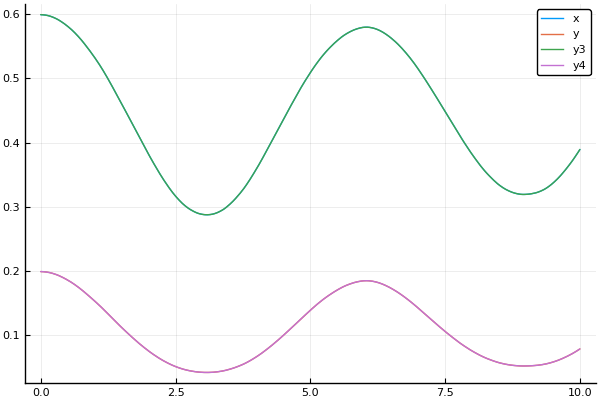

In [102]:
plot(t_reg,xtail_hist,label="x")
plot!(t_reg,ytail_hist,label="y")
plot!(t_reg,x_comp)
plot!(t_reg,y_comp)